This notebook and transformer training is optimized to run on CUDA GPU accelerators. For free ressources, upload to google colab and adjust the paths to the dataset to test the transformer.

All cells until the section master functions define the thesis functions and classes

From section "master functions" and below, the code calls all above functions for preprocessing, trainng, evaluation and plotting

Optional functions include generation of result csv and plotting attention heatmaps

# Imports

In [5]:
# colab imports to mount google drive and training progress bars
from google.colab import drive
drive.mount('/content/drive')
from tqdm.notebook import tqdm

Mounted at /content/drive


In [ ]:
# Standard library
import os
import glob
import time
import pickle
import random
from typing import List, Tuple, Union, Optional, Dict

# computing
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


# Seeds
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)


# Preprocessing

In [ ]:
def preprocess_stock(
    df_raw: pd.DataFrame,
    train_frac: float,
    val_frac: float
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Preprocess the input DataFrame by calculating log returns and realized volatility,
    split it into training and testing sets.
    Returns:
    train, val and test split of the minutely input dataframe
    '''
    minutely = df_raw.copy()

    # turn column to datetime, add helper day column
    minutely["Date Time"] = pd.to_datetime(minutely["Date Time"])
    minutely = minutely.sort_values("Date Time")
    minutely["day"] = minutely["Date Time"].dt.date

    # minutely log returns withing days from close
    minutely["log_close"] = np.log(minutely["Close"].astype(float))
    minutely["ret_1m"] = minutely.groupby("day")["log_close"].diff()

    # remove first minute of each day since no return
    minutely = minutely[minutely["Date Time"].dt.time != pd.to_datetime("09:35").time()]

    # Calculate the RV for each grouped 380 row day
    group_sums = minutely.groupby("day")["ret_1m"].transform(lambda x: np.sqrt(np.sum(x**2)))

    # Add the group sums as a new column, take log
    minutely["realized_vol"] = group_sums
    minutely["log_rv"] = np.log(minutely["realized_vol"].replace(0.0, 1e-12))
    minutely = minutely.reset_index(drop=True)

    # calculate train test split; make sure no day is cut in half between the two data splits
    train_idx = int(np.floor(minutely.shape[0] * train_frac / 380) * 380)
    val_idx = int(np.floor(minutely.shape[0] * val_frac / 380) * 380)
    # Split the DataFrame into train, val, test
    df_train = minutely.iloc[:train_idx]
    df_val = minutely.iloc[train_idx:train_idx+val_idx]
    df_test = minutely.iloc[train_idx+val_idx:]

    return df_train, df_val, df_test

In [ ]:
def preprocess_stock_interval(
    df_raw: pd.DataFrame,
    train_frac: float,
    val_frac: float,
    interval_minutes: int = 10
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    # 1. Validation
    minutes_per_day = 380
    if minutes_per_day % interval_minutes != 0:
        raise ValueError(f"Interval {interval_minutes} must divide 380 evenly.")

    bins_per_day = minutes_per_day // interval_minutes

    minutely = df_raw.copy()
    minutely["Date Time"] = pd.to_datetime(minutely["Date Time"])
    minutely = minutely.sort_values("Date Time") # Strict sort required for diff

    # 2. Log Returns
    minutely["log_close"] = np.log(minutely["Close"].astype(float))

    # LEAKAGE PROTECTION:
    # We use a simple diff(), but we MUST drop the specific times that bridge days.
    minutely["ret_1m"] = minutely["log_close"].diff()

    # Remove 09:35. This removes the row containing the "Overnight Return"
    # (09:35 today - 15:55 yesterday).
    # This ensures Day N data depends ONLY on Day N prices.
    mask_valid_time = minutely["Date Time"].dt.time != pd.to_datetime("09:35").time()
    minutely = minutely.loc[mask_valid_time].reset_index(drop=True)

    # 3. Strict Shape Check (Prevents Partial Day Leakage)
    n_rows = len(minutely)
    if n_rows % minutes_per_day != 0:
        # If we have leftover rows, truncate them to ensure no partial days enter the train set
        # Partial days would result in a lower Daily RV target, confusing the model.
        n_days = n_rows // minutes_per_day
        minutely = minutely.iloc[:n_days * minutes_per_day]
        print(f"Warning: Dropped {n_rows % minutes_per_day} rows to enforce full days.")
    else:
        n_days = n_rows // minutes_per_day

    # 4. Reshape & Calculate (The Fast Part)
    # Shape: (Days, Intervals, Minutes)
    returns_array = minutely["ret_1m"].values.reshape(n_days, bins_per_day, interval_minutes)

    # Interval RV (Feature)
    rv_interval_values = np.sqrt(np.sum(returns_array**2, axis=2))

    # Daily RV (Target) - Summing over axes 1 and 2 covers the whole day
    rv_daily_values = np.sqrt(np.sum(returns_array**2, axis=(1, 2)))

    # 5. Reconstruct
    # We take the date from the first interval of every day
    dates = minutely["Date Time"].dt.date.values[::minutes_per_day]

    # Flatten features to 1D arrays
    flat_interval_rv = rv_interval_values.flatten()

    # Repeat daily targets (once per interval)
    expanded_daily_rv = np.repeat(rv_daily_values, bins_per_day)
    expanded_dates = np.repeat(dates, bins_per_day)

    # Interval Counter (0 to 37)
    interval_indices = np.tile(np.arange(bins_per_day), n_days)

    df_result = pd.DataFrame({
        "day": expanded_dates,
        "interval_idx": interval_indices,
        f"rv_feature": flat_interval_rv,
        "daily_rv": expanded_daily_rv
    })

    # Log Transforms
    df_result[f"log_rv_feature"] = np.log(df_result[f"rv_feature"].replace(0.0, 1e-12))
    df_result["log_daily_rv"] = np.log(df_result["daily_rv"].replace(0.0, 1e-12))

    # 6. Split
    # Split strictly by day index to avoid leaking info from 2pm to 10am of the same day (if shuffling)
    # Though sequential splitting usually handles this, defining by rows_per_day is safest.
    total_rows = len(df_result)
    rows_per_day_out = bins_per_day

    train_idx = int(np.floor(total_rows * train_frac / rows_per_day_out) * rows_per_day_out)
    val_idx = int(np.floor(total_rows * val_frac / rows_per_day_out) * rows_per_day_out)

    df_train = df_result.iloc[:train_idx]
    df_val = df_result.iloc[train_idx:train_idx+val_idx]
    df_test = df_result.iloc[train_idx+val_idx:]

    return df_train, df_val, df_test

In [ ]:
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view
from typing import Tuple

def create_sequences_interval(
    df: pd.DataFrame,
    n_days: int
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Vectorized generation of rolling subsequences.
    Automatically detects 'rows_per_day' from the input dataframe.

    Parameters:
    df : pd.DataFrame
        Must contain columns: 'day', 'log_rv_feature', 'log_daily_rv'
    n_days : int
        Context window size in days

    Returns:
    X : shape (num_sequences, rows_per_day * n_days, 1)
    y_residual : shape (num_sequences,)
    y_true_RV : shape (num_sequences,)
    har_feature : shape (num_sequences,)
    """
    # 1. Infer rows per day dynamically
    # We count how many rows belong to the first day in the dataframe
    first_day = df["day"].iloc[0]
    rows_per_day = len(df[df["day"] == first_day])

    # 2. Prepare Data as NumPy arrays (Memory Efficient)
    # We use the generic column name 'log_rv_feature' established in Part 1
    rv_feature_arr = df["log_rv_feature"].to_numpy()
    daily_rv_arr = df["log_daily_rv"].to_numpy()

    # 3. Create X (Features) using Stride Tricks
    # We want a sliding window of length (n_days * rows_per_day)
    # But we only want to slide it forward by 1 DAY (rows_per_day) at a time, not 1 minute.

    window_size = n_days * rows_per_day

    # Generate ALL windows (sliding by 1 row)
    # Shape: (Total_Rows - Window_Size + 1, Window_Size)
    all_windows = sliding_window_view(rv_feature_arr, window_shape=window_size)

    # Slice to keep only windows that start at the beginning of a day
    # We step by `rows_per_day`
    # We strictly slice up to the point where we still have a "Next Day" target available
    valid_sequences_count = (len(df) // rows_per_day) - n_days

    X = all_windows[::rows_per_day]

    # Truncate X to match the number of valid targets available
    # (Sometimes sliding_window_view includes the very last window which has no "next day" target)
    X = X[:valid_sequences_count]

    # Reshape X to (Samples, TimeSteps, Features)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # 4. Create y (Targets) using Vectorized Indexing
    # We need the daily_rv of the day AFTER each sequence.
    # If sequence `i` covers days [0...9], target is Day 10.
    # The index for the start of Day 10 is: (n_days) * rows_per_day

    # Create indices for the start of every target day
    # Start: n_days * rows_per_day
    # Step: rows_per_day
    target_indices = np.arange(
        start=n_days * rows_per_day,
        stop=n_days * rows_per_day + (valid_sequences_count * rows_per_day),
        step=rows_per_day
    )

    # Get True Target (Day T)
    y_true_RV = daily_rv_arr[target_indices]

    # Get HAR Feature (Day T-1)
    # Since daily_rv is repeated for every row in the day,
    # the value at `target_index - 1` is the last row of Day T-1.
    har_feature = daily_rv_arr[target_indices - 1]

    # Calculate Residual
    y_residual = y_true_RV - har_feature

    return X, y_residual, y_true_RV, har_feature

In [ ]:
def create_sequences_array_residual(
    df: pd.DataFrame,
    n_days: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Create rolling subsequences of intraday returns as X and their residual target y.
    Also return the HAR model data which is the previous day RV of target and full RV.
    Returns:
    X : np.ndarray, shape (num_sequences, 380 * n_days, 1)
        array of subsequences of intraday returns
    y_residual : np.ndarray, shape (num_sequences,)
        y_true_RV - y_true_RV shifted by one; naive residual
        the target day and the previous day.
    y_true_RV : np.ndarray, shape (num_sequences,)
        True log realized volatility of the target day.
    har_feature : np.ndarray, shape (num_sequences,)
        Previous day's log realized volatility for HAR model later
    """
    # create lists to fill with subsequences and their Realized Volatility targets
    sequence_list = []
    sequence_target_residual = []
    sequence_targe_true_RV = []
    har_feature = []

    # Loop through the DataFrame to create subsequences
    for i in range(int(len(df)/380-n_days)):

        # Extract a subsequence of n_days (each day with 380 rows)
        tmp_subsequence = df.iloc[i * 380: (n_days + i) * 380]
        arr = tmp_subsequence["ret_1m"].to_numpy()

        arr = arr.reshape(1, 380*n_days, 1)
        sequence_list.append(arr)

        # Try to get the target value for the current subsequence
        try:
            target_day_log_rv = df.iloc[(n_days + i) * 380]["log_rv"]
            previous_day_log_rv = df.iloc[(n_days + i) * 380 - 1]["log_rv"]

            # this checks if the data splits are valid; they are for all stocks
            # but just a sanity check
            if target_day_log_rv == previous_day_log_rv:
              raise ValueError(
                  f"Target and previous day log_rv are identical at index {(n_days + i) * 380}."
              )
            subsequence_target = target_day_log_rv - previous_day_log_rv
            har_feature.append(previous_day_log_rv)

            sequence_target_residual.append(subsequence_target)
            sequence_targe_true_RV.append(target_day_log_rv)
        except:
            # Print a message if an IndexError occurs
            print("last iteration")

    X = np.vstack(sequence_list)
    y_residual = np.array(sequence_target_residual)
    y_true_RV = np.array(sequence_targe_true_RV)
    har_feature = np.array(har_feature)

    return X, y_residual, y_true_RV, har_feature

In [ ]:
def scaler(
    X_train: np.ndarray,
    X_val: np.ndarray,
    X_test_dic: Dict[str, np.ndarray],
    d: int
) -> Tuple[np.ndarray, np.ndarray, Dict[str, np.ndarray]]:
    """
    Standardize train, val, and test along the feature dimension.
    Learn parameters from train set only.
    Test data has to be handled separate since the arrays can't be stacked into
    one large dataset like train and val
    Only scaled first d features in case extra input features are tested like calendar data
    """

    # only scaled last d features, was used when eg calendar features were tested
    mu = X_train[:, :, :d].mean(axis=(0, 1), keepdims=True)
    sd = X_train[:, :, :d].std(axis=(0, 1), keepdims=True) + 1e-8

    def scale(X):
        X_scaled = X.copy()
        X_scaled[:, :, :d] = (X_scaled[:, :, :d] - mu) / sd
        return X_scaled

    X_train_scaled = scale(X_train)
    X_val_scaled   = scale(X_val)

    # loop through test dict
    X_test_scaled = {stock: scale(arr) for stock, arr in X_test_dic.items()}

    return X_train_scaled, X_val_scaled, X_test_scaled

# model class and functions, dataloader

In [ ]:
def mk_loader(
    X: np.ndarray,
    y: np.ndarray,
    bs: int = 64,
    shuffle: bool = False,
    num_workers: int = 2
) -> DataLoader:
    """
    Create a CUDA-optimized PyTorch DataLoader with pinned memory and
    persistent workers for efficient training. Optionally shuffle data
    Returns torch.utils.data.DataLoader
    """

    x_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    ds = TensorDataset(x_t, y_t)

    return DataLoader(
        ds, batch_size=bs, shuffle=shuffle,
        pin_memory=True, num_workers=num_workers,
        persistent_workers=(num_workers > 0)
    )

In [ ]:
class VolFormer(nn.Module):
    """
    Encoder for sequence-to-scalar task.

    Features:
    - Learnable token embeddings via a linear layer from d_in -> d_model.
    - Learnable positional embeddings (nn.Embedding).
    - Prepend[CLS] token for pooled representation.
    - Manual unrolling of TransformerEncoderLayer to expose per-layer attention maps.

    Parameters:
    d_in : int
        Input feature dimension per timestep.
    d_model : int, default=128
        Transformer hidden size / embedding dimension.
    nhead : int, default=4
        Number of attention heads.
    num_layers : int, default=3
        Number of Transformer encoder layers.
    p_drop : float, default=0.1
        Dropout rate used inside encoder layers and head.
    use_cls : bool, default=True
        If True, prepend a learnable [CLS] token and pool from it
    ff_mult : int, default=4 (suggested in Vaswani et al., 2017)
        Multiplier for the feed-forward dimension (ffn_dim = ff_mult * d_model).
    max_len : int, default=4096
        Maximum supported sequence length (without the CLS). Sequences longer than
        this will raise a ValueError.

    Inputs:
    x : torch.Tensor
        Shape [B, L, d_in]. Batch of sequences.

    Returns:
    output : torch.Tensor
        Shape [B]. Regression output per sequence.
    (output, attn) : Tuple[torch.Tensor, torch.Tensor] if return_attention=True
        - output: [B]
        - attn: [num_layers, B, nhead, L+1, L+1] +1 for CLS
    """
    def __init__(
        self,
        d_in: int,
        d_model: int = 128,
        nhead: int = 4,
        num_layers: int = 3,
        p_drop: float = 0.1,
        use_cls: bool = True,
        ff_mult: int = 4,
        max_len: int = 4096,
    ) -> None:
        super().__init__()
        self.use_cls = use_cls
        self.d_model = d_model
        self.embed = nn.Linear(d_in, d_model)

        # positional embedding for tokens (add +1 for CLS position)
        self.pos_emb = nn.Embedding(max_len + 1, d_model)

        # define encoder layers
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
              d_model=d_model, nhead=nhead,
              dim_feedforward=ff_mult*d_model,
              dropout=p_drop, batch_first=True, norm_first=True
            )
            for _ in range(num_layers)
        ])

        if use_cls:
            self.cls = nn.Parameter(torch.zeros(1, 1, d_model))
            nn.init.normal_(self.cls, mean=0.0, std=0.02)

        # define heads
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(p_drop),
            nn.Linear(d_model, 1)
        )

    # define forward pass
    def forward(self, x, return_attention=False):  # x: [B, L, d_in]
        B, L, _ = x.shape
        h = self.embed(x)

        # add positional embeddings
        # if CLS is used, its position index = 0, the rest shifted by +1
        if self.use_cls:
            pos_idx = torch.arange(1, L+1, device=x.device).unsqueeze(0).expand(B, -1)
            h = h + self.pos_emb(pos_idx)
            cls = self.cls.expand(B, -1, -1)

            # CLS gets position 0
            h = torch.cat([cls, h], dim=1)  # [B, L+1, d_model]
            h = h + torch.cat([self.pos_emb(torch.zeros(B,1, dtype=torch.long, device=x.device)),
                               torch.zeros_like(h[:,1:])], dim=1)
        else:
            pos_idx = torch.arange(0, L, device=x.device).unsqueeze(0).expand(B, -1)
            h = h + self.pos_emb(pos_idx)

        # manual encoder forward pass to get attention, only on test sets
        all_attention_maps = []
        for i, layer in enumerate(self.encoder_layers):
            # norm first before attention
            h_norm = layer.norm1(h)

            # preserve heads in attention map
            attn_output, attn_weights = layer.self_attn(
                h_norm, h_norm, h_norm,
                need_weights=True,
                average_attn_weights=False
            )
            h = h + layer.dropout1(attn_output)

            all_attention_maps.append(attn_weights)

            # feed-forward block
            h_norm = layer.norm2(h)
            ff_output = layer.linear2(
                layer.dropout(layer.activation(layer.linear1(h_norm)))
                )
            h = h + layer.dropout2(ff_output)

        pooled = h[:, 0] if self.use_cls else h.mean(dim=1)
        output = self.head(pooled).squeeze(-1)

        if return_attention:
          # stack into [num_layers, B, n_heads, L+1, L+1]
            return output, torch.stack(all_attention_maps, dim=0)
        return output


In [ ]:
def train_model_cuda(
    Xtr: np.ndarray,
    ytr: np.ndarray,
    Xva: np.ndarray,
    yva: np.ndarray,
    *,
    d_model: int = 128,
    nhead: int = 4,
    num_layers: int = 3,
    batch_size: int = 64,
    lr: float = 1e-3,
    max_epochs: int = 50,
    weight_decay: float = 1e-2,
    p_drop: float = 0.1,
    patience: int = 10,
    ff_mult: int = 4,
    ModelClass: nn.Module = None,
) -> nn.Module:
    """
    Train a Transformer-style model on CUDA using mixed precision (AMP)
    with Learning Rate Scheduling.
    """

    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True

    # create dataloaders
    train_loader = mk_loader(Xtr, ytr, bs=batch_size, shuffle=True)
    val_loader   = mk_loader(Xva, yva, bs=batch_size, shuffle=False)

    # Model
    if ModelClass is None:
        ModelClass = VolFormer

    model = ModelClass(
        d_in=Xtr.shape[-1],
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        p_drop=p_drop,
        ff_mult=ff_mult,
        max_len=max(Xtr.shape[1], Xva.shape[1]) + 1
    ).to(device)

    # Optimizer
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # --- SCHEDULER IMPLEMENTATION (Fixed) ---
    # removed 'verbose=True' to fix the error
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=3
    )

    scaler = torch.amp.GradScaler("cuda")

    # early stopping trackers
    best_val = float("inf")
    best_state = None
    wait = 0

    # define training loop
    for epoch in range(1, max_epochs + 1):

        # ----- Training
        model.train()
        tr_loss, n = 0.0, 0

        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}", leave=False):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda"):
                pred = model(xb) # forward pass
                loss = F.mse_loss(pred, yb) # loss
            scaler.scale(loss).backward() # scale gradients
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()

            tr_loss += loss.item() * xb.size(0)
            n += xb.size(0)
        tr_loss /= max(1, n)

        # ----- Validation
        model.eval()
        va_loss, n = 0.0, 0
        with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                pred = model(xb)
                loss = F.mse_loss(pred, yb)
                va_loss += loss.item() * xb.size(0)
                n += xb.size(0)
        va_loss /= max(1, n)

        # --- STEP SCHEDULER ---
        # Update LR based on validation loss
        before_lr = opt.param_groups[0]["lr"]
        scheduler.step(va_loss)
        after_lr = opt.param_groups[0]["lr"]

        # Manually check if LR changed for logging since verbose=True is gone
        lr_status = ""
        if after_lr < before_lr:
            lr_status = f" | 📉 LR dropped: {before_lr:.1e} -> {after_lr:.1e}"

        improved = va_loss < best_val
        print(f"Epoch {epoch:03d} | Train {tr_loss:.6f} | Val {va_loss:.6f}{lr_status}{' *' if improved else ''}")

        # track early stopping
        if improved:
            best_val = va_loss
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(device)
        print(f"Restored best model with validation loss: {best_val:.6f}")
    else:
        print("no improvement; returning final weights")

    return model

In [ ]:
def train_model_cuda_old(
    Xtr: np.ndarray,
    ytr: np.ndarray,
    Xva: np.ndarray,
    yva: np.ndarray,
    *,
    d_model: int = 128,
    nhead: int = 4,
    num_layers: int = 3,
    batch_size: int = 64,
    lr: float = 1e-3,
    max_epochs: int = 50,
    weight_decay: float = 1e-2,
    p_drop: float = 0.1,
    patience: int = 10,
    ff_mult: int = 4,
    ModelClass: nn.Module = None,
) -> nn.Module:
    """
    Train a Transformer-style model on CUDA using mixed precision (AMP).

    Parameters
    ----------
    Xtr, ytr
    Xva, yva
    Xva, yva: np.ndarray
        Features and targets.
        - X: [N_train, L, d_in]
        - y: [N_train, 1]
    d_model, nhead, num_layers : int
        Transformer hyperparameters for the encoder.
    batch_size : int, default=64
        Mini-batch size.
    lr : float, default=1e-3
        Learning rate for AdamW.
    max_epochs : int, default=50
        Maximum number of epochs.
    weight_decay : float, default=1e-2
        AdamW weight decay.
    p_drop : float, default=0.1
        Dropout probability.
    patience : int, default=10
        Early stopping patience.
    ff_mult : int, default=4
        Feed-forward expansion multiplier (ffn_dim = ff_mult * d_model) as in Vaswani et al.
    ModelClass : nn.Module, default=None
        The model class to instantiate.

    Returns:
    model : nn.Module
        The trained model restored to the best validation checkpoint.
    """

    device = torch.device("cuda")
    # Enable CuDNN autotuner for fixed shapes to speed up training
    torch.backends.cudnn.benchmark = True

    # create dataloaders
    train_loader = mk_loader(Xtr, ytr, bs=batch_size, shuffle=True)
    val_loader   = mk_loader(Xva, yva, bs=batch_size, shuffle=False)

    # Model
    if ModelClass is None:
        ModelClass = VolFormer  # use your class defined elsewhere

    model = ModelClass(
        d_in=Xtr.shape[-1],
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        p_drop=p_drop,
        ff_mult=ff_mult,
        max_len=max(Xtr.shape[1],
                    Xva.shape[1]) + 1
    ).to(device)

    # Optimizer and AMP scaler
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = torch.amp.GradScaler("cuda")

    # early stopping trackers
    best_val = float("inf")
    best_state = None
    wait = 0

    # define training loop
    for epoch in range(1, max_epochs + 1):

        # ----- Training
        model.train()
        tr_loss, n = 0.0, 0

        # iterate over training batches
        for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}", leave=False):
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="cuda"):
                pred = model(xb) # forward pass
                loss = F.mse_loss(pred, yb) # loss
            scaler.scale(loss).backward() # scale gradients
            nn.utils.clip_grad_norm_(model.parameters(), 0.5) # keeps training stable
            scaler.step(opt) # step optimizer
            scaler.update() # update scaler

            tr_loss += loss.item() * xb.size(0)
            n += xb.size(0)
        tr_loss /= max(1, n)

        # ----- Validation
        model.eval()
        va_loss, n = 0.0, 0
        with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                pred = model(xb)
                loss = F.mse_loss(pred, yb)
                va_loss += loss.item() * xb.size(0)
                n += xb.size(0)
        va_loss /= max(1, n)

        improved = va_loss < best_val
        print(f"Epoch {epoch:03d} | Train {tr_loss:.6f} | Val {va_loss:.6f}{' *' if improved else ''}")

        # track early stopping
        if improved:
            best_val = va_loss
            # Keep CPU copy
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    # resotre best weights
    if best_state is not None:
        model.load_state_dict(best_state)
        model.to(device)
        print(f"Restored best model with validation loss: {best_val:.6f}")
    else:
        print("no improvement; returning final weights")

    return model

In [ ]:
def predict_array_cuda(
    X: np.ndarray,
    model: nn.Module,
    bs: int = 64,
) -> np.ndarray:
    """
    Run CUDA-only batched predictions with mixed precision
    Returns
    preds : np.ndarray
        Concatenated predictions on CPU.
    """

    device = torch.device("cuda")
    # create dummy target just to reuse mk_loader's pinning
    # values are ignored during inference
    loader = mk_loader(X, np.zeros(len(X), dtype=np.float32), bs=bs, shuffle=False)
    outs = []
    model.eval()
    with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
        for xb, _ in loader:
            xb = xb.to(device, non_blocking=True)
            # move to CPU
            outs.append(model(xb).float().cpu().numpy())
    return np.concatenate(outs, axis=0)

# run training / HAR model

In [ ]:
import numpy as np
import pandas as pd

def feature_names_5d_10m():
    # d-5 (oldest) … d-1 (most recent), each with 38 bins
    names = []
    for d in range(5, 0, -1):          # 5,4,3,2,1
        for b in range(1, 39):         # 1..38
            names.append(f"d-{d}_bin{b:02d}")
    return names

def stack_all(X_train, X_val, X_test, y_train, y_val, y_test):
    X = np.concatenate([X_train, X_val, X_test], axis=0)
    y = np.concatenate([y_train, y_val, y_test], axis=0)
    return X, y

def correlations_feature_to_target(X, y):
    """
    X: (N, 190, 1) or (N, 190)
    y: (N,)
    returns: pandas Series indexed by feature name with Pearson r
    """
    if X.ndim == 3:
        X = X.squeeze(-1)  # -> (N, 190)
    # guard against constant columns
    stds = X.std(axis=0, ddof=0)
    safe = stds > 0
    r = np.full(X.shape[1], np.nan)
    for j in range(X.shape[1]):
        if safe[j]:
            xj = X[:, j]
            # Pearson r
            r[j] = np.corrcoef(xj, y)[0, 1]
    return pd.Series(r, index=feature_names_5d_10m())

"""# --- Use it ---
# Choose whether to do it on the whole dataset (as your prof asked) or training-only.
# WHOLE DATASET
X_all, y_all = get_data_train_model(stock_files[:5], train_frac=0.7,
            val_frac = 0.15,
            n_days_context=5,
            d_model=64,
            nhead=2,
            num_layers=2,
            batch_size=128,
            lr=1e-3,
            max_epochs=50,
            patience=10)
corr_all = correlations_feature_to_target(X_all, y_all)

# If you want training-only (often better to avoid leakage):
# corr_train = correlations_feature_to_target(X_train, y_true_RV_train)

# Inspect strongest +/- correlations
corr_all.sort_values(ascending=False).head(10)
corr_all.sort_values(ascending=True).head(10)

# Optional: mean absolute correlation across the 190 inputs
mean_abs_corr = np.nanmean(np.abs(corr_all.values))
print("Mean |corr| across features:", mean_abs_corr)"""


'# --- Use it ---\n# Choose whether to do it on the whole dataset (as your prof asked) or training-only.\n# WHOLE DATASET\nX_all, y_all = get_data_train_model(stock_files[:5], train_frac=0.7,\n            val_frac = 0.15,\n            n_days_context=5,\n            d_model=64,\n            nhead=2,\n            num_layers=2,\n            batch_size=128,\n            lr=1e-3,\n            max_epochs=50,\n            patience=10)\ncorr_all = correlations_feature_to_target(X_all, y_all)\n\n# If you want training-only (often better to avoid leakage):\n# corr_train = correlations_feature_to_target(X_train, y_true_RV_train)\n\n# Inspect strongest +/- correlations\ncorr_all.sort_values(ascending=False).head(10)\ncorr_all.sort_values(ascending=True).head(10)\n\n# Optional: mean absolute correlation across the 190 inputs\nmean_abs_corr = np.nanmean(np.abs(corr_all.values))\nprint("Mean |corr| across features:", mean_abs_corr)'

In [ ]:
def get_data_train_model(
    file_list,
    *,
    train_frac: float = 0.7,
    val_frac: float = 0.15,
    n_days_context: int = 3,
    interval_minutes: int = 10,
    d_model: int = 128,
    nhead: int = 4,
    num_layers: int = 3,
    batch_size: int = 64,
    lr: float = 1e-3,
    max_epochs: int = 50,
    patience: int = 10,
    save_preproc_data: bool = False,
    p_drop: float = 0.1,
) -> Tuple[
    nn.Module,
    Dict[str, np.ndarray],
    Dict[str, np.ndarray],
    Dict[str, np.ndarray],
    Dict[str, np.ndarray],
]:
    """
    end-to-end: load CSVs, per-stock splits, sequence windows, scale, train (CUDA), return model & test blobs.

    Parameters:
    file_list :
        List of CSV paths from gdrive.
    train_frac : float, default=0.7
        Fraction of rows used for the training split.
    val_frac : float, default=0.15
        Fraction of rows used for the validation split.
    n_days_context : int, default=3
        Number of consecutive days used as context window.
    d_model, nhead, num_layers : int
        Transformer hyperparameters.
    batch_size : int, default=64
        Batch size for training and validation DataLoaders.
    lr : float, default=1e-3
        Learning rate for AdamW.
    max_epochs : int, default=50
        Maximum training epochs.
    patience : int, default=10
        Early stopping patience.
    """

    Xtr_list, ytr_list = [], []
    Xva_list, yva_list = [], []
    Xte_list, yte_list = [], []
    names, te_lengths = [], []
    X_test_dic = {}
    y_test_dic = {}
    har_train = {}
    har_test = {}

    # loop over all stock csv
    for path in file_list:
        df_raw = pd.read_csv(path)
        stock_name = os.path.splitext(os.path.basename(path))[0]
        print(stock_name)

        # preprocess stock csv
        train_df, val_df, test_df = preprocess_stock_interval(df_raw, train_frac, val_frac, interval_minutes)

        # window into sequences (shape: [N, seq_len, feat_dim])
        X_tr, y_tr, train_RV, train_har = create_sequences_interval(train_df, n_days_context) # X_test, y_residual, y_full, y_har
        X_va, y_va, val_RV, val_har = create_sequences_interval(val_df, n_days_context)
        X_te, y_te, test_RV, test_har = create_sequences_interval(test_df, n_days_context)

        Xtr_list.append(X_tr); ytr_list.append(y_tr)
        Xva_list.append(X_va); yva_list.append(y_va)
        Xte_list.append(X_te); yte_list.append(y_te)
        X_test_dic[stock_name] = X_te
        y_test_dic[stock_name] = test_RV
        har_train[stock_name] = np.concatenate((train_har, val_har))
        har_test[stock_name] = test_har

        names.append(stock_name)
        te_lengths.append(len(X_te))

    # concatenate across stocks to make one big dataset
    X_train = np.concatenate(Xtr_list, axis=0).astype(np.float32)
    y_train = np.concatenate(ytr_list, axis=0).astype(np.float32)
    X_val   = np.concatenate(Xva_list, axis=0)
    y_val   = np.concatenate(yva_list, axis=0)
    X_test = np.concatenate(Xte_list, axis=0)
    y_test = np.concatenate(yte_list, axis=0)

    # scale big dataset after concat
    X_train_scaled, X_val_scaled, X_test_dic_scaled = scaler(X_train, X_val, X_test_dic, 1)
    print(X_train_scaled.shape)
    print(X_val_scaled.shape)

      # TODO
    # train on pooled data
    start_time = time.time()
    model = train_model_cuda(
        X_train_scaled, y_train, X_val_scaled, y_val,
        d_model=d_model, nhead=nhead, num_layers=num_layers,
        batch_size=batch_size, lr=lr, max_epochs=max_epochs, patience=patience, p_drop=p_drop
    )
    end_time = time.time()
    minutes = int((end_time - start_time) // 60)
    seconds = (end_time - start_time) % 60
    print(f"Training completed in {minutes} minutes and {seconds:.2f} seconds.")

    return model, X_test_dic_scaled, y_test_dic, har_train, har_test

In [ ]:
def run_test_residual(
    model: nn.Module,
    X_test_dic: Dict[str, np.ndarray],
    y_test_dic: Dict[str, np.ndarray],
) -> Tuple[Dict[str, Dict[str, np.array]], float, float]:
    """
    Evaluate transformer residual predictions agains naive.

    Parameters
    model : nn.Module
        Trained PyTorch model that predicts residuals given sequences.
    X_test_dic : dict[str, np.ndarray]
        Per-stock test feature arrays, each of shape [N, L, d_in].
    y_test_dic : dict[str, np.ndarray]
        Per-stock true target vectors (levels, not residuals).

    Returns
    out : dict[str, dict]
        Per-stock dictionary with:
            - "y_pred": np.ndarray, reconstructed level predictions (naive + residual_pred of model)
            - "y_test": np.ndarray, true log RV
            - "transformer_MSE": float, MSE of y_pred vs. y_test
            - "naive_pred": np.ndarray, naive baseline
            - "naive_MSE": float, MSE of naive_pred vs. y_test
            - "residual_MSE": float, MSE of residuals prediction vs. true residuals (same as transformer MSE)
            - "n_samples_used": int, number of points used for MSE (N-1 after dropping first)
    model_mse_mean : float
        Mean of per-stock transformer MSEs.
    naive_mse_mean : float
        Mean of per-stock naive MSEs.

    Notes
    -----
    - All metrics ignore the first element (index 0) to avoid the wrap-around artifact
      introduced by np.roll when forming the naive baseline.
    """
    out = {}
    model_mse_counter = 0
    naive_mse_counter = 0

    # iterate of all stock test sets
    for stock in X_test_dic.keys():
        stock_dic = {}

        y_test = y_test_dic[stock]
        # predict test set through transformer
        residual_pred = predict_array_cuda(X_test_dic[stock], model)
        naive_pred = np.roll(y_test, 1)
        # add naive residual back to transformer residual prediciton to compare agains true RV and HAR
        stock_pred = naive_pred + residual_pred

        actual_residual = y_test[1:] - naive_pred[1:]

        # Make sure to slice residual_pred to match the length
        residual_mse = np.mean((residual_pred[1:] - actual_residual)**2)
        test_mse = np.mean((stock_pred[1:] - y_test[1:])**2) # both are the same, can be shown with algebra
        naive_mse = np.mean((naive_pred[1:] - y_test[1:])**2)

        stock_dic["y_pred"] = stock_pred
        stock_dic["y_test"] = y_test
        stock_dic["transformer_MSE"] = test_mse
        stock_dic["naive_pred"] = naive_pred
        stock_dic["naive_MSE"] = naive_mse
        stock_dic["residual_MSE"] = residual_mse

        out[stock] = stock_dic
        model_mse_counter += test_mse
        naive_mse_counter += naive_mse

    return out, model_mse_counter / len(X_test_dic), naive_mse_counter / len(X_test_dic)

In [ ]:
def har_features(log_rv: pd.Series) ->pd.DataFrame:
    """
    Builds HAR features from a log realized volatility series.
    """
    df = pd.DataFrame({"log_rv": log_rv})

    # Target: Realized Volatility of the next day (t+1)
    df["y_tomorrow"] = df["log_rv"].shift(-1)

    # Predictors from day t (the most recent available information)
    df["har_1"] = df["log_rv"]                              # Daily component
    df["har_5"] = df["log_rv"].rolling(5).mean()             # Weekly average
    df["har_22"] = df["log_rv"].rolling(22).mean()           # Monthly average

    df = df.dropna()
    return df

def fit_har_baseline(y_train, y_test):
    """
    Trains a HAR model on training data and predicts on test data.

    Args:
        y_train (np.array): Array of training log_rv targets.
        y_test (np.array): Array of testing log_rv targets.

    Returns:
        tuple: (HAR model predictions on the test set, fitted model summary)
    """
    # Create a single continuous series for feature engineering
    full_series = pd.Series(np.concatenate([y_train, y_test]))

    # Generate HAR features for the entire dataset
    df_har = har_features(full_series)

    # Re-create the chronological split
    n_train = len(y_train)
    # Adjust for NaNs dropped at the beginning by har_features
    train_end_idx = n_train - (len(full_series) - len(df_har))
    train_set = df_har.iloc[:train_end_idx]
    test_set = df_har.iloc[train_end_idx:]

    # estimate parameters on train set only
    X_train = sm.add_constant(train_set[["har_1", "har_5", "har_22"]])
    y_train_har = train_set["y_tomorrow"]

    model = sm.OLS(y_train_har, X_train).fit()

    # predict test set
    X_test = sm.add_constant(test_set[["har_1", "har_5", "har_22"]])
    predictions = model.predict(X_test).to_numpy()
    har_mse = np.mean((predictions[1:] - test_set["y_tomorrow"][1:])**2)

    return predictions, model.summary(), har_mse

# Diebold-mariano code (not mine)

In [ ]:
# Author   : John Tsang
# Date     : December 7th, 2017
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test
##########################################################
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of
#   prediction mean squared errors. International Journal of forecasting,
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy,
#   Journal of business & economic statistics 13(3), 253-264.
#
##########################################################
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)

    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np

    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []

    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()

    # Length of lists (as real numbers)
    T = float(len(actual_lst))

    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)

    # Mean of d
    mean_d = pd.Series(d_lst).mean()

    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)

    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')

    rt = dm_return(DM = DM_stat, p_value = p_value)

    return rt

<>:72: SyntaxWarning: invalid escape sequence '\d'
<>:72: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-2899217387.py:72: SyntaxWarning: invalid escape sequence '\d'
  comp = re_compile("^\d+?\.\d+?$")


# plotting functions

In [ ]:
def make_plot(
    stock: str,
    y_pred: np.array,
    y_test: np.array,
) -> None:
    """
    Plot True RV against Prediction
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[1:], label="True log RV", alpha = 0.5, color="darkblue")
    plt.plot(y_pred[1:],   label="Transformer prediction", alpha=1, color="darkorange")
    plt.title(f"Test period {stock}")
    plt.xlabel("Test days"); plt.ylabel("log Realized Volatility")
    plt.legend()
    plt.show(); plt.close()

In [ ]:
def get_attention_maps(model: nn.Module, X_sample: np.ndarray) -> np.ndarray:
    """
    Gets the attention maps for a single data sample.

    Parameters:
        model:  Trained VolFormer model.
        X_sample: A single input sequence, e.g., X_test_dic['AAPL'][0].

    Returns:
        A numpy array of attention weights. [num_layers, n_heads, T, T]
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # The sample needs to be in a batch of 1 and on the correct device
    # Shape should be [1, sequence_length, features]
    if len(X_sample.shape) == 2:
        X_sample = np.expand_dims(X_sample, axis=0) # [1, L ,d_in]

    xb = torch.tensor(X_sample, dtype=torch.float32).to(device)

    with torch.no_grad():
        # Call the model with the flag to return attention
        _, attn = model(xb, return_attention=True) # [num_layers, B, n_heads, T, T]

    # squeeze batch dim
    attn_all = attn.squeeze(1).cpu().numpy()
    return attn_all


def plot_attention_map_layer_head(
    attn_all,
    stock: str,
    day_index: int,
    layer: int = 0,
    head: int | None = None,
    day_break: int = 380,
    drop_cls: bool = True,
    save_img: bool = False,
):
    """
    Plot a single heatmap from stacked attention maps.

    Parameters:
        attn_all: np.ndarray, shape [num_layers, n_heads, T, T]
        layer: which layer index to plot (0-based)
        head: which head index to plot (0-based). If None, averages across heads.
        day_break: vertical/horizontal guide to split the two days (in token units)
        drop_cls: if True, remove CLS row/col assuming it's at index 0
        save_img: if True, saves the figure
    """

    # Select layer and head
    layer_maps = attn_all[layer]  # [n_heads, T, T]
    if head is None:
        attn_mat = layer_maps.mean(axis=0)  # [T, T] average over heads
        title_head = "avg over heads"
        file_head = "Havg"
    else:
        attn_mat = layer_maps[head]         # [T, T]
        title_head = f"head {head+1}"
        file_head = f"H{head+1}"

    # Optionally drop CLS
    if drop_cls:
        attn_mat = attn_mat[1:, 1:]  # [L, L]
        plot_day_break = day_break
    else:
        plot_day_break = day_break + 1  # account for CLS at position 0

    # Plot heatmap
    plt.figure(figsize=(12, 9))
    ax = sns.heatmap(attn_mat, cmap='viridis')
    ax.set_title(
        f"{stock} - test day {day_index}\n"
        f"Self-attention layer {layer+1}, {title_head}"
    )
    ax.set_xlabel("Key (minute attended to)")
    ax.set_ylabel("Query (minute attending from)")

    # Draw day split guides if they fall within bounds
    L = attn_mat.shape[0]
    if 0 < plot_day_break < L:
        ax.axvline(x=plot_day_break, color='r', linestyle='--', linewidth=2)
        ax.axhline(y=plot_day_break, color='r', linestyle='--', linewidth=2)
        # Label above the heatmap
        ax.text(plot_day_break/2, -0.08*L, 'Day 1', ha='center', va='center', transform=ax.transData)
        ax.text(plot_day_break + (L - plot_day_break)/2, -0.08*L, 'Day 2', ha='center', va='center', transform=ax.transData)

    plt.tight_layout()

    if save_img:
        base = f"/content/drive/MyDrive/data/submit/attention_{stock}_L{layer+1}_{file_head}_day{day_index}"
        plt.savefig(f"{base}.png", dpi=300, bbox_inches='tight')
    plt.show()


# grid search

In [ ]:
def get_dynamic_batch_size(n_days, interval_minutes, d_model):
    # 1. Estimate Sequence Length
    # Assuming ~380 minutes of trading data per day
    steps_per_day = 380 / interval_minutes
    seq_len = int(n_days * steps_per_day)

    # 2. Assign Batch Size based on Length buckets
    # These are conservative estimates for a T4 GPU (16GB)

    if seq_len > 1500:       # e.g., 25 days @ 5 mins
        return 64
    elif seq_len > 700:      # e.g., 10 days @ 5 mins
        return 128
    elif seq_len > 300:      # e.g., 5 days @ 5 mins
        if d_model > 64: return 256
        return 512
    elif seq_len > 100:
        return 1024
    else:                    # Very short sequences
        return 2048

In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import itertools
from datetime import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression
import time
import gc

SUBSET_STOCKS = [
    "JP_Morgan_Chase", "Johnson_Johnson", "Apple", "Walmart", "Boeing"
]

BASE_PATH = "/content/drive/MyDrive/data/stocks/"
STOCK_FILES = [f"{BASE_PATH}{s}.csv" for s in SUBSET_STOCKS]
SAVE_PATH = "/content/drive/MyDrive/data/submit/"
MASTER_LOG_FILE = f"{SAVE_PATH}grid_search_detailed_results.csv"

# The Grid to Search
param_grid = {
    "n_days_context": [1,2,3,4],
    "interval_minutes": [5, 10, 20, 38, 76],
    "d_model": [64, 128],
    "num_layers": [2, 4],
    "p_drop": [0.1, 0.2, 0.3]
}

# Constant settings
FIXED_PARAMS = {
    "nhead": 4,
    "max_epochs": 150,
    "patience": 10,
    "lr": 1e-3,
    "train_frac": 0.7,
    "val_frac": 0.15
}

# ==========================================
# 3. EXECUTION ENGINE
# ==========================================
save_path = "/content/drive/MyDrive/data/submit/grid_search/"
def run_detailed_grid_search():
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    print(f"🚀 Starting Grid Search: {len(combinations)} configs x {len(STOCK_FILES)} stocks.")

    # We will accumulate all results here
    # If the file exists, we can append, but for safety let's load or start fresh
    all_records = []
    # --- CLEAN SLATE BEFORE STARTING ---
    if 'model' in globals(): del model
    torch.cuda.empty_cache()
    gc.collect()

    for i, params in enumerate(combinations):
        start_time = time.time()
        current_batch_size = get_dynamic_batch_size(
            params['n_days_context'],
            params['interval_minutes'],
            params['d_model']
        )
        config_id = f"config_{i+1}"
        print(f"\n--- Running Config {i+1}/{len(combinations)}: {params} ---")
        print(f"    ⚙️  Dynamic Batch Size: {current_batch_size}")

        try:
            # 1. Train Model
            # Note: get_data_train_model needs to return the train/test splits for HAR fitting too
            # We assume your modified function returns: model, X_test, y_test, har_train, har_test
            model, X_test_dic, y_test_dic, har_train, har_test = get_data_train_model(
                STOCK_FILES,
                batch_size=current_batch_size,
                **params,
                **FIXED_PARAMS
            )

            # 2. Evaluate Per Stock
            result_dic, model_MSE_avg, naive_MSE_avg = run_test_residual(model, X_test_dic, y_test_dic)

            records = []
            end_time = time.time() - start_time
            for stock in result_dic.keys():
                y_test = np.array(result_dic[stock]["y_test"])
                y_pred = np.array(result_dic[stock]["y_pred"])
                naive_pred = np.array(result_dic[stock]["naive_pred"])

                # Already stored in result_dic
                transformer_mse = result_dic[stock]["transformer_MSE"]
                naive_mse       = result_dic[stock]["naive_MSE"]

                # HAR baseline forecast
                har_out = fit_har_baseline(har_train[stock], y_test_dic[stock])
                har_pred = np.array(har_out[0])
                har_mse  = np.mean((har_pred[1:] - y_test[1:])**2)

                # DM test p-values
                dm_har_vs_trans   = dm_test(y_test[1:], har_pred[1:], y_pred[1:])
                dm_naive_vs_trans = dm_test(y_test[1:], naive_pred[1:], y_pred[1:])
                one_stock_result = {
                    "config_id": config_id,
                    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M"),
                    "run_time": end_time,
                    "Stock": stock,
                    # Hyperparams
                    **params,
                    "Naive RMSE": np.sqrt(naive_mse),
                    "Transformer RMSE": np.sqrt(transformer_mse),
                    "HAR RMSE": np.sqrt(har_mse),
                    "Naive-Transformer Test Statistic": dm_naive_vs_trans[0],
                    "Naive-Transformer p-value": dm_naive_vs_trans[1],
                    "HAR-Transformer Test Statistic": dm_har_vs_trans[0],
                    "HAR-Transformer p-value": dm_har_vs_trans[1],
                    "transformer_better": np.sqrt(transformer_mse) < np.sqrt(har_mse),
                    "trans_har_significant": dm_har_vs_trans[1] < 0.05,
                    }
                records.append(one_stock_result)


            # Create dataframe
            df = pd.DataFrame(records)

            # Compute averages across stocks
            current_trans = df["Transformer RMSE"].mean()
            current_naive = df["Naive RMSE"].mean()
            current_har = df["HAR RMSE"].mean()
            df["avg_transformer_rmse"] = current_trans
            df["avg_naive_rmse"] = current_naive
            df["avg_har_rmse"] = current_har
            df["transformer_better_count"] = df["transformer_better"].sum()
            df["trans_har_significant_count"] = df["trans_har_significant"].sum()
            print("Transformer", df["Transformer RMSE"].mean())
            print("HAR", df["HAR RMSE"].mean())

            one_run_avg = {
                    "config_id": config_id,
                    "run_time": end_time,
                    **params,
                    "avg_naive_rmse": current_naive,
                    "avg_transformer_rmse": current_trans,
                    "avg_har_rmse": current_har,
                }
            all_records.append(one_run_avg)
            all_df = pd.DataFrame(all_records)
            all_df.to_csv(f"{SAVE_PATH}/full_grid_results.csv", index=False)

            # Save as CSV
            df.to_csv(f"{save_path}/{config_id}_grid_results.csv", index=False)

            # 3. Save incrementally
            print(f"   >>> Saved batch results to {config_id}_grid_results.csv")

        except Exception as e:
            print(f"❌ Config {config_id} Failed: {e}")

            # --- FIX: WRAP SCALARS IN LIST FOR DATAFRAME ---
            err_record = {"config_id": config_id, "error": str(e), **params}
            df_err = pd.DataFrame([err_record]) # <--- LIST WRAPPER
            df_err.to_csv(f"{SAVE_PATH}/{config_id}_ERROR.csv", index=False)

        finally:
            # --- CRITICAL: FORCE CLEANUP AFTER EVERY RUN ---
            if hasattr(sys.stdout, 'save_checkpoint'):
                sys.stdout.save_checkpoint()
                print("   >>> 💾 Log file updated on Drive.")
            if 'model' in locals(): del model
            if 'X_test_dic' in locals(): del X_test_dic
            torch.cuda.empty_cache()
            gc.collect()


    print("\n🏁 Detailed Grid Search Complete.")

In [ ]:
import sys
import os
import shutil

class CheckpointLogger(object):
    def __init__(self, local_path, drive_path):
        self.terminal = sys.stdout
        self.local_path = local_path
        self.drive_path = drive_path
        # Open local file in 'append' mode so we don't lose data on restarts
        self.log_file = open(local_path, "a", encoding='utf-8')

    def write(self, message):
        # 1. Show on screen
        self.terminal.write(message)
        # 2. Write to LOCAL Colab disk (Instant/Fast)
        self.log_file.write(message)

    def flush(self):
        self.terminal.flush()
        self.log_file.flush()

    def save_checkpoint(self):
        """Forces the local log file to be copied to Google Drive."""
        self.log_file.flush() # Ensure all buffer is written to local disk
        try:
            # Overwrite the Drive file with the complete local log
            shutil.copy(self.local_path, self.drive_path)
        except Exception as e:
            # Don't crash training if Drive is momentarily unavailable
            self.terminal.write(f"\n⚠️ WARNING: Could not save log checkpoint to Drive: {e}\n")

# Setup Paths
LOCAL_LOG = "/content/temp_master_log.txt"
DRIVE_LOG = "/content/drive/MyDrive/data/submit/grid_search_master_log.txt"

print(f"📍 Local Log: {LOCAL_LOG}")
print(f"💾 Drive Checkpoint: {DRIVE_LOG}")

📍 Local Log: /content/temp_master_log.txt
💾 Drive Checkpoint: /content/drive/MyDrive/data/submit/grid_search_master_log.txt


In [ ]:
# Save current stdout so we can restore it if needed
original_stdout = sys.stdout

try:
    # 1. Initialize the Logger
    logger = CheckpointLogger(LOCAL_LOG, DRIVE_LOG)
    sys.stdout = logger

    # 2. Run the modified Grid Search
    run_detailed_grid_search()

except Exception as e:
    print(f"\n❌ Script Crashed: {e}")
    # Try one last save if possible
    logger.save_checkpoint()
    raise e

finally:
    sys.stdout = original_stdout
    print("\n✅ Done.")

🚀 Starting Grid Search: 240 configs x 5 stocks.

--- Running Config 1/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.503897 | Val 0.092252 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.109794 | Val 0.070326 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.089157 | Val 0.070726


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.075424 | Val 0.073823


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.072267 | Val 0.070563


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.065601 | Val 0.068364 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.066094 | Val 0.068483


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.063309 | Val 0.068620


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.062678 | Val 0.069282


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.061665 | Val 0.071639 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.061209 | Val 0.068475


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.061610 | Val 0.073274


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061947 | Val 0.068653


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060822 | Val 0.071456 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060813 | Val 0.068077 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060834 | Val 0.068618


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060203 | Val 0.068206


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059922 | Val 0.067995 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059297 | Val 0.068184


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059631 | Val 0.068091


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059630 | Val 0.067896 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058874 | Val 0.067336 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.059023 | Val 0.068113


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058910 | Val 0.067129 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058673 | Val 0.067651


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.058630 | Val 0.066820 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057871 | Val 0.066644 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.057528 | Val 0.066236 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057568 | Val 0.065976 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056909 | Val 0.065434 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056952 | Val 0.065508


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056352 | Val 0.064890 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056701 | Val 0.064998


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056122 | Val 0.064413 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055824 | Val 0.065029


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055930 | Val 0.064240 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055394 | Val 0.065071


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055760 | Val 0.063869 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055307 | Val 0.064784


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055322 | Val 0.064792


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055547 | Val 0.063822 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054998 | Val 0.064450


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054936 | Val 0.063525 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054873 | Val 0.065135


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054886 | Val 0.063229 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054952 | Val 0.064905


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054579 | Val 0.063283


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054691 | Val 0.064812


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054732 | Val 0.063306 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054377 | Val 0.064418


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054406 | Val 0.063898


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054460 | Val 0.063294


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054691 | Val 0.064164 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054441 | Val 0.063614


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054409 | Val 0.063447
Early stopping at epoch 55
Restored best model with validation loss: 0.063229
Training completed in 0 minutes and 43.36 seconds.
Transformer 0.23896695629406817
HAR 0.23245040576467488
   >>> Saved batch results to config_1_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 2/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.658691 | Val 0.095733 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.155306 | Val 0.068342 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.117834 | Val 0.070502


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.097461 | Val 0.071547


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.083599 | Val 0.071827


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.074184 | Val 0.069904 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.069878 | Val 0.070168


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.067260 | Val 0.068670


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.066367 | Val 0.068298 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065036 | Val 0.069351


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.063223 | Val 0.069828


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062655 | Val 0.068240 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062202 | Val 0.069061


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061806 | Val 0.068468


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060699 | Val 0.070017


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059991 | Val 0.068065 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.061617 | Val 0.069287


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061012 | Val 0.067421 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059842 | Val 0.067594


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058996 | Val 0.066614 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058859 | Val 0.068043


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058036 | Val 0.066177 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058537 | Val 0.066055 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057857 | Val 0.065384 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058281 | Val 0.066923


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.058431 | Val 0.065361 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057797 | Val 0.065844


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056623 | Val 0.065635


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057157 | Val 0.064669 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.057505 | Val 0.065686


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056349 | Val 0.064566 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.057388 | Val 0.065305


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056883 | Val 0.065442


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056204 | Val 0.064920


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056694 | Val 0.065605 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.056363 | Val 0.064192 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055890 | Val 0.065224


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.056072 | Val 0.064129 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.056397 | Val 0.064178


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.056093 | Val 0.066572


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.056269 | Val 0.063971 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.056130 | Val 0.064366


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.055931 | Val 0.064219


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.056226 | Val 0.063972


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.055974 | Val 0.064878 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.055657 | Val 0.064066


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.055359 | Val 0.064361


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.055300 | Val 0.064155


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.055455 | Val 0.063691 *


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.055550 | Val 0.064444


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.055630 | Val 0.064566


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.055231 | Val 0.063612 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.055356 | Val 0.063959


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.055372 | Val 0.064130


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.055252 | Val 0.063728


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.055372 | Val 0.064321 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.055243 | Val 0.064111


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.055348 | Val 0.063998


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.055184 | Val 0.064077


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.055141 | Val 0.064115 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.055117 | Val 0.064092


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.055042 | Val 0.064025
Early stopping at epoch 62
Restored best model with validation loss: 0.063612
Training completed in 0 minutes and 40.18 seconds.
Transformer 0.2394740364546463
HAR 0.23245040576467488
   >>> Saved batch results to config_2_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 3/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.396260 | Val 0.093708 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.193581 | Val 0.077241 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.149214 | Val 0.072250 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.119617 | Val 0.075916


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.104584 | Val 0.071097 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.091058 | Val 0.069299 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.080149 | Val 0.073275


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.074459 | Val 0.069329


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.067500 | Val 0.068831 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065837 | Val 0.068609 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.064539 | Val 0.069121


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062114 | Val 0.069270


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061101 | Val 0.068453 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060548 | Val 0.069917


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060376 | Val 0.068266 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059728 | Val 0.067805 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059337 | Val 0.067310 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058852 | Val 0.067282 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058576 | Val 0.066896 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058403 | Val 0.068229


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057704 | Val 0.067397


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057749 | Val 0.066644 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057531 | Val 0.065755 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057671 | Val 0.066809


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056831 | Val 0.065486 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056644 | Val 0.066195


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056503 | Val 0.064911 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056555 | Val 0.065954


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056283 | Val 0.066037


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056034 | Val 0.064669 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055884 | Val 0.065268


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055848 | Val 0.064513 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055714 | Val 0.064859


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056050 | Val 0.066743


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056735 | Val 0.064823


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.056499 | Val 0.064211 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055903 | Val 0.065078


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055624 | Val 0.064955


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055440 | Val 0.063974 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055589 | Val 0.065771


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055193 | Val 0.063950 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.055375 | Val 0.065343


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.055192 | Val 0.064808


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054970 | Val 0.063851 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054997 | Val 0.064613


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054857 | Val 0.064670


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054920 | Val 0.063790 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054596 | Val 0.064477


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054727 | Val 0.064516


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054786 | Val 0.064006


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054200 | Val 0.063392 *


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054574 | Val 0.063564


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054453 | Val 0.063917


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054685 | Val 0.063455


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054306 | Val 0.063901 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054542 | Val 0.063170 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.054254 | Val 0.063397


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053711 | Val 0.063363


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.054168 | Val 0.063246


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.054237 | Val 0.063340 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.053984 | Val 0.063470


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.054028 | Val 0.063151 *


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.054160 | Val 0.063408


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.053783 | Val 0.063228


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.054145 | Val 0.063147 *


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.053832 | Val 0.063057 *


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.054045 | Val 0.063029 *


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.054030 | Val 0.063063


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.054023 | Val 0.062694 *


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.053648 | Val 0.063496


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.054051 | Val 0.063146


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.053646 | Val 0.062767


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.053874 | Val 0.063553 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.053911 | Val 0.063399


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.053723 | Val 0.062953


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.053947 | Val 0.063072


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.053755 | Val 0.063247 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 78/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 078 | Train 0.053898 | Val 0.063091


Epoch 79/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 079 | Train 0.053631 | Val 0.063074
Early stopping at epoch 79
Restored best model with validation loss: 0.062694
Training completed in 0 minutes and 52.32 seconds.
Transformer 0.23868566932266555
HAR 0.23245040576467488
   >>> Saved batch results to config_3_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 4/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.260742 | Val 0.469010 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.368584 | Val 0.223211 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.292401 | Val 0.070436 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.103230 | Val 0.069636 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.080776 | Val 0.078994


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.075138 | Val 0.073529


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.072180 | Val 0.072223


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.067110 | Val 0.070126 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.064271 | Val 0.069483 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.062728 | Val 0.069742


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.061285 | Val 0.068297 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.061333 | Val 0.068757


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.059953 | Val 0.068688


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059573 | Val 0.070343


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060124 | Val 0.068459 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060019 | Val 0.070370


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.061172 | Val 0.070222


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059600 | Val 0.068228 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059771 | Val 0.069122


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059248 | Val 0.067688 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058903 | Val 0.067897


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.059076 | Val 0.067955


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058835 | Val 0.067796


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058432 | Val 0.068209 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058503 | Val 0.067542 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.058248 | Val 0.067288 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057901 | Val 0.067659


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.058090 | Val 0.066750 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057855 | Val 0.068060


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.058290 | Val 0.066668 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.058211 | Val 0.066433 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.057766 | Val 0.067800


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.057812 | Val 0.066115 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.057462 | Val 0.066438


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.057249 | Val 0.066154


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.057442 | Val 0.065968 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.057264 | Val 0.065871 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.057043 | Val 0.066057


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.056933 | Val 0.065568 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.056879 | Val 0.065336 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.056789 | Val 0.065183 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.056852 | Val 0.065006 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.056410 | Val 0.065295


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.056540 | Val 0.064867 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.056153 | Val 0.064819 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.056168 | Val 0.064286 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.056110 | Val 0.064376


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.056057 | Val 0.064085 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.055767 | Val 0.063793 *


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.055967 | Val 0.063539 *


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.055411 | Val 0.063705


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.055312 | Val 0.063485 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.055300 | Val 0.063511


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.055097 | Val 0.063567


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054885 | Val 0.062814 *


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054835 | Val 0.063266


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.054677 | Val 0.063320


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.054366 | Val 0.062787 *


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.054632 | Val 0.063172


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.054502 | Val 0.062658 *


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.054361 | Val 0.063742


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.054266 | Val 0.062604 *


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.054263 | Val 0.063286


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.054116 | Val 0.062453 *


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.054472 | Val 0.062566


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.054221 | Val 0.063754


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.054057 | Val 0.062315 *


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.054149 | Val 0.063643


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.054039 | Val 0.063233


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.053778 | Val 0.062524


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.053646 | Val 0.062922 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.053845 | Val 0.062561


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.053672 | Val 0.062886


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.053861 | Val 0.062913


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.053677 | Val 0.062547 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.053427 | Val 0.062576


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.053557 | Val 0.062752
Early stopping at epoch 77
Restored best model with validation loss: 0.062315
Training completed in 1 minutes and 29.53 seconds.
Transformer 0.2375526870818395
HAR 0.23245040576467488
   >>> Saved batch results to config_4_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 5/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.781576 | Val 0.129591 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.569051 | Val 0.073660 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.249633 | Val 0.152408


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.125958 | Val 0.133379


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.107343 | Val 0.077197


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.080192 | Val 0.080952 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.075414 | Val 0.070184 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.071371 | Val 0.072197


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.069300 | Val 0.069111 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.066909 | Val 0.069641


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.065281 | Val 0.070754


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.063039 | Val 0.068596 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061988 | Val 0.068711


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061370 | Val 0.068318 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060420 | Val 0.068331


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059943 | Val 0.068288 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059544 | Val 0.068459


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058934 | Val 0.068347


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058733 | Val 0.067240 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058721 | Val 0.066709 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058216 | Val 0.066678 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057872 | Val 0.066199 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058067 | Val 0.065240 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057444 | Val 0.064935 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057371 | Val 0.065267


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057022 | Val 0.064493 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056541 | Val 0.064201 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056723 | Val 0.065507


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056423 | Val 0.063269 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056072 | Val 0.063616


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055848 | Val 0.063325


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055823 | Val 0.064771


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055496 | Val 0.063078 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055467 | Val 0.063886


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055299 | Val 0.063164


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055388 | Val 0.063894


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055014 | Val 0.063177 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054442 | Val 0.063609


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054564 | Val 0.063238


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054510 | Val 0.064022


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054703 | Val 0.062884 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054474 | Val 0.063084


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054055 | Val 0.063410


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054115 | Val 0.062878 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054082 | Val 0.063301


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054134 | Val 0.063173


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054180 | Val 0.062882


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053977 | Val 0.062992 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053838 | Val 0.063052


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053763 | Val 0.063000


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053265 | Val 0.063022


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053956 | Val 0.062763 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053819 | Val 0.062871


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053850 | Val 0.062949


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053759 | Val 0.062581 *


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053832 | Val 0.062768


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053703 | Val 0.062792


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053544 | Val 0.062507 *


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.053500 | Val 0.063109


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.053666 | Val 0.063177


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.053389 | Val 0.062555


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.053798 | Val 0.063227 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.053649 | Val 0.063086


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.053356 | Val 0.062608


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.053746 | Val 0.062587


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.053353 | Val 0.063057 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.053374 | Val 0.062967


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.053380 | Val 0.062664
Early stopping at epoch 68
Restored best model with validation loss: 0.062507
Training completed in 1 minutes and 20.02 seconds.
Transformer 0.23825642960733626
HAR 0.23245040576467488
   >>> Saved batch results to config_5_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 6/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.929809 | Val 1.541479 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.577724 | Val 0.072983 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.186621 | Val 0.070533 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.111869 | Val 0.082114


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.087603 | Val 0.072656


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.078478 | Val 0.072864


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.072366 | Val 0.070675 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.067975 | Val 0.069424 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.066148 | Val 0.070164


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.064239 | Val 0.069018 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.063754 | Val 0.070425


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062443 | Val 0.069491


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062267 | Val 0.068917 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061443 | Val 0.070051


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.061142 | Val 0.069129


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060719 | Val 0.068833 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060111 | Val 0.068759 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.060232 | Val 0.069989


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.060330 | Val 0.068094 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059850 | Val 0.068395


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059368 | Val 0.068378


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.059026 | Val 0.067580 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.059236 | Val 0.068409


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058982 | Val 0.067158 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.059009 | Val 0.066843 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.058645 | Val 0.067502


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.058686 | Val 0.065986 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.058120 | Val 0.065842 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057596 | Val 0.065536 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.057379 | Val 0.065663


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.057188 | Val 0.065061 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056954 | Val 0.064649 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056598 | Val 0.064281 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056634 | Val 0.065152


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056391 | Val 0.063891 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.056416 | Val 0.066143


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.056458 | Val 0.063720 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.056474 | Val 0.065047


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.056031 | Val 0.063891


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.056419 | Val 0.065549


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.056558 | Val 0.064625 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.055932 | Val 0.063579 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.055642 | Val 0.064985


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.055676 | Val 0.063766


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.055438 | Val 0.064397


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.055186 | Val 0.063705 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.055095 | Val 0.063722


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.055182 | Val 0.064221


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.055391 | Val 0.063885


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.055078 | Val 0.063630 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.055235 | Val 0.063894


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.055352 | Val 0.063933
Early stopping at epoch 52
Restored best model with validation loss: 0.063579
Training completed in 1 minutes and 2.25 seconds.
Transformer 0.24133670487697817
HAR 0.23245040576467488
   >>> Saved batch results to config_6_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 7/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.149652 | Val 3.140960 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 1.299615 | Val 0.157435 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.239535 | Val 0.077716 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.166387 | Val 0.106550


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.091095 | Val 0.071814 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.075711 | Val 0.068705 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.072378 | Val 0.069678


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.068368 | Val 0.068874


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.066540 | Val 0.069602


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065297 | Val 0.072687 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.064509 | Val 0.071759


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.063448 | Val 0.079149


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.063955 | Val 0.069265


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061607 | Val 0.067202 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060402 | Val 0.066709 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059280 | Val 0.065798 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058547 | Val 0.065297 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057735 | Val 0.063891 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057580 | Val 0.063460 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056393 | Val 0.064943


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056224 | Val 0.066265


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056343 | Val 0.064836


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055836 | Val 0.063362 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055237 | Val 0.063328 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055469 | Val 0.063072 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055155 | Val 0.064766


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054520 | Val 0.063262


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054747 | Val 0.063996


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054436 | Val 0.064671 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054450 | Val 0.063528


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054515 | Val 0.064193


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.053870 | Val 0.063339


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053693 | Val 0.063367 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053652 | Val 0.063005 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053268 | Val 0.062796 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053761 | Val 0.063910


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053578 | Val 0.062771 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053683 | Val 0.063160


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053747 | Val 0.062948


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053338 | Val 0.062703 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053349 | Val 0.063033


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053527 | Val 0.062796


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053161 | Val 0.063545


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053438 | Val 0.062632 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053263 | Val 0.062908


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.052917 | Val 0.062608 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.052739 | Val 0.063079


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.052736 | Val 0.062225 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053195 | Val 0.062982


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053098 | Val 0.062702


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052952 | Val 0.062407


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.052758 | Val 0.063620 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.052922 | Val 0.062631


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.052613 | Val 0.062521


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.052721 | Val 0.062544


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.052626 | Val 0.062473 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.052610 | Val 0.062480


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.052579 | Val 0.062577
Early stopping at epoch 58
Restored best model with validation loss: 0.062225
Training completed in 0 minutes and 55.17 seconds.
Transformer 0.24017008369136147
HAR 0.23245040576467488
   >>> Saved batch results to config_7_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 8/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.288004 | Val 3.441007 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 1.499601 | Val 0.225302 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.235297 | Val 0.071013 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.143459 | Val 0.082807


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.105381 | Val 0.073538


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.082722 | Val 0.069157 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.072387 | Val 0.069292


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.065125 | Val 0.068014 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.062404 | Val 0.066719 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.061264 | Val 0.067128


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.059018 | Val 0.065427 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.058921 | Val 0.067362


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.058553 | Val 0.068108


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.058714 | Val 0.065915


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.057697 | Val 0.063680 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.057809 | Val 0.063683


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.057837 | Val 0.063530 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.055910 | Val 0.063740


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057662 | Val 0.069205


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058459 | Val 0.066473


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058620 | Val 0.067120 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055589 | Val 0.063447 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055565 | Val 0.064879


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.054903 | Val 0.063836


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.054796 | Val 0.064884


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.054768 | Val 0.063413 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054910 | Val 0.063002 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055122 | Val 0.066309


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055101 | Val 0.062850 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054570 | Val 0.063996


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054588 | Val 0.062658 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054755 | Val 0.063258


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054174 | Val 0.064485


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054300 | Val 0.062824


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054134 | Val 0.062894 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054458 | Val 0.063493


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053948 | Val 0.062723


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053896 | Val 0.063139


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053818 | Val 0.062669 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053621 | Val 0.063268


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053827 | Val 0.062958
Early stopping at epoch 41
Restored best model with validation loss: 0.062658
Training completed in 0 minutes and 38.63 seconds.
Transformer 0.24016887177343255
HAR 0.23245040576467488
   >>> Saved batch results to config_8_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 9/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.629450 | Val 3.053600 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 1.810523 | Val 0.725986 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.460444 | Val 0.472488 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.277571 | Val 0.134257 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.152184 | Val 0.091325 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.115769 | Val 0.070081 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.092119 | Val 0.069275 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.079454 | Val 0.068924 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.070525 | Val 0.068624 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065933 | Val 0.072350


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.066607 | Val 0.081388


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.065133 | Val 0.067632 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061261 | Val 0.067163 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060657 | Val 0.066818 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058327 | Val 0.068255


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060009 | Val 0.064566 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.064527 | Val 0.067173


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.060827 | Val 0.064181 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.060316 | Val 0.064351


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059085 | Val 0.068000


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059536 | Val 0.064284


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056791 | Val 0.067460 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057036 | Val 0.063737 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056656 | Val 0.063483 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055802 | Val 0.062971 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055688 | Val 0.062552 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055726 | Val 0.066048


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056359 | Val 0.062992


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055750 | Val 0.064683


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055317 | Val 0.063193 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055142 | Val 0.063194


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055031 | Val 0.062973


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054260 | Val 0.062403 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054176 | Val 0.063816


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055012 | Val 0.062613


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054707 | Val 0.062850


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054128 | Val 0.062886 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054392 | Val 0.062676


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054083 | Val 0.062661


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054367 | Val 0.062695


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054340 | Val 0.062473 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054026 | Val 0.062479


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054669 | Val 0.062811
Early stopping at epoch 43
Restored best model with validation loss: 0.062403
Training completed in 0 minutes and 40.59 seconds.
Transformer 0.23889391425426237
HAR 0.23245040576467488
   >>> Saved batch results to config_9_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 10/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 5.925778 | Val 11.524210 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 6.025011 | Val 1.368906 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.499712 | Val 0.141881 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.127338 | Val 0.080912 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.095057 | Val 0.070374 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.070974 | Val 0.069562 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.065010 | Val 0.075461


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.068269 | Val 0.068504 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.072592 | Val 0.068419 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.061652 | Val 0.067641 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.059735 | Val 0.071235


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.063234 | Val 0.064872 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.068590 | Val 0.064526 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.057646 | Val 0.064266 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.057160 | Val 0.064573


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.056668 | Val 0.066231


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.056363 | Val 0.067218


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.056104 | Val 0.064810 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.055322 | Val 0.063143 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.054840 | Val 0.063376


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.054870 | Val 0.063151


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.054435 | Val 0.062841 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.054712 | Val 0.063742


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.053852 | Val 0.064428


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.053983 | Val 0.064333


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.053493 | Val 0.062951 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.053203 | Val 0.062670 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.053154 | Val 0.062046 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.053082 | Val 0.061995 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.052923 | Val 0.061816 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054019 | Val 0.063020


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.053475 | Val 0.061794 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.052748 | Val 0.062693


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.052651 | Val 0.062459


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.052713 | Val 0.061938


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.052444 | Val 0.061852 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.052574 | Val 0.062690


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.052336 | Val 0.061845


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.052219 | Val 0.062108


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.052270 | Val 0.062029 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.052430 | Val 0.062183


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.052399 | Val 0.061819
Early stopping at epoch 42
Restored best model with validation loss: 0.061794
Training completed in 1 minutes and 10.52 seconds.
Transformer 0.23767468620282034
HAR 0.23245040576467488
   >>> Saved batch results to config_10_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 11/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 3.694587 | Val 7.536225 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.705726 | Val 0.301811 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.241250 | Val 0.073427 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.174895 | Val 0.076259


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.126564 | Val 0.085682


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.087823 | Val 0.071571 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.076006 | Val 0.069059 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.070840 | Val 0.073245


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.069042 | Val 0.068773 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065785 | Val 0.075545


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062901 | Val 0.071161


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.061134 | Val 0.067006 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.059521 | Val 0.067712


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.058261 | Val 0.065710 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060093 | Val 0.074907


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.062924 | Val 0.066299


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058654 | Val 0.066144


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059727 | Val 0.065872 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.056330 | Val 0.064274 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056230 | Val 0.064342


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.055797 | Val 0.063991 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056072 | Val 0.065524


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055784 | Val 0.064578


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055318 | Val 0.063519 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055074 | Val 0.063470 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055675 | Val 0.065209


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054922 | Val 0.064342


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055173 | Val 0.063028 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054503 | Val 0.063497


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054280 | Val 0.064054


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054212 | Val 0.063315


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054223 | Val 0.063359 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053953 | Val 0.062727 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053979 | Val 0.062672 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053820 | Val 0.063589


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053768 | Val 0.062909


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053511 | Val 0.062622 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053892 | Val 0.064290


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053936 | Val 0.062735


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053346 | Val 0.064273


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053574 | Val 0.062631 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053346 | Val 0.063991


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053687 | Val 0.062700


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053594 | Val 0.062919


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053569 | Val 0.063617 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053467 | Val 0.062643


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053348 | Val 0.062991
Early stopping at epoch 47
Restored best model with validation loss: 0.062622
Training completed in 1 minutes and 19.80 seconds.
Transformer 0.23786425205684852
HAR 0.23245040576467488
   >>> Saved batch results to config_11_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 12/240: {'n_days_context': 1, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 76, 1)
(1880, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 3.316444 | Val 10.062257 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.733127 | Val 0.085277 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.189973 | Val 0.072495 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.116908 | Val 0.069795 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.087107 | Val 0.077652


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.078699 | Val 0.068980 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.075144 | Val 0.069533


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.067314 | Val 0.070359


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.066302 | Val 0.077347


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.067304 | Val 0.069621 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062622 | Val 0.069994


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.061415 | Val 0.070406


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060904 | Val 0.069402


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061513 | Val 0.069755 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059643 | Val 0.067678 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059790 | Val 0.069300


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059879 | Val 0.067171 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059667 | Val 0.068377


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059441 | Val 0.066799 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058908 | Val 0.066690 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058243 | Val 0.068170


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058662 | Val 0.066112 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058250 | Val 0.067221


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058326 | Val 0.065743 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058367 | Val 0.066126


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057401 | Val 0.065625 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057234 | Val 0.064712 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.057198 | Val 0.065275


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057202 | Val 0.064173 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.057005 | Val 0.064984


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056413 | Val 0.064054 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056454 | Val 0.063937 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056376 | Val 0.063634 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056176 | Val 0.064234


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056123 | Val 0.064804


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055816 | Val 0.063743


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.056785 | Val 0.063673 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055920 | Val 0.064560


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.056093 | Val 0.063549 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055272 | Val 0.064423


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055620 | Val 0.063431 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.055880 | Val 0.063686


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.055484 | Val 0.063543


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.055170 | Val 0.063618


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.055442 | Val 0.063300 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.055390 | Val 0.063712


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.055039 | Val 0.063138 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.055054 | Val 0.063505


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.055042 | Val 0.062937 *


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054979 | Val 0.063232


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054825 | Val 0.063271


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054386 | Val 0.062878 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054879 | Val 0.063573


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054843 | Val 0.062857 *


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054913 | Val 0.063010


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054864 | Val 0.062818 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.054562 | Val 0.062936


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.054711 | Val 0.062964


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.054392 | Val 0.063050


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.054952 | Val 0.062794 *


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.054586 | Val 0.062730 *


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.054568 | Val 0.062750


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.054290 | Val 0.062822


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.054115 | Val 0.062681 *


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.054270 | Val 0.062676 *


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.053912 | Val 0.062325 *


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.054175 | Val 0.062619


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.054191 | Val 0.062245 *


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.054044 | Val 0.062815


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.054250 | Val 0.062339


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.054069 | Val 0.063193


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.054467 | Val 0.062285 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.054316 | Val 0.062415


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.053885 | Val 0.062748


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.054072 | Val 0.062272


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.054034 | Val 0.062438 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.053956 | Val 0.062407


Epoch 78/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 078 | Train 0.054165 | Val 0.062337
Early stopping at epoch 78
Restored best model with validation loss: 0.062245
Training completed in 2 minutes and 11.58 seconds.
Transformer 0.2382303944593273
HAR 0.23245040576467488
   >>> Saved batch results to config_12_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 13/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.433138 | Val 0.269003 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.261827 | Val 0.108240 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.114287 | Val 0.082883 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.092095 | Val 0.069779 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.085418 | Val 0.069161 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.074465 | Val 0.070104


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.069089 | Val 0.068815 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.065472 | Val 0.068649 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.063073 | Val 0.069428


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.062247 | Val 0.068527 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.060057 | Val 0.067884 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.060584 | Val 0.067321 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060454 | Val 0.076619


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.062169 | Val 0.069264


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.061770 | Val 0.069152


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.058062 | Val 0.066304 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.057441 | Val 0.067263


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057757 | Val 0.065572 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058257 | Val 0.065840


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056461 | Val 0.066220


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056057 | Val 0.064951 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055619 | Val 0.063659 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056423 | Val 0.064604


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056927 | Val 0.064276


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055585 | Val 0.064397


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055395 | Val 0.063109 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056477 | Val 0.066667


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056797 | Val 0.064777


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055866 | Val 0.065826


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056547 | Val 0.064148 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055692 | Val 0.066300


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054784 | Val 0.063682


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.058799 | Val 0.063145


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055297 | Val 0.066737 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055516 | Val 0.063003 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054682 | Val 0.062813 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054438 | Val 0.064225


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054341 | Val 0.062840


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054631 | Val 0.063162


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054296 | Val 0.063524 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054212 | Val 0.062949


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054333 | Val 0.063574


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053958 | Val 0.063185


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054030 | Val 0.063130 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054023 | Val 0.063207


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054062 | Val 0.063051
Early stopping at epoch 46
Restored best model with validation loss: 0.062813
Training completed in 0 minutes and 19.99 seconds.
Transformer 0.2387475654598506
HAR 0.23245040576467488
   >>> Saved batch results to config_13_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 14/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.385195 | Val 0.102394 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.165899 | Val 0.095067 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.130754 | Val 0.080560 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.101872 | Val 0.069739 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.085931 | Val 0.071811


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.077388 | Val 0.072602


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.071771 | Val 0.069260 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.067212 | Val 0.070100


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.064663 | Val 0.070120


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.062668 | Val 0.068714 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.061516 | Val 0.068105 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.060437 | Val 0.067795 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.059732 | Val 0.067542 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.058794 | Val 0.067660


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058806 | Val 0.066703 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.057960 | Val 0.066039 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.057471 | Val 0.065051 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.056448 | Val 0.064021 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.056564 | Val 0.063235 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056582 | Val 0.064952


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056350 | Val 0.063230 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055195 | Val 0.063020 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055641 | Val 0.065312


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055297 | Val 0.062644 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055618 | Val 0.063974


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.054873 | Val 0.064439


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055238 | Val 0.062387 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054793 | Val 0.063459


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054530 | Val 0.062869


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054414 | Val 0.062611


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054401 | Val 0.063307 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054487 | Val 0.062479


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054127 | Val 0.062487


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054088 | Val 0.062693


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053677 | Val 0.062751 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053992 | Val 0.062332 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053692 | Val 0.062131 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053904 | Val 0.062314


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053705 | Val 0.062283


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053648 | Val 0.062293


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053313 | Val 0.062257 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053693 | Val 0.062196


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053670 | Val 0.062461


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053430 | Val 0.062233


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053520 | Val 0.061966 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053704 | Val 0.062231


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053557 | Val 0.062069


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053924 | Val 0.061946 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053218 | Val 0.061944 *


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053680 | Val 0.062253


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053496 | Val 0.061962


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053639 | Val 0.061824 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053373 | Val 0.062079


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053458 | Val 0.061922


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053266 | Val 0.061919


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053285 | Val 0.061772 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053419 | Val 0.062120


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053426 | Val 0.061791


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.053663 | Val 0.061889


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.053244 | Val 0.061932 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.053426 | Val 0.061899


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.053608 | Val 0.061866


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.053332 | Val 0.061932


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.053050 | Val 0.061972 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.053527 | Val 0.061860


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.053486 | Val 0.061798
Early stopping at epoch 66
Restored best model with validation loss: 0.061772
Training completed in 0 minutes and 29.20 seconds.
Transformer 0.23734566233256266
HAR 0.23245040576467488
   >>> Saved batch results to config_14_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 15/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.537443 | Val 0.075810 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.215256 | Val 0.072337 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.131689 | Val 0.072218 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.101517 | Val 0.069091 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.086737 | Val 0.075071


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.078821 | Val 0.069697


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.070612 | Val 0.069227


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.066909 | Val 0.069828 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.065428 | Val 0.071579


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065526 | Val 0.068595 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.063301 | Val 0.069876


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062501 | Val 0.068946


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062031 | Val 0.070031


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061341 | Val 0.069244 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.062260 | Val 0.068563 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.061139 | Val 0.068739


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060794 | Val 0.068358 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061244 | Val 0.068586


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.060730 | Val 0.068220 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.060903 | Val 0.068747


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.060187 | Val 0.068173 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.060110 | Val 0.068109 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.059824 | Val 0.068402


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.060242 | Val 0.067850 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.059800 | Val 0.068533


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.059507 | Val 0.067676 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.059492 | Val 0.067944


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.059541 | Val 0.067799


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.059278 | Val 0.067488 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.059414 | Val 0.067526


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.059598 | Val 0.067238 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.059265 | Val 0.067735


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.059283 | Val 0.066927 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.058762 | Val 0.067001


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.058442 | Val 0.066889 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.058455 | Val 0.066581 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.058006 | Val 0.066343 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.058142 | Val 0.066270 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.057766 | Val 0.066136 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.058299 | Val 0.066600


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.057833 | Val 0.065697 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.057871 | Val 0.065844


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.057038 | Val 0.065531 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.057324 | Val 0.065541


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.057420 | Val 0.065385 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.057348 | Val 0.065359 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.056927 | Val 0.065398


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.057509 | Val 0.065015 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.056951 | Val 0.065120


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.056763 | Val 0.064778 *


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.056846 | Val 0.064725 *


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.056723 | Val 0.064770


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.056678 | Val 0.064455 *


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.056115 | Val 0.064831


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.056652 | Val 0.064098 *


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.056597 | Val 0.064322


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.056290 | Val 0.063928 *


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.056175 | Val 0.064099


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.056154 | Val 0.063775 *


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.056041 | Val 0.063785


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.056113 | Val 0.064262


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.055834 | Val 0.063632 *


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.056127 | Val 0.063971


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.055851 | Val 0.063654


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.055960 | Val 0.063607 *


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.056057 | Val 0.063673


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.055357 | Val 0.063713


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.055723 | Val 0.063277 *


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.055570 | Val 0.063839


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.055429 | Val 0.063330


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.055557 | Val 0.063135 *


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.055655 | Val 0.063962


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.055238 | Val 0.063145


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.055366 | Val 0.063392


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.055609 | Val 0.063212 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.055159 | Val 0.063065 *


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.055321 | Val 0.063203


Epoch 78/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 078 | Train 0.055345 | Val 0.063252


Epoch 79/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 079 | Train 0.055255 | Val 0.063021 *


Epoch 80/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 080 | Train 0.055314 | Val 0.063338


Epoch 81/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 081 | Train 0.055207 | Val 0.063029


Epoch 82/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 082 | Train 0.055060 | Val 0.062930 *


Epoch 83/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 083 | Train 0.055237 | Val 0.063086


Epoch 84/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 084 | Train 0.055091 | Val 0.063178


Epoch 85/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 085 | Train 0.055191 | Val 0.063066


Epoch 86/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 086 | Train 0.054848 | Val 0.062932 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 87/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 087 | Train 0.054952 | Val 0.063004


Epoch 88/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 088 | Train 0.054804 | Val 0.063126


Epoch 89/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 089 | Train 0.055097 | Val 0.063046


Epoch 90/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 090 | Train 0.054982 | Val 0.062943 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 91/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 091 | Train 0.054805 | Val 0.062941


Epoch 92/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 092 | Train 0.054904 | Val 0.062968
Early stopping at epoch 92
Restored best model with validation loss: 0.062930
Training completed in 0 minutes and 39.53 seconds.
Transformer 0.23817665911077443
HAR 0.23245040576467488
   >>> Saved batch results to config_15_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 16/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.623089 | Val 0.191125 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.734235 | Val 0.073144 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.107810 | Val 0.075396


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.081807 | Val 0.070601 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.075450 | Val 0.073021


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.069000 | Val 0.068932 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.065316 | Val 0.068557 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.066280 | Val 0.070389


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.068087 | Val 0.072746


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.064318 | Val 0.071019


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.064143 | Val 0.070150 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062280 | Val 0.068484 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061375 | Val 0.069978


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060228 | Val 0.067637 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060558 | Val 0.070347


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060896 | Val 0.067478 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060448 | Val 0.069587


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059786 | Val 0.066946 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.060333 | Val 0.069462


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059659 | Val 0.066548 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059149 | Val 0.068740


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.059442 | Val 0.066004 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.059588 | Val 0.068542


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058368 | Val 0.065449 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057893 | Val 0.065254 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057810 | Val 0.064585 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056597 | Val 0.063214 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056178 | Val 0.063484


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056196 | Val 0.063056 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055421 | Val 0.064543


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055533 | Val 0.062936 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055630 | Val 0.062839 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054837 | Val 0.062788 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054481 | Val 0.064247


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054531 | Val 0.062089 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054581 | Val 0.062564


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054988 | Val 0.062671


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054339 | Val 0.061873 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054393 | Val 0.063823


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054382 | Val 0.062007


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054004 | Val 0.061846 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053884 | Val 0.061971


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053880 | Val 0.064074


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054745 | Val 0.061688 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053731 | Val 0.063087


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053901 | Val 0.061441 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053653 | Val 0.061414 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053865 | Val 0.063219


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053549 | Val 0.061473


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053462 | Val 0.061351 *


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053385 | Val 0.062098


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053290 | Val 0.061908


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.052991 | Val 0.061784


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053345 | Val 0.060785 *


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054002 | Val 0.061738


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053606 | Val 0.061381


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053648 | Val 0.061871


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053305 | Val 0.061155 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.052587 | Val 0.061355


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.052859 | Val 0.061211


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.052536 | Val 0.060884


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.052948 | Val 0.061421 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.052599 | Val 0.061396


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.052413 | Val 0.060892
Early stopping at epoch 64
Restored best model with validation loss: 0.060785
Training completed in 0 minutes and 41.26 seconds.
Transformer 0.2365316949715695
HAR 0.23245040576467488
   >>> Saved batch results to config_16_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 17/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.840605 | Val 0.177339 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.465141 | Val 0.079002 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.140031 | Val 0.079845


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.102041 | Val 0.081236


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.086333 | Val 0.071535 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.074517 | Val 0.068848 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.068002 | Val 0.071424


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.065206 | Val 0.068980


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.065189 | Val 0.069661


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.063980 | Val 0.069626 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.061113 | Val 0.068273 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.060813 | Val 0.070527


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060650 | Val 0.067953 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059795 | Val 0.067808 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059423 | Val 0.067945


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.058910 | Val 0.067507 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058721 | Val 0.066866 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058176 | Val 0.065859 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058310 | Val 0.066687


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057688 | Val 0.065220 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057394 | Val 0.067943


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057399 | Val 0.065020 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057507 | Val 0.067657


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057605 | Val 0.064264 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056395 | Val 0.065558


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056662 | Val 0.063908 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056418 | Val 0.064385


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055892 | Val 0.065073


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056359 | Val 0.063571 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055540 | Val 0.065134


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055472 | Val 0.063545 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055563 | Val 0.064947


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054849 | Val 0.063865


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055090 | Val 0.063440 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054966 | Val 0.063663


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054756 | Val 0.063341 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054881 | Val 0.063834


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054799 | Val 0.063170 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054425 | Val 0.063756


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054617 | Val 0.062927 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054417 | Val 0.063791


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054392 | Val 0.062741 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054229 | Val 0.062785


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054093 | Val 0.062637 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054221 | Val 0.063391


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053935 | Val 0.062409 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053686 | Val 0.062257 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053572 | Val 0.062007 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053448 | Val 0.064462


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054059 | Val 0.062631


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.056826 | Val 0.062620


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054185 | Val 0.065149 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054627 | Val 0.062326


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053734 | Val 0.063053


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053501 | Val 0.062651


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053170 | Val 0.062085 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053266 | Val 0.062734


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053217 | Val 0.062152
Early stopping at epoch 58
Restored best model with validation loss: 0.062007
Training completed in 0 minutes and 37.30 seconds.
Transformer 0.23603332306236863
HAR 0.23245040576467488
   >>> Saved batch results to config_17_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 18/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.254089 | Val 0.105234 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.146161 | Val 0.075489 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.104659 | Val 0.070773 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.085391 | Val 0.071157


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.078299 | Val 0.072134


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.072399 | Val 0.068988 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.068751 | Val 0.068947 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.064962 | Val 0.070106


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.062597 | Val 0.071818


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.062362 | Val 0.069489


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062082 | Val 0.068600 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.060926 | Val 0.070824


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060387 | Val 0.068795


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060933 | Val 0.069847


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059698 | Val 0.068755 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059821 | Val 0.068795


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059662 | Val 0.068689


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059187 | Val 0.068437 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059212 | Val 0.068161 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058806 | Val 0.069182


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059127 | Val 0.067837 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058879 | Val 0.068751


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058909 | Val 0.067758 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058663 | Val 0.068106


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058487 | Val 0.067407 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.058872 | Val 0.067320 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057985 | Val 0.067142 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.057814 | Val 0.066795 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057717 | Val 0.066632 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.057431 | Val 0.067348


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.057427 | Val 0.065330 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.057527 | Val 0.066511


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.057190 | Val 0.064839 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056762 | Val 0.065902


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.057315 | Val 0.064972


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.056722 | Val 0.065418


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.056603 | Val 0.064463 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.056247 | Val 0.064730


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.056447 | Val 0.064850


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055982 | Val 0.064147 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055800 | Val 0.064248


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.055507 | Val 0.064391


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.055679 | Val 0.063446 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.055735 | Val 0.064366


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.055562 | Val 0.063827


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.055550 | Val 0.064455


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.055600 | Val 0.063508 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054953 | Val 0.064189


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.055270 | Val 0.063448


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054955 | Val 0.063973


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.055785 | Val 0.064120 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.055047 | Val 0.063387 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054687 | Val 0.063426


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.055183 | Val 0.063701


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054659 | Val 0.063523


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054684 | Val 0.063356 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.055108 | Val 0.063320 *


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.054502 | Val 0.063358


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.054845 | Val 0.063360


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.054822 | Val 0.063234 *


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.054743 | Val 0.063294


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.054474 | Val 0.063346


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.054781 | Val 0.063009 *


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.054665 | Val 0.063251


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.054879 | Val 0.063337


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.054742 | Val 0.062877 *


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.054844 | Val 0.063135


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.054150 | Val 0.063143


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.054307 | Val 0.062794 *


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.054634 | Val 0.062787 *


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.054166 | Val 0.063026


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.054709 | Val 0.062774 *


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.054946 | Val 0.062706 *


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.054307 | Val 0.063035


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.054381 | Val 0.062818


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.054405 | Val 0.062841


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.054574 | Val 0.062951 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 78/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 078 | Train 0.054206 | Val 0.062930


Epoch 79/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 079 | Train 0.054582 | Val 0.062819


Epoch 80/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 080 | Train 0.054606 | Val 0.062736


Epoch 81/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 081 | Train 0.054731 | Val 0.062740 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 82/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 082 | Train 0.054602 | Val 0.062808


Epoch 83/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 083 | Train 0.054469 | Val 0.062892
Early stopping at epoch 83
Restored best model with validation loss: 0.062706
Training completed in 0 minutes and 52.25 seconds.
Transformer 0.23709901369060943
HAR 0.23245040576467488
   >>> Saved batch results to config_18_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 19/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.766873 | Val 3.200231 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.055239 | Val 0.815549 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.420082 | Val 0.420843 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.213429 | Val 0.216702 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.160629 | Val 0.121023 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.114900 | Val 0.073422 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.078762 | Val 0.077810


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.076666 | Val 0.068846 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.080249 | Val 0.068696 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.067468 | Val 0.084985


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.070019 | Val 0.074333


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.067500 | Val 0.068124 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.069916 | Val 0.069467


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.062775 | Val 0.076341


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.067395 | Val 0.069793


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059980 | Val 0.067225 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058764 | Val 0.067360


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058386 | Val 0.063618 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058023 | Val 0.075360


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.060298 | Val 0.072799


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059721 | Val 0.064506


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.065485 | Val 0.063962 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057085 | Val 0.064100


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057277 | Val 0.062797 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056376 | Val 0.063138


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055121 | Val 0.065344


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056067 | Val 0.062552 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054800 | Val 0.062512 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054747 | Val 0.063353


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054714 | Val 0.064012


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054560 | Val 0.063124


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054213 | Val 0.062459 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053992 | Val 0.062216 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054618 | Val 0.062454


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054117 | Val 0.063958


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054228 | Val 0.064892


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054779 | Val 0.061958 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054281 | Val 0.063597


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054018 | Val 0.063052


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053775 | Val 0.062629


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053653 | Val 0.062236 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053366 | Val 0.062105


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053400 | Val 0.061725 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053095 | Val 0.062971


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053186 | Val 0.061675 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053231 | Val 0.061671 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053192 | Val 0.062243


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.052720 | Val 0.062036


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.052642 | Val 0.061667 *


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052693 | Val 0.062651


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053328 | Val 0.061379 *


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.052901 | Val 0.061248 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.052905 | Val 0.062105


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.052675 | Val 0.061459


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.052537 | Val 0.062877


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.052622 | Val 0.061005 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.052826 | Val 0.062200


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.052717 | Val 0.060913 *


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.052713 | Val 0.063099


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.052386 | Val 0.061216


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.052533 | Val 0.061433


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.052382 | Val 0.061907 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.052305 | Val 0.061489


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.052069 | Val 0.062360


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.052377 | Val 0.061444


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.052631 | Val 0.061548 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.052112 | Val 0.062239


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.052162 | Val 0.061366
Early stopping at epoch 68
Restored best model with validation loss: 0.060913
Training completed in 0 minutes and 38.57 seconds.
Transformer 0.23905219448074505
HAR 0.23245040576467488
   >>> Saved batch results to config_19_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 20/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.838912 | Val 3.583959 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 1.101250 | Val 0.206059 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.166853 | Val 0.072621 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.091838 | Val 0.090320


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.092143 | Val 0.086899


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.078975 | Val 0.070201 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.069888 | Val 0.068153 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.066954 | Val 0.068633


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.066091 | Val 0.067223 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.063772 | Val 0.068945


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.061350 | Val 0.072912


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.061551 | Val 0.066157 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.058682 | Val 0.067260


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059000 | Val 0.070156


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060358 | Val 0.064006 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.057986 | Val 0.066167


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058656 | Val 0.064169


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058353 | Val 0.068260


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.056170 | Val 0.063264 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.055972 | Val 0.063036 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.055778 | Val 0.063749


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055450 | Val 0.063064


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055210 | Val 0.064086


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055017 | Val 0.065339 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055165 | Val 0.062501 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.054949 | Val 0.063260


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054622 | Val 0.063888


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054772 | Val 0.062881


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054770 | Val 0.063325 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054015 | Val 0.062268 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.053911 | Val 0.062085 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.053717 | Val 0.062383


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053859 | Val 0.062421


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053726 | Val 0.062233


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053781 | Val 0.062631 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053505 | Val 0.061881 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053715 | Val 0.062322


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053445 | Val 0.061779 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053605 | Val 0.062261


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053647 | Val 0.061757 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053478 | Val 0.063145


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054030 | Val 0.062703


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053284 | Val 0.061794


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053532 | Val 0.062218 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053382 | Val 0.061951


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053249 | Val 0.061809


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053551 | Val 0.061924


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053184 | Val 0.061850 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.052989 | Val 0.061975


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053261 | Val 0.061867
Early stopping at epoch 50
Restored best model with validation loss: 0.061757
Training completed in 0 minutes and 28.62 seconds.
Transformer 0.2392128051427967
HAR 0.23245040576467488
   >>> Saved batch results to config_20_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 21/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.637879 | Val 0.832814 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.635216 | Val 0.385469 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.260864 | Val 0.216994 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.170196 | Val 0.200892 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.164634 | Val 0.100166 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.118039 | Val 0.083676 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.105212 | Val 0.069364 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.082577 | Val 0.070128


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.072720 | Val 0.069030 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.067629 | Val 0.068045 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.065290 | Val 0.071620


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.065873 | Val 0.068188


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061747 | Val 0.066810 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061180 | Val 0.066288 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059405 | Val 0.065942 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.058791 | Val 0.065949


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058829 | Val 0.064880 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057305 | Val 0.064251 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057909 | Val 0.065645


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056558 | Val 0.065127


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056176 | Val 0.063148 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055914 | Val 0.063616


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055611 | Val 0.064936


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056172 | Val 0.064589


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055675 | Val 0.062942 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055039 | Val 0.062329 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055778 | Val 0.062668


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054823 | Val 0.066703


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056588 | Val 0.064158


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056687 | Val 0.069666 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056081 | Val 0.061925 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056387 | Val 0.062842


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054997 | Val 0.062174


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054579 | Val 0.062940


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054479 | Val 0.062095 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054218 | Val 0.062476


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054257 | Val 0.062025


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054350 | Val 0.062589


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054203 | Val 0.062001 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054365 | Val 0.062188


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053969 | Val 0.062058
Early stopping at epoch 41
Restored best model with validation loss: 0.061925
Training completed in 0 minutes and 23.45 seconds.
Transformer 0.24150679013495666
HAR 0.23245040576467488
   >>> Saved batch results to config_21_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 22/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.509202 | Val 9.491712 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 4.660241 | Val 0.130421 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.214934 | Val 0.133103


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.189236 | Val 0.132387


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.193003 | Val 0.072166 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.153601 | Val 0.126708


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.102819 | Val 0.115307


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.088703 | Val 0.110097


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.087716 | Val 0.092964 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.073749 | Val 0.076806


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.076455 | Val 0.072851


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.070133 | Val 0.069353 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.069287 | Val 0.069180 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.064197 | Val 0.068412 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.061523 | Val 0.067600 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060878 | Val 0.067448 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059280 | Val 0.071248


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059022 | Val 0.068624


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059263 | Val 0.065237 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056426 | Val 0.066349


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057347 | Val 0.067640


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057297 | Val 0.065436


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057829 | Val 0.073025 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057613 | Val 0.064097 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055955 | Val 0.066588


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055653 | Val 0.064265


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054915 | Val 0.064071 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054888 | Val 0.063536 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054642 | Val 0.063045 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055699 | Val 0.064294


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054397 | Val 0.063240


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.053978 | Val 0.063324


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054159 | Val 0.062895 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053973 | Val 0.063333


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053708 | Val 0.063869


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053507 | Val 0.061824 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053907 | Val 0.062084


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053324 | Val 0.063442


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053444 | Val 0.061911


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053323 | Val 0.062525 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053304 | Val 0.062426


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.052946 | Val 0.062104


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053307 | Val 0.062586


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053001 | Val 0.062277 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.052856 | Val 0.062383


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.052598 | Val 0.062065
Early stopping at epoch 46
Restored best model with validation loss: 0.061824
Training completed in 0 minutes and 41.18 seconds.
Transformer 0.23639305938091842
HAR 0.23245040576467488
   >>> Saved batch results to config_22_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 23/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.591388 | Val 12.201211 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 5.689670 | Val 0.076598 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.402795 | Val 0.072030 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.128026 | Val 0.113948


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.121698 | Val 0.113668


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.107695 | Val 0.080784


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.082317 | Val 0.074919 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.077953 | Val 0.074369


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.072621 | Val 0.068669 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.069351 | Val 0.068640 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.067633 | Val 0.067318 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064591 | Val 0.066770 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061183 | Val 0.067782


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060469 | Val 0.067514


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060089 | Val 0.064436 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.061592 | Val 0.066787


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059165 | Val 0.066097


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058726 | Val 0.066936


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059810 | Val 0.065932 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056857 | Val 0.063727 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056905 | Val 0.063447 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056146 | Val 0.064646


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056037 | Val 0.063388 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055842 | Val 0.062898 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056089 | Val 0.065075


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057026 | Val 0.064283


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056458 | Val 0.067528


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056399 | Val 0.062960 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055274 | Val 0.064141


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055107 | Val 0.062910


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055346 | Val 0.064021


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054881 | Val 0.062820 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055038 | Val 0.064034


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055042 | Val 0.062605 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054860 | Val 0.063302


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054756 | Val 0.062831


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054655 | Val 0.062959


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054520 | Val 0.063041 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054227 | Val 0.063079


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054374 | Val 0.062862


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054556 | Val 0.063170


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054510 | Val 0.062993 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054131 | Val 0.062732


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054445 | Val 0.062829
Early stopping at epoch 44
Restored best model with validation loss: 0.062605
Training completed in 0 minutes and 40.07 seconds.
Transformer 0.23842362415862128
HAR 0.23245040576467488
   >>> Saved batch results to config_23_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 24/240: {'n_days_context': 1, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 38, 1)
(1880, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 4.316240 | Val 9.409296 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 3.271524 | Val 0.398031 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.289304 | Val 0.078405 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.147560 | Val 0.103265


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.124116 | Val 0.121717


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.110041 | Val 0.099908


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.096156 | Val 0.082829 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.081074 | Val 0.075512 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.075640 | Val 0.080150


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.074136 | Val 0.069793 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.069512 | Val 0.069410 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.067571 | Val 0.070730


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.066491 | Val 0.068013 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.065006 | Val 0.067656 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.062829 | Val 0.067428 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.062251 | Val 0.070304


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.061100 | Val 0.067575


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.060481 | Val 0.065804 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059565 | Val 0.065579 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059934 | Val 0.072582


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.061445 | Val 0.066526


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.059468 | Val 0.069076


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.059587 | Val 0.066271 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.059453 | Val 0.068392


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.060349 | Val 0.066815


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057545 | Val 0.063897 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057354 | Val 0.065491


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056817 | Val 0.063576 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056754 | Val 0.064007


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056793 | Val 0.064078


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056106 | Val 0.063267 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056925 | Val 0.064343


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056197 | Val 0.063311


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055768 | Val 0.063447


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055565 | Val 0.063138 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055308 | Val 0.063731


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055492 | Val 0.063326


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055266 | Val 0.062879 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055121 | Val 0.063227


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054965 | Val 0.062410 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055164 | Val 0.062922


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054938 | Val 0.062605


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054705 | Val 0.062716


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054972 | Val 0.062442 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054263 | Val 0.062667


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054911 | Val 0.062479


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054575 | Val 0.062487


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054362 | Val 0.062474 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054595 | Val 0.062625


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053952 | Val 0.062258 *


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054297 | Val 0.062549


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054279 | Val 0.062292


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054052 | Val 0.061999 *


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054069 | Val 0.062475


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053911 | Val 0.062184


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054347 | Val 0.061999


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053752 | Val 0.062471 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053871 | Val 0.062162


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.053969 | Val 0.062009


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.053561 | Val 0.062312


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.053621 | Val 0.062437 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.053623 | Val 0.062288


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.053901 | Val 0.062148
Early stopping at epoch 63
Restored best model with validation loss: 0.061999
Training completed in 0 minutes and 57.85 seconds.
Transformer 0.23665216510071727
HAR 0.23245040576467488
   >>> Saved batch results to config_24_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 25/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.361154 | Val 0.307146 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.275517 | Val 0.120831 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.122952 | Val 0.129927


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.112419 | Val 0.081148 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.088672 | Val 0.081187


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.077408 | Val 0.068836 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.071170 | Val 0.068480 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.065614 | Val 0.068396 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.063438 | Val 0.067888 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.062426 | Val 0.067698 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062433 | Val 0.074007


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062680 | Val 0.068307


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061908 | Val 0.080809


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061999 | Val 0.066457 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058741 | Val 0.065474 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.057309 | Val 0.064526 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.056859 | Val 0.065322


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.056250 | Val 0.066099


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.056352 | Val 0.064094 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056001 | Val 0.063896 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.055233 | Val 0.063324 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055111 | Val 0.065644


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056021 | Val 0.063632


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055861 | Val 0.064276


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.054936 | Val 0.063941 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.054727 | Val 0.063201 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054048 | Val 0.062091 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054358 | Val 0.062914


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054037 | Val 0.062915


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054157 | Val 0.062735


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.053965 | Val 0.062787 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.053956 | Val 0.062645


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053757 | Val 0.062827


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053684 | Val 0.062359


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053445 | Val 0.062568 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054012 | Val 0.062215


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053635 | Val 0.062326
Early stopping at epoch 37
Restored best model with validation loss: 0.062091
Training completed in 0 minutes and 12.38 seconds.
Transformer 0.23756821090370236
HAR 0.23245040576467488
   >>> Saved batch results to config_25_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 26/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.424899 | Val 0.076882 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.138427 | Val 0.068650 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.098317 | Val 0.069663


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.081016 | Val 0.072345


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.074847 | Val 0.068387 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.069586 | Val 0.069255


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.070070 | Val 0.072434


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.068770 | Val 0.068715


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.067578 | Val 0.068512 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.062686 | Val 0.067699 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.063822 | Val 0.067995


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.061867 | Val 0.067452 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060342 | Val 0.067268 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059737 | Val 0.067395


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059502 | Val 0.066881 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.058625 | Val 0.066634 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059148 | Val 0.066005 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058361 | Val 0.066464


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058282 | Val 0.065559 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057690 | Val 0.065175 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057229 | Val 0.065577


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057341 | Val 0.065044 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056920 | Val 0.064777 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056700 | Val 0.064456 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056582 | Val 0.065373


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055937 | Val 0.064138 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056604 | Val 0.065509


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056046 | Val 0.064014 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055799 | Val 0.065322


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055904 | Val 0.064103


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055712 | Val 0.065556


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056068 | Val 0.063703 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055759 | Val 0.064465


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055554 | Val 0.063462 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055952 | Val 0.064868


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055902 | Val 0.063828


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.056037 | Val 0.063366 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055562 | Val 0.065266


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055249 | Val 0.063409


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055457 | Val 0.064259


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054827 | Val 0.063285 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.055122 | Val 0.063761


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054825 | Val 0.063361


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054530 | Val 0.063006 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054624 | Val 0.064480


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054662 | Val 0.063151


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054614 | Val 0.063868


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054443 | Val 0.063446 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054119 | Val 0.063268


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054207 | Val 0.063247


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054379 | Val 0.063121


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054229 | Val 0.063345 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054223 | Val 0.062923 *


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054382 | Val 0.063135


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054248 | Val 0.063136


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054479 | Val 0.063095


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.054141 | Val 0.062737 *


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.054045 | Val 0.062949


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.054060 | Val 0.062870


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.054218 | Val 0.063006


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.054222 | Val 0.062832 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.054351 | Val 0.062900


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.054306 | Val 0.062899


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.054110 | Val 0.062856


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.053715 | Val 0.062918 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.054143 | Val 0.062865


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.054360 | Val 0.062867
Early stopping at epoch 67
Restored best model with validation loss: 0.062737
Training completed in 0 minutes and 23.40 seconds.
Transformer 0.23607634251812099
HAR 0.23245040576467488
   >>> Saved batch results to config_26_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 27/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.409049 | Val 0.089106 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.302626 | Val 0.078270 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.194384 | Val 0.077179 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.137496 | Val 0.075974 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.105925 | Val 0.070703 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.092002 | Val 0.070180 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.081298 | Val 0.069687 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.072378 | Val 0.070471


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.067629 | Val 0.069688


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.064425 | Val 0.069269 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062847 | Val 0.068165 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.061317 | Val 0.067715 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060104 | Val 0.068285


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059323 | Val 0.067950


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058660 | Val 0.066064 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.058909 | Val 0.066923


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.057779 | Val 0.065833 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057338 | Val 0.064699 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057223 | Val 0.064254 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056844 | Val 0.065892


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056834 | Val 0.064020 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056655 | Val 0.064346


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056349 | Val 0.063320 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056243 | Val 0.063876


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055746 | Val 0.063966


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056049 | Val 0.063687


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055789 | Val 0.064426 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055733 | Val 0.063612


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055668 | Val 0.063257 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055340 | Val 0.064172


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055412 | Val 0.063452


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055393 | Val 0.063641


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055172 | Val 0.063658 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054893 | Val 0.063276


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055283 | Val 0.063321


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055290 | Val 0.063185 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054943 | Val 0.063418


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055001 | Val 0.063310


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055085 | Val 0.063285


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055064 | Val 0.063385 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054774 | Val 0.063171 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054822 | Val 0.063204


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054692 | Val 0.063409


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054910 | Val 0.063235


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.055028 | Val 0.063111 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054832 | Val 0.063215


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054759 | Val 0.063271


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054935 | Val 0.063269


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054442 | Val 0.063131 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054659 | Val 0.063187


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054521 | Val 0.063282


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054925 | Val 0.063282


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054445 | Val 0.063149 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054571 | Val 0.063117


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054725 | Val 0.063074 *


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054602 | Val 0.063089


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.054729 | Val 0.063179


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.054585 | Val 0.063224


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.054549 | Val 0.063213 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.054714 | Val 0.063169


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.054524 | Val 0.063149


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.055254 | Val 0.063121


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.054462 | Val 0.063130 | 📉 LR dropped: 1.6e-05 -> 7.8e-06


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.054639 | Val 0.063121


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.054780 | Val 0.063113
Early stopping at epoch 65
Restored best model with validation loss: 0.063074
Training completed in 0 minutes and 22.12 seconds.
Transformer 0.2360380838313713
HAR 0.23245040576467488
   >>> Saved batch results to config_27_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 28/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.636178 | Val 0.257989 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.171678 | Val 0.088906 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.096197 | Val 0.070164 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.083182 | Val 0.070276


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.076862 | Val 0.075570


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.069213 | Val 0.072912


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.066141 | Val 0.069381 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.063094 | Val 0.068144 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.062181 | Val 0.068080 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.061536 | Val 0.068326


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.059700 | Val 0.069368


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.059720 | Val 0.067698 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.058465 | Val 0.068745


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.058407 | Val 0.065391 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.057539 | Val 0.064787 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.056369 | Val 0.064092 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.056602 | Val 0.065075


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057591 | Val 0.073039


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057688 | Val 0.063641 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057264 | Val 0.063268 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056251 | Val 0.069479


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056734 | Val 0.062970 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055887 | Val 0.063592


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056182 | Val 0.063627


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.054614 | Val 0.063180


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.054239 | Val 0.062489 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054126 | Val 0.064059


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054405 | Val 0.062983


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.053702 | Val 0.063112


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.053954 | Val 0.062209 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.053995 | Val 0.061892 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.053606 | Val 0.061923


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053623 | Val 0.063974


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053378 | Val 0.061055 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053494 | Val 0.061046 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053371 | Val 0.061495


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053155 | Val 0.061279


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053191 | Val 0.061460


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.052745 | Val 0.061772 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.052880 | Val 0.061121


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.052783 | Val 0.061542


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.052768 | Val 0.061321


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.052658 | Val 0.061113 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.052352 | Val 0.061699


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.052557 | Val 0.061337
Early stopping at epoch 45
Restored best model with validation loss: 0.061046
Training completed in 0 minutes and 19.30 seconds.
Transformer 0.2395956453331865
HAR 0.23245040576467488
   >>> Saved batch results to config_28_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 29/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.075362 | Val 1.015503 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.352565 | Val 0.069863 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.119392 | Val 0.080720


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.096237 | Val 0.069840 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.079414 | Val 0.069089 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.073181 | Val 0.075694


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.068887 | Val 0.073358


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.065894 | Val 0.068209 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.062827 | Val 0.070563


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.063557 | Val 0.076121


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.061808 | Val 0.068329


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.059958 | Val 0.068561 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061073 | Val 0.071162


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060634 | Val 0.066773 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058851 | Val 0.069010


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.058508 | Val 0.066211 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.057812 | Val 0.067050


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057956 | Val 0.067797


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057791 | Val 0.066050 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057862 | Val 0.067023


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057582 | Val 0.066309


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056904 | Val 0.065471 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057004 | Val 0.065273 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057088 | Val 0.066101


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056678 | Val 0.066166


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056540 | Val 0.064755 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056576 | Val 0.065006


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056046 | Val 0.064504 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055991 | Val 0.065616


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055563 | Val 0.066162


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056152 | Val 0.064379 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.057192 | Val 0.064629


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056448 | Val 0.066840


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056086 | Val 0.064329 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056034 | Val 0.068459


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.056532 | Val 0.064057 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055409 | Val 0.065830


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055653 | Val 0.063645 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.056303 | Val 0.064478


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054938 | Val 0.063664


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054855 | Val 0.063581 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054849 | Val 0.065183


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.055261 | Val 0.063446 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.055012 | Val 0.064228


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054663 | Val 0.063531


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054910 | Val 0.063139 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054553 | Val 0.062960 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054176 | Val 0.062361 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054047 | Val 0.062984


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054114 | Val 0.062742


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054431 | Val 0.062420


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054374 | Val 0.062527 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053959 | Val 0.063238


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053798 | Val 0.062443


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053840 | Val 0.063093


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053627 | Val 0.062072 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053644 | Val 0.062963


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053762 | Val 0.062114


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.053595 | Val 0.062320


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.053569 | Val 0.062407 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.054024 | Val 0.062182


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.053345 | Val 0.062175


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.053689 | Val 0.062157


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.053450 | Val 0.061916 *


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.053452 | Val 0.062184


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.053557 | Val 0.062254


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.053483 | Val 0.061994


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.053739 | Val 0.062558 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.053366 | Val 0.062453


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.053408 | Val 0.062209


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.053345 | Val 0.062027


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.053445 | Val 0.062209 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.053315 | Val 0.062309


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.053698 | Val 0.062307
Early stopping at epoch 74
Restored best model with validation loss: 0.061916
Training completed in 0 minutes and 33.26 seconds.
Transformer 0.23516981101536993
HAR 0.23245040576467488
   >>> Saved batch results to config_29_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 30/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.925687 | Val 0.075864 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.692051 | Val 0.089977


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.207012 | Val 0.084245


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.158710 | Val 0.081691


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.120322 | Val 0.070958 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.099469 | Val 0.076496


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.087074 | Val 0.070843 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.079329 | Val 0.071740


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.072744 | Val 0.071064


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.069014 | Val 0.068645 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.064989 | Val 0.068618 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064504 | Val 0.069013


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062507 | Val 0.069119


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061520 | Val 0.068181 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060248 | Val 0.068127 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060217 | Val 0.067536 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060289 | Val 0.067136 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058846 | Val 0.066719 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058548 | Val 0.065944 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057750 | Val 0.067399


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057592 | Val 0.064612 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057681 | Val 0.064133 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056791 | Val 0.066696


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056668 | Val 0.063756 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056466 | Val 0.063412 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055954 | Val 0.063464


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055667 | Val 0.062934 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055589 | Val 0.065376


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055307 | Val 0.063207


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055824 | Val 0.062593 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054994 | Val 0.062853


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054651 | Val 0.062198 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054475 | Val 0.061700 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055276 | Val 0.065225


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055588 | Val 0.061644 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054670 | Val 0.062060


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054828 | Val 0.064189


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053936 | Val 0.061628 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054116 | Val 0.061848


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053824 | Val 0.062658


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053910 | Val 0.062508


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053287 | Val 0.061665 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054013 | Val 0.062290


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053317 | Val 0.062071


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053593 | Val 0.062531


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053521 | Val 0.061281 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053523 | Val 0.062824


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053547 | Val 0.061649


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053497 | Val 0.061990


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053393 | Val 0.061608 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053235 | Val 0.061784


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053365 | Val 0.061731


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053304 | Val 0.061682


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053537 | Val 0.062297 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053102 | Val 0.061645


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.052902 | Val 0.061684
Early stopping at epoch 56
Restored best model with validation loss: 0.061281
Training completed in 0 minutes and 24.69 seconds.
Transformer 0.2370097921016802
HAR 0.23245040576467488
   >>> Saved batch results to config_30_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 31/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 3.014692 | Val 4.079848 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.766749 | Val 1.208438 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.466284 | Val 0.246544 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.134602 | Val 0.075502 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.082433 | Val 0.068686 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.072734 | Val 0.068148 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.067211 | Val 0.070317


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.063773 | Val 0.078170


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.067313 | Val 0.066057 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.059580 | Val 0.066849


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062993 | Val 0.065734 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.059879 | Val 0.069024


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.058866 | Val 0.068344


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.058021 | Val 0.064379 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060118 | Val 0.069648


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.065972 | Val 0.076990


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.072894 | Val 0.064039 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058375 | Val 0.067193


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.055706 | Val 0.070498


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058502 | Val 0.069594


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059945 | Val 0.064401 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.054984 | Val 0.063993 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.054733 | Val 0.062337 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.054475 | Val 0.062373


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.054286 | Val 0.062415


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.054338 | Val 0.063520


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054088 | Val 0.064330 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054019 | Val 0.062438


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054093 | Val 0.064192


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054254 | Val 0.062226 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.053902 | Val 0.063731


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.053406 | Val 0.062135 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053755 | Val 0.062847


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053481 | Val 0.062032 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053503 | Val 0.061900 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053664 | Val 0.062639


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053507 | Val 0.062408


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053900 | Val 0.063906


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053571 | Val 0.061906 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053726 | Val 0.061975


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053233 | Val 0.062088


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053044 | Val 0.061793 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053287 | Val 0.062421


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053089 | Val 0.061840


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053031 | Val 0.062234


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.052985 | Val 0.062280 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053125 | Val 0.062213


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.052825 | Val 0.062243


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.052689 | Val 0.062093


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052892 | Val 0.062306 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052948 | Val 0.062254


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.052522 | Val 0.061954
Early stopping at epoch 52
Restored best model with validation loss: 0.061793
Training completed in 0 minutes and 20.46 seconds.
Transformer 0.237620957623434
HAR 0.23245040576467488
   >>> Saved batch results to config_31_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 32/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.909192 | Val 3.633315 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 1.877243 | Val 0.515059 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.457110 | Val 0.679665


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.356738 | Val 0.292781 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.311055 | Val 0.091839 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.116595 | Val 0.098989


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.091308 | Val 0.083545 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.084675 | Val 0.073223 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.081292 | Val 0.083465


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.077353 | Val 0.073662


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.074092 | Val 0.079308


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.072554 | Val 0.073509 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.069111 | Val 0.077151


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.067264 | Val 0.069080 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.066451 | Val 0.069880


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.062937 | Val 0.066634 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.062601 | Val 0.066125 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061152 | Val 0.067403


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059850 | Val 0.065106 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059956 | Val 0.065738


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058576 | Val 0.064220 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058137 | Val 0.063863 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056848 | Val 0.068430


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057902 | Val 0.063267 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056589 | Val 0.063069 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055769 | Val 0.063121


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055983 | Val 0.063488


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055455 | Val 0.066428


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057235 | Val 0.062964 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055630 | Val 0.066408


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055503 | Val 0.062586 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055358 | Val 0.062889


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055846 | Val 0.063212


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055068 | Val 0.062232 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054888 | Val 0.063595


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054777 | Val 0.062107 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054855 | Val 0.064197


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055052 | Val 0.062484


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054275 | Val 0.062706


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053911 | Val 0.061848 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053904 | Val 0.061665 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054322 | Val 0.062760


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053732 | Val 0.062156


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053528 | Val 0.061735


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053559 | Val 0.062672 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053634 | Val 0.061869


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053668 | Val 0.061731


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053386 | Val 0.062213


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053534 | Val 0.062256 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053371 | Val 0.062491


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053171 | Val 0.061956
Early stopping at epoch 51
Restored best model with validation loss: 0.061665
Training completed in 0 minutes and 19.45 seconds.
Transformer 0.23640452321113833
HAR 0.23245040576467488
   >>> Saved batch results to config_32_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 33/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.511341 | Val 0.068789 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.625067 | Val 0.119747


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.134736 | Val 0.079703


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.106900 | Val 0.090463


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.101240 | Val 0.072828 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.083184 | Val 0.083657


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.078807 | Val 0.068435 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.071731 | Val 0.067843 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.069684 | Val 0.068934


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.067570 | Val 0.070966


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.065921 | Val 0.066893 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064127 | Val 0.067165


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061528 | Val 0.067973


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060634 | Val 0.066467 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059915 | Val 0.065957 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059222 | Val 0.065106 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059322 | Val 0.065182


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058155 | Val 0.065984


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057237 | Val 0.064396 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057599 | Val 0.064317 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057192 | Val 0.064131 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056788 | Val 0.065153


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055988 | Val 0.064030 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056323 | Val 0.064202


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.059041 | Val 0.065313


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057117 | Val 0.063706 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056539 | Val 0.066838


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.057254 | Val 0.064428


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057373 | Val 0.065776


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056980 | Val 0.063838 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056743 | Val 0.064571


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055928 | Val 0.063591 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056230 | Val 0.063931


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055919 | Val 0.064206


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055493 | Val 0.063636


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055217 | Val 0.063734 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055612 | Val 0.063801


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055480 | Val 0.063861


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055353 | Val 0.063409 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055292 | Val 0.063545


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055326 | Val 0.063789


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054650 | Val 0.063287 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054994 | Val 0.063710


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.055220 | Val 0.063449


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.055393 | Val 0.063385


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.055283 | Val 0.063683 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054937 | Val 0.063311


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.055237 | Val 0.063270 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.055371 | Val 0.063737


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.055193 | Val 0.063409


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054845 | Val 0.063501


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.055415 | Val 0.063554 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054868 | Val 0.063386


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.055036 | Val 0.063308


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054905 | Val 0.063407


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054905 | Val 0.063436 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.055025 | Val 0.063512


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.054868 | Val 0.063416
Early stopping at epoch 58
Restored best model with validation loss: 0.063270
Training completed in 0 minutes and 22.50 seconds.
Transformer 0.23717505672423708
HAR 0.23245040576467488
   >>> Saved batch results to config_33_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 34/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.410656 | Val 8.307741 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.776306 | Val 1.115248 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.465826 | Val 0.225750 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.144708 | Val 0.084970 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.082739 | Val 0.070241 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.081117 | Val 0.069938 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.070935 | Val 0.086488


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.073846 | Val 0.078212


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.068345 | Val 0.068500 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065314 | Val 0.070300


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.065066 | Val 0.069114


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.061274 | Val 0.066202 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.059542 | Val 0.067390


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059296 | Val 0.073382


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.061551 | Val 0.064027 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059801 | Val 0.064613


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058674 | Val 0.064209


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057504 | Val 0.065875


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057374 | Val 0.067437 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056094 | Val 0.066378


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.055742 | Val 0.063729 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055032 | Val 0.063390 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055035 | Val 0.063062 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055221 | Val 0.068279


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.059469 | Val 0.062166 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055492 | Val 0.063340


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054438 | Val 0.062344


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054007 | Val 0.062504


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.053972 | Val 0.063116 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054176 | Val 0.062247


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054014 | Val 0.063729


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054134 | Val 0.062062 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053464 | Val 0.062157


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053324 | Val 0.062903


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053569 | Val 0.061859 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053287 | Val 0.061952


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053472 | Val 0.062167


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053079 | Val 0.061628 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053529 | Val 0.062313


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053108 | Val 0.061593 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.052956 | Val 0.061930


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.052890 | Val 0.062754


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.052889 | Val 0.061968


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053066 | Val 0.061787 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.052789 | Val 0.061744


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.052592 | Val 0.062496


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053136 | Val 0.061629


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053234 | Val 0.061390 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.052834 | Val 0.062665


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052523 | Val 0.061446


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052932 | Val 0.062191


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.052588 | Val 0.061809 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.052349 | Val 0.061994


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.052421 | Val 0.061658


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.052438 | Val 0.061793


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.052605 | Val 0.061799 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.052597 | Val 0.061673


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.052372 | Val 0.061779
Early stopping at epoch 58
Restored best model with validation loss: 0.061390
Training completed in 0 minutes and 30.33 seconds.
Transformer 0.2365590382201861
HAR 0.23245040576467488
   >>> Saved batch results to config_34_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 35/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 4.519843 | Val 6.682586 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 3.781564 | Val 1.275826 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.537379 | Val 0.349669 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.209985 | Val 0.283975 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.211774 | Val 0.102390 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.117095 | Val 0.083483 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.107259 | Val 0.075489 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.088175 | Val 0.073114 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.081693 | Val 0.084633


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.088556 | Val 0.069481 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.071744 | Val 0.072620


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.066560 | Val 0.069825


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.063031 | Val 0.067987 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061289 | Val 0.067227 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.064484 | Val 0.068182


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.064632 | Val 0.071357


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059504 | Val 0.066328 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058474 | Val 0.067732


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058038 | Val 0.069315


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058594 | Val 0.064223 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056616 | Val 0.065014


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056596 | Val 0.063988 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056246 | Val 0.064083


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056077 | Val 0.066974


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056540 | Val 0.066446


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056208 | Val 0.063324 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055673 | Val 0.063571


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055228 | Val 0.063674


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056425 | Val 0.073125


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.058456 | Val 0.063376 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055663 | Val 0.064408


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055325 | Val 0.061906 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054577 | Val 0.062096


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053983 | Val 0.062470


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053927 | Val 0.063643


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053976 | Val 0.062704 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053795 | Val 0.062259


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053486 | Val 0.062583


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053612 | Val 0.062165


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053340 | Val 0.061878 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053313 | Val 0.061564 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053629 | Val 0.061960


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053150 | Val 0.061422 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053147 | Val 0.062544


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053164 | Val 0.061498


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053264 | Val 0.062089


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.052937 | Val 0.061552 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053191 | Val 0.061711


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053044 | Val 0.061582


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053189 | Val 0.062309


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052700 | Val 0.061950 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053059 | Val 0.062124


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.052921 | Val 0.061656
Early stopping at epoch 53
Restored best model with validation loss: 0.061422
Training completed in 0 minutes and 28.02 seconds.
Transformer 0.23701845145430803
HAR 0.23245040576467488
   >>> Saved batch results to config_35_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 36/240: {'n_days_context': 1, 'interval_minutes': 20, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 19, 1)
(1880, 19, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.796990 | Val 4.396020 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 1.147778 | Val 0.189549 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.195858 | Val 0.149052 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.181203 | Val 0.085065 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.102715 | Val 0.072786 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.079449 | Val 0.074201


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.071529 | Val 0.070459 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.067876 | Val 0.081244


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.067309 | Val 0.067593 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065816 | Val 0.070058


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.067446 | Val 0.072890


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062017 | Val 0.067429 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.059533 | Val 0.067548


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059468 | Val 0.065379 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.057974 | Val 0.064896 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.057257 | Val 0.064205 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.057274 | Val 0.064041 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057063 | Val 0.063185 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.056243 | Val 0.063166 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.055513 | Val 0.063310


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056199 | Val 0.065800


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056355 | Val 0.064154


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055307 | Val 0.065253 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055680 | Val 0.063308


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055862 | Val 0.065478


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056857 | Val 0.062769 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056510 | Val 0.062889


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055770 | Val 0.066919


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054960 | Val 0.063756


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055601 | Val 0.064764 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054511 | Val 0.062738 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054690 | Val 0.063762


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054304 | Val 0.062674 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054135 | Val 0.062533 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054105 | Val 0.062689


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054246 | Val 0.062842


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053730 | Val 0.062430 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053944 | Val 0.062291 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053594 | Val 0.062241 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054044 | Val 0.062248


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053722 | Val 0.062578


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054081 | Val 0.062523


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053813 | Val 0.062861 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053604 | Val 0.062246


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053571 | Val 0.062395


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053421 | Val 0.062170 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053249 | Val 0.062296


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053649 | Val 0.062272


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053276 | Val 0.062408


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053143 | Val 0.062356 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053477 | Val 0.062482


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053512 | Val 0.062356


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053484 | Val 0.062266


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053068 | Val 0.062207 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053410 | Val 0.062294


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053191 | Val 0.062292
Early stopping at epoch 56
Restored best model with validation loss: 0.062170
Training completed in 0 minutes and 29.54 seconds.
Transformer 0.2353022887873764
HAR 0.23245040576467488
   >>> Saved batch results to config_36_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 37/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.695731 | Val 0.098701 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.501819 | Val 0.069921 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.292244 | Val 0.247649


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.157755 | Val 0.193494


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.176086 | Val 0.075638


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.102756 | Val 0.076663 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.083302 | Val 0.073419


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.079953 | Val 0.072722


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.076099 | Val 0.068704 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.070736 | Val 0.068894


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.069199 | Val 0.071764


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.067395 | Val 0.068146 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.066012 | Val 0.068290


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.064644 | Val 0.069077


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.063125 | Val 0.067506 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.061454 | Val 0.068419


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.061227 | Val 0.067741


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.060336 | Val 0.066947 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059542 | Val 0.066518 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.060945 | Val 0.066992


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058794 | Val 0.064783 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058958 | Val 0.066189


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058277 | Val 0.064890


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058020 | Val 0.064823


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057392 | Val 0.064716 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056435 | Val 0.064274 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056520 | Val 0.066150


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.057152 | Val 0.063085 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055916 | Val 0.065330


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056741 | Val 0.062902 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055780 | Val 0.062604 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056157 | Val 0.064012


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055471 | Val 0.062456 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056096 | Val 0.064432


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055578 | Val 0.062845


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.056580 | Val 0.065249


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.056151 | Val 0.062407 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055732 | Val 0.063035


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055039 | Val 0.062195 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054938 | Val 0.064082


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055026 | Val 0.062265


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054605 | Val 0.061815 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054825 | Val 0.064377


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.055239 | Val 0.061812 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054715 | Val 0.062342


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054694 | Val 0.062943 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054882 | Val 0.062027


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054522 | Val 0.062278


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054527 | Val 0.061854


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054216 | Val 0.062053 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054314 | Val 0.061889


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054104 | Val 0.062146


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054051 | Val 0.061761 *


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054183 | Val 0.062580


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054215 | Val 0.061710 *


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054283 | Val 0.061691 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053981 | Val 0.062554


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053997 | Val 0.061611 *


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.053546 | Val 0.061782


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.053876 | Val 0.061763


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.054023 | Val 0.061829


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.053828 | Val 0.061710 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.053779 | Val 0.061530 *


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.053825 | Val 0.061471 *


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.054225 | Val 0.061711


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.053561 | Val 0.061711


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.053795 | Val 0.061416 *


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.053987 | Val 0.061747


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.053879 | Val 0.061709


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.053566 | Val 0.061404 *


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.054017 | Val 0.061505


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.053659 | Val 0.061769


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.053565 | Val 0.061712


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.053702 | Val 0.061516 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.053578 | Val 0.061533


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.053434 | Val 0.061720


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.053564 | Val 0.061640


Epoch 78/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 078 | Train 0.053835 | Val 0.061513 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 79/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 079 | Train 0.054015 | Val 0.061490


Epoch 80/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 080 | Train 0.053817 | Val 0.061566
Early stopping at epoch 80
Restored best model with validation loss: 0.061404
Training completed in 0 minutes and 27.54 seconds.
Transformer 0.23694986980034377
HAR 0.23245040576467488
   >>> Saved batch results to config_37_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 38/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.417374 | Val 0.204380 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.230468 | Val 0.084944 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.123731 | Val 0.090085


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.103890 | Val 0.071083 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.084408 | Val 0.069528 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.074814 | Val 0.067805 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.069307 | Val 0.070755


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.066720 | Val 0.067683 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.064162 | Val 0.067172 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.061889 | Val 0.067137 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.060590 | Val 0.067487


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.059098 | Val 0.069753


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060431 | Val 0.065552 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059146 | Val 0.067272


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058067 | Val 0.065104 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.058024 | Val 0.063729 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.057563 | Val 0.064225


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057189 | Val 0.065074


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.056773 | Val 0.063877


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056989 | Val 0.063535 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058254 | Val 0.066282


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057534 | Val 0.063180 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056845 | Val 0.065774


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056774 | Val 0.062915 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056299 | Val 0.066333


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056304 | Val 0.062757 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055531 | Val 0.063456


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055547 | Val 0.063663


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055295 | Val 0.062699 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055935 | Val 0.062035 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054896 | Val 0.063176


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054733 | Val 0.063273


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054509 | Val 0.061787 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054590 | Val 0.062754


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054880 | Val 0.062733


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055290 | Val 0.062009


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055335 | Val 0.064314 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054689 | Val 0.061490 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054779 | Val 0.062921


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054976 | Val 0.062519


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054569 | Val 0.061303 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054787 | Val 0.064343


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054947 | Val 0.061952


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054143 | Val 0.061921


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054342 | Val 0.062892 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054511 | Val 0.061641


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054164 | Val 0.062345


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054127 | Val 0.061646


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054218 | Val 0.061552 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054163 | Val 0.061790


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054135 | Val 0.061706
Early stopping at epoch 51
Restored best model with validation loss: 0.061303
Training completed in 0 minutes and 17.37 seconds.
Transformer 0.23907176547367656
HAR 0.23245040576467488
   >>> Saved batch results to config_38_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 39/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.459202 | Val 0.097903 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.219424 | Val 0.085906 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.140769 | Val 0.077675 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.102190 | Val 0.070378 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.084621 | Val 0.068609 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.075185 | Val 0.069114


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.069529 | Val 0.070835


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.066027 | Val 0.068897


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.062949 | Val 0.068701 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.062219 | Val 0.068391 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.061441 | Val 0.068227 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.061700 | Val 0.068864


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060537 | Val 0.068405


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060918 | Val 0.067902 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059882 | Val 0.068396


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059935 | Val 0.067251 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059506 | Val 0.067459


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059681 | Val 0.067292


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059034 | Val 0.066799 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058987 | Val 0.067292


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058586 | Val 0.066015 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058892 | Val 0.066542


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057949 | Val 0.066471


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058024 | Val 0.065422 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058352 | Val 0.066192


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057786 | Val 0.065487


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057360 | Val 0.065592


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.057674 | Val 0.065627 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057372 | Val 0.065001 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.057079 | Val 0.065190


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.057119 | Val 0.065585


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056495 | Val 0.064673 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056603 | Val 0.064788


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056826 | Val 0.065120


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.057182 | Val 0.064696


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.056660 | Val 0.065106 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.056626 | Val 0.064554 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.056790 | Val 0.064480 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.056866 | Val 0.065285


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.056396 | Val 0.064767


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.056399 | Val 0.064384 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.056693 | Val 0.064802


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.056507 | Val 0.064715


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.056514 | Val 0.064369 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.056457 | Val 0.064597


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.056149 | Val 0.064604


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.056105 | Val 0.064547


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.056486 | Val 0.064226 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.056447 | Val 0.064449


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.056132 | Val 0.064472


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.055765 | Val 0.064243


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.056250 | Val 0.064008 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.055756 | Val 0.064261


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.056112 | Val 0.064268


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.056000 | Val 0.064346


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.056026 | Val 0.064256 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.055668 | Val 0.064205


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.055815 | Val 0.064068


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.055976 | Val 0.064032


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.055987 | Val 0.064083 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.055762 | Val 0.064144


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.055980 | Val 0.064076
Early stopping at epoch 62
Restored best model with validation loss: 0.064008
Training completed in 0 minutes and 21.04 seconds.
Transformer 0.2394603872632647
HAR 0.23245040576467488
   >>> Saved batch results to config_39_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 40/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.829460 | Val 0.596282 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.232619 | Val 0.210437 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.140725 | Val 0.154114 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.113393 | Val 0.132837 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.096884 | Val 0.072630 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.073103 | Val 0.069399 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.069336 | Val 0.069524


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.063718 | Val 0.068445 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.061513 | Val 0.067356 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.061305 | Val 0.066874 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.059229 | Val 0.066059 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.058523 | Val 0.065868 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.059191 | Val 0.066028


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060203 | Val 0.066610


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.057939 | Val 0.065889


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.057943 | Val 0.072843 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058775 | Val 0.066082


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059944 | Val 0.064886 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059593 | Val 0.070484


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058116 | Val 0.066432


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059182 | Val 0.065557


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056185 | Val 0.063655 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056471 | Val 0.066534


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055973 | Val 0.063373 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055828 | Val 0.066040


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056005 | Val 0.063291 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055453 | Val 0.065873


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056004 | Val 0.062543 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054958 | Val 0.064571


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055264 | Val 0.062245 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055195 | Val 0.063041


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054334 | Val 0.061604 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054291 | Val 0.062551


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054083 | Val 0.063099


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054394 | Val 0.061517 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053894 | Val 0.061623


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053538 | Val 0.061109 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054273 | Val 0.061065 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054098 | Val 0.062392


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053637 | Val 0.061448


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053648 | Val 0.062381


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054042 | Val 0.061227 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054018 | Val 0.061729


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053645 | Val 0.061011 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053510 | Val 0.061987


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053768 | Val 0.061484


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053360 | Val 0.062078


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053403 | Val 0.061167 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053512 | Val 0.061372


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052990 | Val 0.061374


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053208 | Val 0.061046


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053234 | Val 0.061861 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053215 | Val 0.061672


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053157 | Val 0.061200
Early stopping at epoch 54
Restored best model with validation loss: 0.061011
Training completed in 0 minutes and 21.46 seconds.
Transformer 0.23662047477820458
HAR 0.23245040576467488
   >>> Saved batch results to config_40_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 41/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.820433 | Val 0.202779 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.158259 | Val 0.071596 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.092706 | Val 0.073609


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.076456 | Val 0.068980 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.068621 | Val 0.069548


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.064510 | Val 0.068655 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.062190 | Val 0.067271 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.060623 | Val 0.067142 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.059223 | Val 0.066375 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.058323 | Val 0.066273 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.057913 | Val 0.065390 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.057648 | Val 0.064519 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.057144 | Val 0.066902


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.057461 | Val 0.064131 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.056832 | Val 0.065249


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.056280 | Val 0.065975


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.056972 | Val 0.063717 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.056122 | Val 0.065829


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.056407 | Val 0.063281 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.055636 | Val 0.062715 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.055580 | Val 0.063614


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055449 | Val 0.062683 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055215 | Val 0.062181 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.054658 | Val 0.062868


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.054988 | Val 0.063982


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055048 | Val 0.062764


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055062 | Val 0.063317 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.054330 | Val 0.061716 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054585 | Val 0.062569


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054418 | Val 0.061565 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054433 | Val 0.062185


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054124 | Val 0.061359 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054108 | Val 0.061721


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054023 | Val 0.061398


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054063 | Val 0.061651


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053636 | Val 0.061927 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053656 | Val 0.061060 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054047 | Val 0.061218


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053497 | Val 0.061820


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053556 | Val 0.061374


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053415 | Val 0.061553 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053702 | Val 0.061386


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053770 | Val 0.061226


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053514 | Val 0.061590


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053589 | Val 0.061615 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053790 | Val 0.061476


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053763 | Val 0.061505
Early stopping at epoch 47
Restored best model with validation loss: 0.061060
Training completed in 0 minutes and 19.27 seconds.
Transformer 0.23749962389174745
HAR 0.23245040576467488
   >>> Saved batch results to config_41_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 42/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.960782 | Val 0.079489 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.674068 | Val 0.085340


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.192965 | Val 0.083123


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.155564 | Val 0.073982 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.114670 | Val 0.072313 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.096946 | Val 0.076279


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.083000 | Val 0.069059 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.073530 | Val 0.068814 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.068938 | Val 0.068650 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.064768 | Val 0.068446 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062773 | Val 0.068293 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062103 | Val 0.069194


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060741 | Val 0.071779


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061347 | Val 0.067832 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060599 | Val 0.070220


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060033 | Val 0.068003


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060414 | Val 0.075435


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061098 | Val 0.066646 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059105 | Val 0.068132


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058937 | Val 0.066370 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058496 | Val 0.066699


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057719 | Val 0.068418


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058013 | Val 0.065141 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057973 | Val 0.066686


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057979 | Val 0.065793


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057346 | Val 0.065119 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057314 | Val 0.067444


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056806 | Val 0.064693 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056868 | Val 0.065888


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056808 | Val 0.065518


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056988 | Val 0.064171 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056371 | Val 0.065230


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056051 | Val 0.064347


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056070 | Val 0.065240


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056107 | Val 0.063425 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055424 | Val 0.063133 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055520 | Val 0.063256


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055482 | Val 0.063415


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054992 | Val 0.062829 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054908 | Val 0.062045 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054604 | Val 0.062215


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054427 | Val 0.062150


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054624 | Val 0.063619


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054596 | Val 0.062028 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054816 | Val 0.061997 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054605 | Val 0.061647 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054206 | Val 0.062259


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053998 | Val 0.061212 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054312 | Val 0.061807


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054086 | Val 0.062352


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054238 | Val 0.060990 *


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054161 | Val 0.062278


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053986 | Val 0.061599


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054225 | Val 0.062514


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053663 | Val 0.061577 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053636 | Val 0.061617


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053642 | Val 0.061305


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053109 | Val 0.061455


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.053624 | Val 0.061150 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.053456 | Val 0.061467


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.053539 | Val 0.061507
Early stopping at epoch 61
Restored best model with validation loss: 0.060990
Training completed in 0 minutes and 22.88 seconds.
Transformer 0.23711866866334225
HAR 0.23245040576467488
   >>> Saved batch results to config_42_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 43/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.780571 | Val 2.920052 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.970995 | Val 0.153363 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.176106 | Val 0.256791


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.170285 | Val 0.074698 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.081385 | Val 0.073439 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.077161 | Val 0.087914


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.086736 | Val 0.080225


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.086321 | Val 0.087884


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.084580 | Val 0.099669 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.076928 | Val 0.075666


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.065601 | Val 0.068879 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064339 | Val 0.070805


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061737 | Val 0.064365 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059914 | Val 0.064992


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058225 | Val 0.064315 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.057936 | Val 0.063663 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.056703 | Val 0.064734


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057121 | Val 0.062861 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.056886 | Val 0.062349 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056430 | Val 0.062556


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056376 | Val 0.062783


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056166 | Val 0.066165


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056428 | Val 0.062713 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056243 | Val 0.065870


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056448 | Val 0.062321 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055887 | Val 0.065388


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055865 | Val 0.062247 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055281 | Val 0.064745


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055422 | Val 0.062189 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055417 | Val 0.064919


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055912 | Val 0.062652


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055610 | Val 0.064063


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055556 | Val 0.062478 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055469 | Val 0.063072


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055279 | Val 0.061971 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054818 | Val 0.062541


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054710 | Val 0.062331


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055073 | Val 0.062240


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054527 | Val 0.062162 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054712 | Val 0.062323


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054747 | Val 0.062212


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054409 | Val 0.062709


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054947 | Val 0.062240 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054442 | Val 0.062147


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054773 | Val 0.062303
Early stopping at epoch 45
Restored best model with validation loss: 0.061971
Training completed in 0 minutes and 16.00 seconds.
Transformer 0.23767119694173697
HAR 0.23245040576467488
   >>> Saved batch results to config_43_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 44/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.605877 | Val 2.929584 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 1.912337 | Val 0.647191 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.485938 | Val 0.644713 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.342610 | Val 0.246197 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.208693 | Val 0.090224 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.165499 | Val 0.079605 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.090104 | Val 0.071293 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.086308 | Val 0.068646 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.083090 | Val 0.069818


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.083479 | Val 0.070499


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.071992 | Val 0.067840 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.068025 | Val 0.068289


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.063772 | Val 0.071542


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.063345 | Val 0.067968


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060996 | Val 0.064235 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060137 | Val 0.064425


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060458 | Val 0.063607 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058312 | Val 0.066765


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057504 | Val 0.068532


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058524 | Val 0.064298


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057229 | Val 0.063188 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057499 | Val 0.062758 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057630 | Val 0.063168


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056336 | Val 0.070473


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058613 | Val 0.068436


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.060135 | Val 0.083298 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.064433 | Val 0.063313


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.063530 | Val 0.065355


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056924 | Val 0.065782


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055196 | Val 0.061446 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055049 | Val 0.061637


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054596 | Val 0.061796


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054552 | Val 0.061488


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053754 | Val 0.061592 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054098 | Val 0.061690


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053919 | Val 0.061564


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054019 | Val 0.061415 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054010 | Val 0.062146


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053745 | Val 0.061585


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053825 | Val 0.061441


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053795 | Val 0.061862 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053473 | Val 0.061200 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053801 | Val 0.061449


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053623 | Val 0.061502


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053546 | Val 0.061582


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.052993 | Val 0.061419 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053531 | Val 0.061611


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053462 | Val 0.061162 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053541 | Val 0.061379


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053553 | Val 0.061603


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053251 | Val 0.061495


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053499 | Val 0.061265 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053111 | Val 0.061201


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053230 | Val 0.061550


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053376 | Val 0.061528


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053341 | Val 0.061280 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053461 | Val 0.061251


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053420 | Val 0.061408
Early stopping at epoch 58
Restored best model with validation loss: 0.061162
Training completed in 0 minutes and 20.56 seconds.
Transformer 0.23730495193743026
HAR 0.23245040576467488
   >>> Saved batch results to config_44_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 45/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.745546 | Val 5.872612 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.609349 | Val 0.616765 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.636442 | Val 0.822818


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.407009 | Val 0.178477 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.181678 | Val 0.147471 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.143726 | Val 0.096344 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.112181 | Val 0.097598


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.095905 | Val 0.084318 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.087973 | Val 0.099249


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.086675 | Val 0.075477 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.074622 | Val 0.093796


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.077511 | Val 0.075942


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.073020 | Val 0.086690


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.071661 | Val 0.073312 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.068065 | Val 0.086137


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.069132 | Val 0.073957


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.067484 | Val 0.078157


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.064504 | Val 0.068946 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.062778 | Val 0.075427


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.061737 | Val 0.066435 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058991 | Val 0.066431 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.059944 | Val 0.065412 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058373 | Val 0.065704


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057980 | Val 0.064329 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057547 | Val 0.065736


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057120 | Val 0.063988 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057339 | Val 0.065087


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056147 | Val 0.068339


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056789 | Val 0.063333 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.057372 | Val 0.063884


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.059674 | Val 0.063539


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.059044 | Val 0.064952


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.059066 | Val 0.063759 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056653 | Val 0.064573


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056445 | Val 0.062897 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.056061 | Val 0.063517


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055544 | Val 0.062669 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055322 | Val 0.062390 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055035 | Val 0.065442


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055694 | Val 0.062306 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055701 | Val 0.063751


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054840 | Val 0.061945 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054718 | Val 0.062237


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054671 | Val 0.062288


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054392 | Val 0.062134


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054310 | Val 0.062197 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054352 | Val 0.062173


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054379 | Val 0.061783 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054951 | Val 0.061605 *


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054626 | Val 0.062321


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054009 | Val 0.061351 *


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054536 | Val 0.062557


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054121 | Val 0.061519


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054332 | Val 0.062502


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054081 | Val 0.061402 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054181 | Val 0.061942


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.054110 | Val 0.062109


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.054071 | Val 0.061446


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.054178 | Val 0.062329 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.054213 | Val 0.062049


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.053873 | Val 0.061581
Early stopping at epoch 61
Restored best model with validation loss: 0.061351
Training completed in 0 minutes and 20.43 seconds.
Transformer 0.23659664278296927
HAR 0.23245040576467488
   >>> Saved batch results to config_45_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 46/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 3.538965 | Val 11.090533 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 5.529541 | Val 0.569342 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.518439 | Val 0.597699


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.286890 | Val 0.398395 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.262382 | Val 0.132377 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.227293 | Val 0.126348 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.107679 | Val 0.150494


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.099100 | Val 0.082150 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.076930 | Val 0.088494


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.075457 | Val 0.087121


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.076254 | Val 0.092915


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.071757 | Val 0.081291 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.071541 | Val 0.086867


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.069740 | Val 0.084864


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.070827 | Val 0.077429 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.063921 | Val 0.067979 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059724 | Val 0.071567


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061367 | Val 0.068165


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.066002 | Val 0.075716


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.068163 | Val 0.076748 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.063990 | Val 0.072729


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.059677 | Val 0.065583 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058529 | Val 0.067624


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057471 | Val 0.063906 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056449 | Val 0.063203 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056012 | Val 0.063289


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055083 | Val 0.062440 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055239 | Val 0.062077 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055176 | Val 0.062145


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055193 | Val 0.063291


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054575 | Val 0.063365


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054698 | Val 0.061998 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055806 | Val 0.061728 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055099 | Val 0.065494


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055094 | Val 0.061947


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054598 | Val 0.061998


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054978 | Val 0.062399 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053937 | Val 0.061689 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055562 | Val 0.061493 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053744 | Val 0.061731


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053445 | Val 0.061532


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053409 | Val 0.061374 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053308 | Val 0.062973


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053519 | Val 0.061490


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053980 | Val 0.063184


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053564 | Val 0.061217 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053292 | Val 0.061589


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053327 | Val 0.061548


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053377 | Val 0.061345


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053114 | Val 0.060746 *


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052996 | Val 0.062003


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053098 | Val 0.061269


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053221 | Val 0.062963


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053322 | Val 0.060666 *


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053334 | Val 0.062952


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053537 | Val 0.060699


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.052981 | Val 0.061959


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.052986 | Val 0.060621 *


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.053111 | Val 0.060601 *


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.053047 | Val 0.060995


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.052791 | Val 0.061006


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.052756 | Val 0.061292


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.052585 | Val 0.060799 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.052460 | Val 0.062031


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.053204 | Val 0.060965


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.052639 | Val 0.060675


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.052474 | Val 0.060981 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.052348 | Val 0.060730


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.052666 | Val 0.060815
Early stopping at epoch 69
Restored best model with validation loss: 0.060601
Training completed in 0 minutes and 29.57 seconds.
Transformer 0.2367824428989377
HAR 0.23245040576467488
   >>> Saved batch results to config_46_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 47/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 5.697383 | Val 8.739703 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 3.929950 | Val 1.046706 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.520898 | Val 0.493994 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.265159 | Val 0.163414 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.147657 | Val 0.133455 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.135619 | Val 0.089007 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.112250 | Val 0.070365 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.084955 | Val 0.072417


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.075103 | Val 0.068721 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.069676 | Val 0.071021


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.068845 | Val 0.069039


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.063946 | Val 0.067082 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062126 | Val 0.076944


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.063590 | Val 0.068503


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.063941 | Val 0.070267


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059585 | Val 0.066711 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058279 | Val 0.067204


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057635 | Val 0.064072 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058368 | Val 0.063573 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057274 | Val 0.063427 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057075 | Val 0.066196


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056530 | Val 0.066583


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057463 | Val 0.063568


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057496 | Val 0.064038 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.059573 | Val 0.063606


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056245 | Val 0.062797 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056268 | Val 0.063798


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055129 | Val 0.062610 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055282 | Val 0.063842


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055275 | Val 0.064484


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055578 | Val 0.062225 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055005 | Val 0.063573


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055137 | Val 0.062256


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054892 | Val 0.062359


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054422 | Val 0.062495 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054465 | Val 0.062511


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053932 | Val 0.062651


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054804 | Val 0.061270 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054216 | Val 0.062309


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054351 | Val 0.061424


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053947 | Val 0.061208 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054004 | Val 0.062227


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053962 | Val 0.061152 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054097 | Val 0.061781


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053760 | Val 0.060943 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054035 | Val 0.061827


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053719 | Val 0.061088


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053440 | Val 0.061360


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053412 | Val 0.061150 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053410 | Val 0.061008


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053491 | Val 0.061342


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053588 | Val 0.061379


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053385 | Val 0.061211 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053128 | Val 0.061357


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053535 | Val 0.061035
Early stopping at epoch 55
Restored best model with validation loss: 0.060943
Training completed in 0 minutes and 24.35 seconds.
Transformer 0.23683304657204002
HAR 0.23245040576467488
   >>> Saved batch results to config_47_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 48/240: {'n_days_context': 1, 'interval_minutes': 38, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 10, 1)
(1880, 10, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.478467 | Val 8.476552 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.290476 | Val 0.077720 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.160065 | Val 0.070503 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.105800 | Val 0.068399 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.096698 | Val 0.075660


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.091629 | Val 0.086264


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.079561 | Val 0.070134


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.071380 | Val 0.068589 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.067712 | Val 0.069104


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065234 | Val 0.075313


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.067455 | Val 0.068281 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064456 | Val 0.073425


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.064657 | Val 0.069968


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.068998 | Val 0.067837 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.062124 | Val 0.067337 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.061185 | Val 0.072336


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.061685 | Val 0.066918 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.060577 | Val 0.067163


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.060065 | Val 0.069595


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.061450 | Val 0.065713 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059201 | Val 0.066717


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058633 | Val 0.067742


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.058266 | Val 0.066504


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058168 | Val 0.064821 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057447 | Val 0.064968


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057120 | Val 0.065003


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056642 | Val 0.064435 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056647 | Val 0.065339


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056876 | Val 0.063464 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056472 | Val 0.062965 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056080 | Val 0.063108


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055801 | Val 0.064337


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055970 | Val 0.064423


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055710 | Val 0.062560 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055087 | Val 0.062475 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055433 | Val 0.062207 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055373 | Val 0.062494


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055282 | Val 0.062241


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055241 | Val 0.063803


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055072 | Val 0.062995 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054825 | Val 0.061807 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054306 | Val 0.062423


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054733 | Val 0.061813


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054603 | Val 0.062254


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054583 | Val 0.062591 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054592 | Val 0.061752 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054228 | Val 0.062034


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054039 | Val 0.061682 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054461 | Val 0.061881


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053902 | Val 0.061932


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054242 | Val 0.061782


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054060 | Val 0.062272 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054086 | Val 0.061750


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053876 | Val 0.061857


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053992 | Val 0.061870


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053916 | Val 0.061788 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053749 | Val 0.061795


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.053767 | Val 0.061737
Early stopping at epoch 58
Restored best model with validation loss: 0.061682
Training completed in 0 minutes and 24.64 seconds.
Transformer 0.23622608332737477
HAR 0.23245040576467488
   >>> Saved batch results to config_48_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 49/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.298321 | Val 0.137282 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.144521 | Val 0.075045 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.090145 | Val 0.079756


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.087564 | Val 0.076807


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.073446 | Val 0.075332


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.070557 | Val 0.068862 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.065640 | Val 0.069032


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.063371 | Val 0.069383


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.062642 | Val 0.067852 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.060826 | Val 0.066966 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.060205 | Val 0.066517 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.059868 | Val 0.067040


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060606 | Val 0.073539


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059931 | Val 0.066297 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058021 | Val 0.067489


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.058250 | Val 0.064804 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.057997 | Val 0.064647 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057506 | Val 0.066966


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057877 | Val 0.064321 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057860 | Val 0.064942


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058144 | Val 0.064339


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056266 | Val 0.063414 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056717 | Val 0.063241 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056459 | Val 0.064093


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056122 | Val 0.063281


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055485 | Val 0.062596 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055943 | Val 0.063899


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056688 | Val 0.065627


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055988 | Val 0.062582 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055328 | Val 0.062219 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055512 | Val 0.062702


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056370 | Val 0.066835


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.059380 | Val 0.062552


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.059890 | Val 0.064826 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056195 | Val 0.064810


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055886 | Val 0.062496


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054751 | Val 0.063359


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055309 | Val 0.061516 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054651 | Val 0.062014


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054579 | Val 0.062410


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054857 | Val 0.061758


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054407 | Val 0.062206 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054480 | Val 0.061188 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054634 | Val 0.062328


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054616 | Val 0.061461


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054231 | Val 0.061459


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054189 | Val 0.061418 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054297 | Val 0.061520


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054016 | Val 0.061356


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054467 | Val 0.061254


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054260 | Val 0.061495 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054215 | Val 0.061655


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054007 | Val 0.061520
Early stopping at epoch 53
Restored best model with validation loss: 0.061188
Training completed in 0 minutes and 18.00 seconds.
Transformer 0.2391183567245821
HAR 0.23245040576467488
   >>> Saved batch results to config_49_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 50/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.655972 | Val 0.577190 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.310775 | Val 0.261141 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.231798 | Val 0.073923 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.110606 | Val 0.105056


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.091871 | Val 0.095234


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.087144 | Val 0.069662 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.070830 | Val 0.074532


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.069516 | Val 0.067836 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.065116 | Val 0.067685 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.063357 | Val 0.068266


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062136 | Val 0.068450


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.060674 | Val 0.067573 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.059578 | Val 0.067987


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.058759 | Val 0.066458 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058591 | Val 0.066321 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.057857 | Val 0.066353


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058571 | Val 0.065987 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058694 | Val 0.067379


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057798 | Val 0.065883 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057365 | Val 0.064788 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056593 | Val 0.064481 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056834 | Val 0.064835


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056360 | Val 0.064876


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056475 | Val 0.065564


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056127 | Val 0.064093 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055604 | Val 0.064757


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055986 | Val 0.062728 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056041 | Val 0.063267


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055509 | Val 0.063382


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055611 | Val 0.062149 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055146 | Val 0.061732 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055472 | Val 0.062345


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055075 | Val 0.062361


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054929 | Val 0.062008


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055177 | Val 0.063836 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054977 | Val 0.061875


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054762 | Val 0.062622


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054727 | Val 0.061980


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054641 | Val 0.062357 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054667 | Val 0.061356 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054693 | Val 0.061550


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054175 | Val 0.061755


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054498 | Val 0.061503


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054394 | Val 0.061723 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054443 | Val 0.061659


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054111 | Val 0.061412


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054355 | Val 0.061601


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054080 | Val 0.061616 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054274 | Val 0.061607


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053898 | Val 0.061482
Early stopping at epoch 50
Restored best model with validation loss: 0.061356
Training completed in 0 minutes and 16.61 seconds.
Transformer 0.23722386053823225
HAR 0.23245040576467488
   >>> Saved batch results to config_50_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 51/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.379483 | Val 0.149992 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.203064 | Val 0.076325 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.118721 | Val 0.069467 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.096157 | Val 0.069862


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.082516 | Val 0.070091


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.073447 | Val 0.069663


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.068841 | Val 0.068688 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.065140 | Val 0.068503 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.062312 | Val 0.069016


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.061988 | Val 0.067853 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.060614 | Val 0.067811 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.059499 | Val 0.066461 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.058929 | Val 0.066109 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059610 | Val 0.067780


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059053 | Val 0.065511 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059006 | Val 0.066456


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.057758 | Val 0.064963 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057654 | Val 0.064367 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057864 | Val 0.065958


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057412 | Val 0.064033 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057579 | Val 0.065282


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056965 | Val 0.063700 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056725 | Val 0.064950


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056655 | Val 0.063354 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056999 | Val 0.063908


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055961 | Val 0.063982


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056140 | Val 0.062674 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056034 | Val 0.064416


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056319 | Val 0.062215 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055698 | Val 0.062855


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055673 | Val 0.062617


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055866 | Val 0.062505


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055169 | Val 0.062059 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055482 | Val 0.063097


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055287 | Val 0.062146


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055098 | Val 0.061919 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055042 | Val 0.062982


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055340 | Val 0.061928


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055141 | Val 0.061623 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054887 | Val 0.061840


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055036 | Val 0.062190


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054513 | Val 0.061771


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054822 | Val 0.061314 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054766 | Val 0.061314 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054863 | Val 0.061356


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054682 | Val 0.061152 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054875 | Val 0.061725


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054438 | Val 0.061158


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054472 | Val 0.061266


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054430 | Val 0.061783 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054381 | Val 0.060994 *


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054272 | Val 0.061496


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054170 | Val 0.061556


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054185 | Val 0.061125


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054330 | Val 0.060878 *


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054295 | Val 0.061363


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.054088 | Val 0.061111


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.054373 | Val 0.061674


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.053912 | Val 0.060991 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.053905 | Val 0.061010


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.053939 | Val 0.061035


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.054126 | Val 0.060800 *


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.054040 | Val 0.061009


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.053793 | Val 0.061289


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.053996 | Val 0.061024


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.053813 | Val 0.060901 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.053696 | Val 0.060950


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.053928 | Val 0.060872


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.053842 | Val 0.060897


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.053750 | Val 0.060926 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.053665 | Val 0.060969


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.053729 | Val 0.061068
Early stopping at epoch 72
Restored best model with validation loss: 0.060800
Training completed in 0 minutes and 23.25 seconds.
Transformer 0.2374041611013717
HAR 0.23245040576467488
   >>> Saved batch results to config_51_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 52/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.321826 | Val 0.111431 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.098235 | Val 0.103730 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.099979 | Val 0.100264 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.090822 | Val 0.083886 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.074320 | Val 0.078366 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.073844 | Val 0.079735


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.069683 | Val 0.070282 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.066663 | Val 0.069658 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.065980 | Val 0.069140 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.062074 | Val 0.069944


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.063567 | Val 0.077260


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062709 | Val 0.066753 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062203 | Val 0.066370 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060631 | Val 0.077145


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.062356 | Val 0.067625


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060614 | Val 0.074621


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059828 | Val 0.066032 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057884 | Val 0.065191 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.060038 | Val 0.064556 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057898 | Val 0.072626


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.060041 | Val 0.064211 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057388 | Val 0.063358 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056653 | Val 0.063652


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056680 | Val 0.065562


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056230 | Val 0.063186 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055614 | Val 0.062455 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055693 | Val 0.061489 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055378 | Val 0.061681


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055252 | Val 0.062890


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055347 | Val 0.063354


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054829 | Val 0.061499 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055022 | Val 0.064123


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054767 | Val 0.061693


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054728 | Val 0.061744


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054264 | Val 0.061244 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.053938 | Val 0.060674 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054576 | Val 0.061746


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054251 | Val 0.060852


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053886 | Val 0.061050


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053878 | Val 0.062711 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054375 | Val 0.061011


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053826 | Val 0.061211


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053643 | Val 0.060763


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053985 | Val 0.061621 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053741 | Val 0.060950


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053870 | Val 0.061336
Early stopping at epoch 46
Restored best model with validation loss: 0.060674
Training completed in 0 minutes and 18.07 seconds.
Transformer 0.2378727629574831
HAR 0.23245040576467488
   >>> Saved batch results to config_52_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 53/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.581929 | Val 0.257286 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.247065 | Val 0.109582 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.122659 | Val 0.077977 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.094288 | Val 0.069756 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.079051 | Val 0.067987 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.069242 | Val 0.068380


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.067125 | Val 0.072948


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.064796 | Val 0.068702


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.061977 | Val 0.072191 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.061537 | Val 0.068259


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.061622 | Val 0.069828


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.060374 | Val 0.068252


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.059543 | Val 0.067282 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059238 | Val 0.068457


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059371 | Val 0.067922


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059221 | Val 0.067051 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058600 | Val 0.067752


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058253 | Val 0.066451 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058376 | Val 0.066032 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058034 | Val 0.066267


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057945 | Val 0.066196


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057615 | Val 0.065966 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057442 | Val 0.065779 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057380 | Val 0.064950 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057892 | Val 0.066059


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057206 | Val 0.064823 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057467 | Val 0.065054


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056758 | Val 0.064060 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056348 | Val 0.065316


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056694 | Val 0.063818 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056123 | Val 0.064100


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056041 | Val 0.063284 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055662 | Val 0.062557 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055600 | Val 0.062523 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055616 | Val 0.063585


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055814 | Val 0.062276 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055175 | Val 0.062908


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055428 | Val 0.061918 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055348 | Val 0.062482


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055128 | Val 0.061471 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055052 | Val 0.062055


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.055212 | Val 0.062178


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054623 | Val 0.061606


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054307 | Val 0.061298 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054584 | Val 0.060657 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054945 | Val 0.062257


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.055339 | Val 0.061560


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054962 | Val 0.060943


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054333 | Val 0.061098 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054315 | Val 0.061077


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054363 | Val 0.062500


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054420 | Val 0.061032


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054304 | Val 0.061650 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053805 | Val 0.061050


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054147 | Val 0.061229
Early stopping at epoch 55
Restored best model with validation loss: 0.060657
Training completed in 0 minutes and 22.15 seconds.
Transformer 0.23848429880016106
HAR 0.23245040576467488
   >>> Saved batch results to config_53_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 54/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.070819 | Val 0.097163 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.735768 | Val 0.071164 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.179511 | Val 0.072154


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.125962 | Val 0.080697


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.098732 | Val 0.073101


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.086250 | Val 0.077379 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.079323 | Val 0.069100 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.073162 | Val 0.071830


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.070400 | Val 0.068243 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.067632 | Val 0.068984


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.065998 | Val 0.067889 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064236 | Val 0.067863 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.063705 | Val 0.068815


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.062274 | Val 0.067516 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.062170 | Val 0.068574


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060643 | Val 0.067166 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060402 | Val 0.067291


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059894 | Val 0.066620 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059474 | Val 0.067713


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059388 | Val 0.066484 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059018 | Val 0.066361 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058654 | Val 0.067668


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.059180 | Val 0.065930 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.058583 | Val 0.066459


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058125 | Val 0.065817 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.058103 | Val 0.066064


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057854 | Val 0.065515 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.057413 | Val 0.065317 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057799 | Val 0.065062 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.057656 | Val 0.065785


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056771 | Val 0.064524 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.057099 | Val 0.065118


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056842 | Val 0.064312 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056794 | Val 0.064520


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056682 | Val 0.064180 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055869 | Val 0.063757 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.056373 | Val 0.064311


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.056367 | Val 0.063238 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.056354 | Val 0.063623


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.056035 | Val 0.063402


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055848 | Val 0.062897 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.055681 | Val 0.062911


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.055746 | Val 0.063211


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.055560 | Val 0.062456 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.055644 | Val 0.062897


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.055456 | Val 0.062277 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.055745 | Val 0.062645


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.055582 | Val 0.062379


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.055625 | Val 0.062459


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054919 | Val 0.062075 *


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.055176 | Val 0.062503


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054757 | Val 0.061712 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.055046 | Val 0.061441 *


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.054548 | Val 0.061274 *


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.054741 | Val 0.061534


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.054502 | Val 0.061822


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.054238 | Val 0.061634


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.054582 | Val 0.061734 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.054627 | Val 0.061031 *


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.054457 | Val 0.060564 *


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.054100 | Val 0.061688


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.054157 | Val 0.061342


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.053995 | Val 0.061194


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.053846 | Val 0.061114 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.053895 | Val 0.061296


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.053762 | Val 0.061252


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.054273 | Val 0.061055


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.054418 | Val 0.061257 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.054202 | Val 0.061275


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.054138 | Val 0.061239
Early stopping at epoch 70
Restored best model with validation loss: 0.060564
Training completed in 0 minutes and 27.37 seconds.
Transformer 0.23748681069364883
HAR 0.23245040576467488
   >>> Saved batch results to config_54_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 55/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.185669 | Val 4.097395 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.000867 | Val 0.493024 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.502496 | Val 0.700813


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.348637 | Val 0.211759 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.157051 | Val 0.080120 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.081773 | Val 0.103843


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.084947 | Val 0.091323


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.087777 | Val 0.083101


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.072124 | Val 0.081393 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.077611 | Val 0.069586 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.064065 | Val 0.068492 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064382 | Val 0.070185


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.063265 | Val 0.066786 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061591 | Val 0.066509 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.062114 | Val 0.071330


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.063409 | Val 0.066613


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.061650 | Val 0.070408


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061710 | Val 0.066136 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059846 | Val 0.068431


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059286 | Val 0.066217


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058312 | Val 0.064158 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057561 | Val 0.063777 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057602 | Val 0.063615 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056603 | Val 0.063450 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056425 | Val 0.062608 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056589 | Val 0.063625


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057681 | Val 0.063677


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055940 | Val 0.062423 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055265 | Val 0.062047 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054676 | Val 0.062646


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054671 | Val 0.062324


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054735 | Val 0.061203 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054988 | Val 0.062280


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054265 | Val 0.061364


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054305 | Val 0.060575 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054309 | Val 0.061158


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053770 | Val 0.061199


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054709 | Val 0.062148


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053806 | Val 0.061460 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054408 | Val 0.064948


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055607 | Val 0.060937


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054321 | Val 0.061723


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054488 | Val 0.061183 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053854 | Val 0.061481


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053988 | Val 0.060963
Early stopping at epoch 45
Restored best model with validation loss: 0.060575
Training completed in 0 minutes and 16.77 seconds.
Transformer 0.23800753263843427
HAR 0.23245040576467488
   >>> Saved batch results to config_55_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 56/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.601307 | Val 0.486752 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.590129 | Val 0.243943 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.360071 | Val 0.073257 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.130100 | Val 0.099708


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.132757 | Val 0.071428 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.102284 | Val 0.084340


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.097015 | Val 0.072371


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.091325 | Val 0.078262


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.086094 | Val 0.070622 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.078908 | Val 0.076581


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.076524 | Val 0.069311 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.073691 | Val 0.068959 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.064256 | Val 0.068788 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.062161 | Val 0.066188 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.061211 | Val 0.068304


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060842 | Val 0.068079


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059617 | Val 0.068488


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058584 | Val 0.064696 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058154 | Val 0.064896


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058421 | Val 0.064154 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.057938 | Val 0.066029


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057512 | Val 0.068654


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057235 | Val 0.068451


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.057685 | Val 0.065362 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.059183 | Val 0.066181


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056774 | Val 0.062826 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056775 | Val 0.066516


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056580 | Val 0.062526 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056127 | Val 0.062612


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055585 | Val 0.063130


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055749 | Val 0.064323


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055410 | Val 0.062337 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055565 | Val 0.061941 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055183 | Val 0.062181


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055087 | Val 0.063929


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055079 | Val 0.062013


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054992 | Val 0.061767 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054940 | Val 0.062109


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054448 | Val 0.062150


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054462 | Val 0.061620 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054426 | Val 0.061469 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054323 | Val 0.061694


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054953 | Val 0.064220


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.055381 | Val 0.060141 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054389 | Val 0.061875


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054378 | Val 0.063324


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054701 | Val 0.060679


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054280 | Val 0.061043 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054191 | Val 0.061290


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053855 | Val 0.060671


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053890 | Val 0.062236


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054034 | Val 0.061037 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054283 | Val 0.061094


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053669 | Val 0.062729
Early stopping at epoch 54
Restored best model with validation loss: 0.060141
Training completed in 0 minutes and 19.77 seconds.
Transformer 0.23701212970732283
HAR 0.23245040576467488
   >>> Saved batch results to config_56_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 57/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.312947 | Val 4.773413 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.030270 | Val 0.467084 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.483474 | Val 0.547460


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.292762 | Val 0.195114 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.162028 | Val 0.122989 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.135508 | Val 0.085105 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.092996 | Val 0.083207 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.087566 | Val 0.089510


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.079755 | Val 0.077463 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.074366 | Val 0.080756


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.068966 | Val 0.071431 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.065860 | Val 0.067072 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062395 | Val 0.068881


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061028 | Val 0.066330 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060681 | Val 0.066477


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060003 | Val 0.067546


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059160 | Val 0.066297 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058045 | Val 0.064765 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057635 | Val 0.065167


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057383 | Val 0.065545


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056487 | Val 0.063145 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056850 | Val 0.065098


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056651 | Val 0.063268


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056638 | Val 0.063816


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056343 | Val 0.062211 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056095 | Val 0.062087 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055833 | Val 0.063409


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055358 | Val 0.061723 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055876 | Val 0.062977


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055350 | Val 0.062373


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055016 | Val 0.061564 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055412 | Val 0.061248 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054799 | Val 0.061812


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054825 | Val 0.062149


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055054 | Val 0.061238 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054600 | Val 0.060674 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055733 | Val 0.063779


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055164 | Val 0.061430


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055101 | Val 0.061429


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054586 | Val 0.060812 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054141 | Val 0.060743


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054400 | Val 0.062611


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054418 | Val 0.060630 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054339 | Val 0.061374


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054299 | Val 0.060709


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054117 | Val 0.061484


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054309 | Val 0.060017 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053793 | Val 0.061417


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054049 | Val 0.060766


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054091 | Val 0.061592


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053885 | Val 0.060136 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.054045 | Val 0.061415


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054132 | Val 0.060879


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053977 | Val 0.060489


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053777 | Val 0.061089 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053944 | Val 0.060437


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.053910 | Val 0.060243
Early stopping at epoch 57
Restored best model with validation loss: 0.060017
Training completed in 0 minutes and 20.37 seconds.
Transformer 0.23703700849823245
HAR 0.23245040576467488
   >>> Saved batch results to config_57_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 58/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 3.920804 | Val 12.784464 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 6.215384 | Val 0.352045 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.185307 | Val 0.091335 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.107165 | Val 0.068461 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.114141 | Val 0.072077


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.085733 | Val 0.082731


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.072251 | Val 0.067473 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.065159 | Val 0.066999 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.062886 | Val 0.065395 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.060199 | Val 0.065647


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.058476 | Val 0.065124 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.058938 | Val 0.064309 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.057672 | Val 0.065705


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.057161 | Val 0.064117 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.056290 | Val 0.062713 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.055887 | Val 0.062110 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.055790 | Val 0.062212


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.055905 | Val 0.061553 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.055530 | Val 0.061645


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.055162 | Val 0.060712 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.054943 | Val 0.063082


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.054871 | Val 0.064503


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.054601 | Val 0.062808


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056025 | Val 0.065607 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056918 | Val 0.062586


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055422 | Val 0.062520


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054910 | Val 0.060801


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.057569 | Val 0.063096 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.053815 | Val 0.061485


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.053554 | Val 0.060998
Early stopping at epoch 30
Restored best model with validation loss: 0.060712
Training completed in 0 minutes and 11.71 seconds.
Transformer 0.23869671553309546
HAR 0.23245040576467488
   >>> Saved batch results to config_58_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 59/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.842765 | Val 9.331106 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.526795 | Val 0.205050 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.246273 | Val 0.166210 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.161895 | Val 0.098234 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.110609 | Val 0.069013 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.104986 | Val 0.070194


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.085124 | Val 0.104474


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.087016 | Val 0.068652 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.071794 | Val 0.067829 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.066775 | Val 0.071987


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.065826 | Val 0.066646 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.063379 | Val 0.072012


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061653 | Val 0.075328


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061364 | Val 0.070515


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.061332 | Val 0.067214 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060184 | Val 0.065453 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058472 | Val 0.065980


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058256 | Val 0.064093 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.058590 | Val 0.065942


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057084 | Val 0.067375


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058128 | Val 0.063706 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057107 | Val 0.064554


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055586 | Val 0.062293 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056310 | Val 0.064682


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056882 | Val 0.061475 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056090 | Val 0.062018


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055495 | Val 0.061840


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055234 | Val 0.062085


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055366 | Val 0.063924 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055386 | Val 0.061246 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054992 | Val 0.063371


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054854 | Val 0.061096 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054785 | Val 0.061294


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054404 | Val 0.061723


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054399 | Val 0.060778 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054121 | Val 0.062143


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054108 | Val 0.061162


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054652 | Val 0.061596


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053963 | Val 0.061269 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054365 | Val 0.060686 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054089 | Val 0.061198


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053896 | Val 0.060664 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053832 | Val 0.060954


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053680 | Val 0.060540 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054059 | Val 0.061948


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053815 | Val 0.061765


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054199 | Val 0.061304


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053889 | Val 0.062258 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053998 | Val 0.061035


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053810 | Val 0.060618


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053478 | Val 0.060983


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053703 | Val 0.060724 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053623 | Val 0.060551


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053567 | Val 0.060792
Early stopping at epoch 54
Restored best model with validation loss: 0.060540
Training completed in 0 minutes and 22.12 seconds.
Transformer 0.23723156331992873
HAR 0.23245040576467488
   >>> Saved batch results to config_59_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 60/240: {'n_days_context': 1, 'interval_minutes': 76, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8800, 5, 1)
(1880, 5, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.562506 | Val 8.032574 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.113086 | Val 0.086251 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.175933 | Val 0.069181 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.129453 | Val 0.069855


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.092358 | Val 0.070486


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.076920 | Val 0.070646


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.072334 | Val 0.073575 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.066601 | Val 0.067563 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.063378 | Val 0.067640


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.063866 | Val 0.074104


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.063164 | Val 0.066500 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.060397 | Val 0.066498 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060482 | Val 0.066489 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059323 | Val 0.066036 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058534 | Val 0.064997 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059873 | Val 0.066661


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058732 | Val 0.065700


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057750 | Val 0.064502 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057178 | Val 0.064592


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057143 | Val 0.064070 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056932 | Val 0.063939 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.056680 | Val 0.062791 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056188 | Val 0.063032


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056261 | Val 0.062184 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.056043 | Val 0.062620


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055631 | Val 0.065884


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057174 | Val 0.062322


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056080 | Val 0.065101 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055807 | Val 0.061853 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055478 | Val 0.063163


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055895 | Val 0.061405 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.055183 | Val 0.061931


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.055392 | Val 0.061935


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055011 | Val 0.062046


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055240 | Val 0.061469 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054807 | Val 0.062120


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055082 | Val 0.061560


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054737 | Val 0.061494


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054675 | Val 0.061545 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054781 | Val 0.061208 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054906 | Val 0.061281


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054435 | Val 0.061669


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054557 | Val 0.061280


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054588 | Val 0.061489 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054651 | Val 0.061563


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054453 | Val 0.061511


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054802 | Val 0.061371


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054342 | Val 0.061537 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054444 | Val 0.061530


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.054468 | Val 0.061535
Early stopping at epoch 50
Restored best model with validation loss: 0.061208
Training completed in 0 minutes and 19.74 seconds.
Transformer 0.2363037928063548
HAR 0.23245040576467488
   >>> Saved batch results to config_60_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 61/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 1.208845 | Val 0.073616 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.100842 | Val 0.073971


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.076159 | Val 0.071233 *


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.068123 | Val 0.072397


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.065289 | Val 0.070787 *


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.063907 | Val 0.073491


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.062637 | Val 0.070695 *


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.061012 | Val 0.069305 *


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.059697 | Val 0.067140 *


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.059191 | Val 0.068095


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.058036 | Val 0.065438 *


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.057298 | Val 0.064806 *


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.056809 | Val 0.064977


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.056102 | Val 0.062643 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.054783 | Val 0.062437 *


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.054425 | Val 0.061842 *


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.053691 | Val 0.065256


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.054664 | Val 0.061043 *


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.053094 | Val 0.060805 *


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.053526 | Val 0.061942


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.052989 | Val 0.064528


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.052997 | Val 0.063098


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.052840 | Val 0.060881 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.052014 | Val 0.059978 *


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.051770 | Val 0.060174


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.051594 | Val 0.061269


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.051879 | Val 0.060768


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.051922 | Val 0.059989 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.051229 | Val 0.059819 *


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.051050 | Val 0.059664 *


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.051133 | Val 0.060155


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.050809 | Val 0.059296 *


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.050838 | Val 0.059420


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.050665 | Val 0.059427


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.050772 | Val 0.060044


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.050887 | Val 0.059240 *


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.050644 | Val 0.059362


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.050488 | Val 0.060075


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.050958 | Val 0.059415


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.050609 | Val 0.059539 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.050291 | Val 0.059183 *


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.050618 | Val 0.059692


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.050587 | Val 0.059204


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.050400 | Val 0.059374


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.050352 | Val 0.059311 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.050367 | Val 0.059079 *


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.050256 | Val 0.059254


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.050479 | Val 0.059197


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.050113 | Val 0.059166


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.050203 | Val 0.059284 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 51/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 051 | Train 0.050256 | Val 0.059225


Epoch 52/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 052 | Train 0.050035 | Val 0.059253


Epoch 53/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 053 | Train 0.050174 | Val 0.059157


Epoch 54/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 054 | Train 0.050016 | Val 0.059381 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 55/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 055 | Train 0.050533 | Val 0.059286


Epoch 56/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 056 | Train 0.050230 | Val 0.059136
Early stopping at epoch 56
Restored best model with validation loss: 0.059079
Training completed in 1 minutes and 23.21 seconds.
Transformer 0.23514408064598147
HAR 0.232570918330799
   >>> Saved batch results to config_61_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 62/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 1.037674 | Val 0.072957 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.185179 | Val 0.108146


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.113954 | Val 0.071598 *


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.089340 | Val 0.071722


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.074751 | Val 0.073592


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.069788 | Val 0.074924


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.065790 | Val 0.072163 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.063230 | Val 0.071258 *


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.063186 | Val 0.071062 *


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.062341 | Val 0.071045 *


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.061732 | Val 0.071527


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.060879 | Val 0.070857 *


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.060460 | Val 0.068290 *


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.059292 | Val 0.067851 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.058504 | Val 0.065957 *


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.057020 | Val 0.064569 *


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.056888 | Val 0.064149 *


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.056267 | Val 0.063132 *


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.056139 | Val 0.063001 *


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.056905 | Val 0.063259


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.054804 | Val 0.062654 *


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.054981 | Val 0.063891


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.055731 | Val 0.065792


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.055294 | Val 0.061341 *


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.054281 | Val 0.061880


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.053840 | Val 0.061268 *


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.053863 | Val 0.061646


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.053892 | Val 0.061413


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.053433 | Val 0.061919


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.053570 | Val 0.061085 *


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.053104 | Val 0.060764 *


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.053398 | Val 0.061222


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.053033 | Val 0.061771


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.052600 | Val 0.062037


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.053366 | Val 0.062390 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.052781 | Val 0.060659 *


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.052546 | Val 0.060364 *


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.052678 | Val 0.061537


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.052720 | Val 0.061703


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.052100 | Val 0.059919 *


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.052729 | Val 0.061021


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.052517 | Val 0.060790


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.052398 | Val 0.060340


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.052289 | Val 0.060742 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.052054 | Val 0.060619


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.052093 | Val 0.060065


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.052107 | Val 0.060672


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.051985 | Val 0.060232 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.052213 | Val 0.060718


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.052257 | Val 0.060528
Early stopping at epoch 50
Restored best model with validation loss: 0.059919
Training completed in 1 minutes and 15.09 seconds.
Transformer 0.23693905375909172
HAR 0.232570918330799
   >>> Saved batch results to config_62_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 63/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 0.243530 | Val 0.089931 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.131546 | Val 0.072069 *


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.101618 | Val 0.075417


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.085043 | Val 0.071892 *


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.074329 | Val 0.071782 *


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.067937 | Val 0.071964


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.065545 | Val 0.071928


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.064408 | Val 0.071409 *


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.062319 | Val 0.071197 *


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.062058 | Val 0.072021


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.061845 | Val 0.071427


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.061136 | Val 0.071456


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.061064 | Val 0.071249 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.060872 | Val 0.070540 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.060741 | Val 0.070795


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.060023 | Val 0.070108 *


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.060161 | Val 0.069000 *


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.060020 | Val 0.068936 *


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.059366 | Val 0.067927 *


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.058976 | Val 0.067519 *


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.058391 | Val 0.066678 *


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.058302 | Val 0.066800


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.057701 | Val 0.066356 *


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.057641 | Val 0.065843 *


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.056994 | Val 0.064739 *


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.056637 | Val 0.064035 *


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.056545 | Val 0.063781 *


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.056087 | Val 0.064549


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.055918 | Val 0.063340 *


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.055764 | Val 0.064325


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.055778 | Val 0.062702 *


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.055403 | Val 0.062097 *


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.054989 | Val 0.061913 *


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.054741 | Val 0.061944


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.055085 | Val 0.061958


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.054730 | Val 0.061732 *


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.054913 | Val 0.061596 *


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.054383 | Val 0.062695


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.054678 | Val 0.063530


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.054542 | Val 0.061915


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.054168 | Val 0.061431 *


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.053730 | Val 0.061593


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.053928 | Val 0.061241 *


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.053553 | Val 0.061383


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.053635 | Val 0.060923 *


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.054054 | Val 0.061195


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.053516 | Val 0.061523


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.053478 | Val 0.061013


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.053517 | Val 0.062112 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.053463 | Val 0.060841 *


Epoch 51/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 051 | Train 0.053347 | Val 0.061223


Epoch 52/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 052 | Train 0.053341 | Val 0.061275


Epoch 53/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 053 | Train 0.053190 | Val 0.060901


Epoch 54/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 054 | Train 0.053163 | Val 0.061247 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 55/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 055 | Train 0.053200 | Val 0.060760 *


Epoch 56/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 056 | Train 0.053366 | Val 0.061274


Epoch 57/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 057 | Train 0.052947 | Val 0.060865


Epoch 58/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 058 | Train 0.052763 | Val 0.061047


Epoch 59/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 059 | Train 0.052961 | Val 0.060973 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 60/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 060 | Train 0.052954 | Val 0.060789


Epoch 61/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 061 | Train 0.053224 | Val 0.060774


Epoch 62/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 062 | Train 0.053093 | Val 0.060691 *


Epoch 63/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 063 | Train 0.053197 | Val 0.061057


Epoch 64/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 064 | Train 0.052575 | Val 0.060660 *


Epoch 65/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 065 | Train 0.053259 | Val 0.060732


Epoch 66/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 066 | Train 0.053243 | Val 0.060882


Epoch 67/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 067 | Train 0.052700 | Val 0.060960


Epoch 68/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 068 | Train 0.052979 | Val 0.060790 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 69/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 069 | Train 0.052990 | Val 0.060714


Epoch 70/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 070 | Train 0.052530 | Val 0.060764


Epoch 71/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 071 | Train 0.052816 | Val 0.060814


Epoch 72/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 072 | Train 0.052665 | Val 0.060788 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 73/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 073 | Train 0.053119 | Val 0.060749


Epoch 74/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 074 | Train 0.052482 | Val 0.060765
Early stopping at epoch 74
Restored best model with validation loss: 0.060660
Training completed in 1 minutes and 52.62 seconds.
Transformer 0.23604494371996726
HAR 0.232570918330799
   >>> Saved batch results to config_63_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 64/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 0.818110 | Val 0.143065 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.161966 | Val 0.140992 *


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.101995 | Val 0.072249 *


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.079181 | Val 0.074850


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.070669 | Val 0.071484 *


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.066794 | Val 0.073068


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.064632 | Val 0.071621


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.063253 | Val 0.071440 *


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.062323 | Val 0.073441


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.061206 | Val 0.070625 *


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.061261 | Val 0.070411 *


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.060412 | Val 0.070411


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.059507 | Val 0.068239 *


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.059309 | Val 0.065676 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.057415 | Val 0.063456 *


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.062130 | Val 0.069155


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.062234 | Val 0.061948 *


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.056402 | Val 0.063000


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.055880 | Val 0.060656 *


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.054558 | Val 0.064782


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.055048 | Val 0.066634


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.054792 | Val 0.066454


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.053847 | Val 0.061171 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.052608 | Val 0.059936 *


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.052324 | Val 0.058906 *


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.052064 | Val 0.059371


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.051782 | Val 0.060882


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.052075 | Val 0.060945


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.051909 | Val 0.062007 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.051920 | Val 0.058643 *


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.051689 | Val 0.059357


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.052844 | Val 0.062001


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.051578 | Val 0.059050


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.050920 | Val 0.058799 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.050728 | Val 0.058611 *


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.050779 | Val 0.058930


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.050921 | Val 0.058568 *


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.050730 | Val 0.058669


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.050864 | Val 0.058988


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.050515 | Val 0.058629


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.050575 | Val 0.059343 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.050944 | Val 0.058405 *


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.050733 | Val 0.058308 *


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.050303 | Val 0.058761


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.050524 | Val 0.058317


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.050410 | Val 0.058338


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.050365 | Val 0.058441 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.050228 | Val 0.058297 *


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.050213 | Val 0.058426


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.050462 | Val 0.058285 *


Epoch 51/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 051 | Train 0.050163 | Val 0.058368


Epoch 52/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 052 | Train 0.050502 | Val 0.058309


Epoch 53/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 053 | Train 0.050451 | Val 0.058686


Epoch 54/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 054 | Train 0.050463 | Val 0.058230 *


Epoch 55/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 055 | Train 0.050071 | Val 0.058473


Epoch 56/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 056 | Train 0.050290 | Val 0.058302


Epoch 57/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 057 | Train 0.050219 | Val 0.058251


Epoch 58/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 058 | Train 0.050139 | Val 0.058503 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 59/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 059 | Train 0.050344 | Val 0.058343


Epoch 60/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 060 | Train 0.050091 | Val 0.058263


Epoch 61/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 061 | Train 0.050389 | Val 0.058436


Epoch 62/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 062 | Train 0.049975 | Val 0.058408 | 📉 LR dropped: 1.6e-05 -> 7.8e-06


Epoch 63/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 063 | Train 0.049988 | Val 0.058326


Epoch 64/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 064 | Train 0.050420 | Val 0.058385
Early stopping at epoch 64
Restored best model with validation loss: 0.058230
Training completed in 3 minutes and 1.59 seconds.
Transformer 0.23737054653713852
HAR 0.232570918330799
   >>> Saved batch results to config_64_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 65/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 0.700529 | Val 0.341128 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.184389 | Val 0.103999 *


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.107104 | Val 0.081260 *


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.081135 | Val 0.073071 *


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.070999 | Val 0.071515 *


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.068411 | Val 0.071753


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.065549 | Val 0.071513 *


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.062201 | Val 0.072738


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.064682 | Val 0.070404 *


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.062271 | Val 0.070096 *


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.061227 | Val 0.069085 *


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.059387 | Val 0.066516 *


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.057791 | Val 0.064178 *


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.056251 | Val 0.062909 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.055338 | Val 0.063097


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.055932 | Val 0.062173 *


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.054145 | Val 0.062449


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.054150 | Val 0.061279 *


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.053633 | Val 0.061112 *


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.054212 | Val 0.061916


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.054122 | Val 0.062175


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.053165 | Val 0.061173


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.052881 | Val 0.062355 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.052583 | Val 0.062431


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.053193 | Val 0.061499


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.053065 | Val 0.060562 *


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.052168 | Val 0.060407 *


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.052470 | Val 0.060570


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.051897 | Val 0.060660


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.051602 | Val 0.060487


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.052360 | Val 0.060334 *


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.051888 | Val 0.060417


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.051514 | Val 0.060582


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.051593 | Val 0.061621


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.051689 | Val 0.060846 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.050974 | Val 0.060912


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.051199 | Val 0.060350


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.051287 | Val 0.060464


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.050966 | Val 0.061038 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.051295 | Val 0.060127 *


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.050705 | Val 0.060477


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.051055 | Val 0.060095 *


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.050877 | Val 0.059972 *


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.051041 | Val 0.060188


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.050682 | Val 0.060035


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.050979 | Val 0.060016


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.050913 | Val 0.060556 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.051004 | Val 0.060091


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.050634 | Val 0.060140


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.050965 | Val 0.059981


Epoch 51/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 051 | Train 0.050605 | Val 0.060019 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 52/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 052 | Train 0.050953 | Val 0.060128


Epoch 53/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 053 | Train 0.050709 | Val 0.060008
Early stopping at epoch 53
Restored best model with validation loss: 0.059972
Training completed in 2 minutes and 30.33 seconds.
Transformer 0.23585447410992205
HAR 0.232570918330799
   >>> Saved batch results to config_65_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 66/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 0.498349 | Val 0.093227 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.135831 | Val 0.077906 *


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.086197 | Val 0.071834 *


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.070672 | Val 0.071736 *


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.064588 | Val 0.071391 *


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.062868 | Val 0.074433


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.063476 | Val 0.073562


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.062416 | Val 0.075467


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.062294 | Val 0.072038 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.061558 | Val 0.070760 *


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.060982 | Val 0.070762


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.060609 | Val 0.070084 *


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.060110 | Val 0.070302


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.060218 | Val 0.069180 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.059899 | Val 0.069080 *


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.058842 | Val 0.069165


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.058569 | Val 0.069299


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.058220 | Val 0.065963 *


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.057853 | Val 0.066231


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.057037 | Val 0.066241


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.056421 | Val 0.065840 *


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.055843 | Val 0.065969


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.055432 | Val 0.066114


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.055621 | Val 0.062382 *


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.054971 | Val 0.061987 *


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.055221 | Val 0.062267


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.054570 | Val 0.061621 *


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.054449 | Val 0.061770


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.054093 | Val 0.061637


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.053810 | Val 0.061473 *


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.053981 | Val 0.061218 *


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.053741 | Val 0.061074 *


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.053896 | Val 0.062583


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.053473 | Val 0.062495


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.053490 | Val 0.061128


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.053403 | Val 0.062550 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.053423 | Val 0.060573 *


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.053511 | Val 0.061106


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.053191 | Val 0.060850


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.053144 | Val 0.060932


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.052820 | Val 0.060309 *


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.052565 | Val 0.060605


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.052812 | Val 0.060837


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.052883 | Val 0.060020 *


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.052918 | Val 0.060451


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.052805 | Val 0.060931


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.052815 | Val 0.059958 *


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.052260 | Val 0.060163


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.052158 | Val 0.059987


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.052726 | Val 0.061013


Epoch 51/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 051 | Train 0.052859 | Val 0.060130 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 52/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 052 | Train 0.052383 | Val 0.060214


Epoch 53/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 053 | Train 0.052438 | Val 0.060191


Epoch 54/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 054 | Train 0.052363 | Val 0.060025


Epoch 55/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 055 | Train 0.052462 | Val 0.060080 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 56/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 056 | Train 0.052135 | Val 0.060122


Epoch 57/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 057 | Train 0.052342 | Val 0.060119
Early stopping at epoch 57
Restored best model with validation loss: 0.059958
Training completed in 2 minutes and 42.01 seconds.
Transformer 0.23639898342001553
HAR 0.232570918330799
   >>> Saved batch results to config_66_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 67/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 0.943178 | Val 0.154949 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.190155 | Val 0.076868 *


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.157112 | Val 0.254053


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.131361 | Val 0.077121


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.075601 | Val 0.071373 *


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.069851 | Val 0.076021


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.066368 | Val 0.072566


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.065992 | Val 0.078868


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.066539 | Val 0.071063 *


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.064344 | Val 0.074756


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.063650 | Val 0.079320


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.063365 | Val 0.076488


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.061734 | Val 0.068958 *


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.060555 | Val 0.066566 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.060799 | Val 0.066047 *


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.056976 | Val 0.068099


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.056349 | Val 0.061434 *


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.054462 | Val 0.061415 *


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.058232 | Val 0.060536 *


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.057301 | Val 0.061940


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.053367 | Val 0.060759


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.053831 | Val 0.059927 *


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.052724 | Val 0.059473 *


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.052914 | Val 0.060302


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.053805 | Val 0.064678


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.054031 | Val 0.060449


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.053117 | Val 0.060543 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.051865 | Val 0.059754


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.051496 | Val 0.059983


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.051627 | Val 0.059175 *


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.051179 | Val 0.059414


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.051117 | Val 0.059458


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.051339 | Val 0.061590


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.052403 | Val 0.064078 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.051857 | Val 0.059478


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.051181 | Val 0.059191


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.050693 | Val 0.059003 *


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.051230 | Val 0.061369


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.050854 | Val 0.060347


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.050991 | Val 0.059156


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.050644 | Val 0.059204 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.050433 | Val 0.058997 *


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.050397 | Val 0.059251


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.050388 | Val 0.059815


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.050380 | Val 0.059112 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.050358 | Val 0.059044


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.050109 | Val 0.059378


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.050172 | Val 0.058885 *


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.050042 | Val 0.058910


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.049952 | Val 0.059304


Epoch 51/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 051 | Train 0.050177 | Val 0.058939


Epoch 52/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 052 | Train 0.050139 | Val 0.059073 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 53/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 053 | Train 0.050164 | Val 0.058936


Epoch 54/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 054 | Train 0.049783 | Val 0.059014


Epoch 55/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 055 | Train 0.049700 | Val 0.058914


Epoch 56/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 056 | Train 0.049776 | Val 0.059010 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 57/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 057 | Train 0.049823 | Val 0.059011


Epoch 58/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 058 | Train 0.049948 | Val 0.058836 *


Epoch 59/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 059 | Train 0.049776 | Val 0.058924


Epoch 60/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 060 | Train 0.049668 | Val 0.058930


Epoch 61/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 061 | Train 0.049810 | Val 0.058942


Epoch 62/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 062 | Train 0.049891 | Val 0.059023 | 📉 LR dropped: 1.6e-05 -> 7.8e-06


Epoch 63/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 063 | Train 0.050010 | Val 0.058907


Epoch 64/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 064 | Train 0.049863 | Val 0.058914


Epoch 65/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 065 | Train 0.050006 | Val 0.058963


Epoch 66/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 066 | Train 0.049862 | Val 0.058979 | 📉 LR dropped: 7.8e-06 -> 3.9e-06


Epoch 67/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 067 | Train 0.049676 | Val 0.058927


Epoch 68/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 068 | Train 0.049459 | Val 0.058949
Early stopping at epoch 68
Restored best model with validation loss: 0.058836
Training completed in 2 minutes and 21.97 seconds.
Transformer 0.23528095365705362
HAR 0.232570918330799
   >>> Saved batch results to config_67_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 68/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 1.771456 | Val 1.691678 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.512802 | Val 0.093153 *


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.141392 | Val 0.106744


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.086071 | Val 0.071824 *


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.072861 | Val 0.072352


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.066562 | Val 0.071994


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.062981 | Val 0.070393 *


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.061975 | Val 0.069168 *


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.060256 | Val 0.064898 *


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.058426 | Val 0.063600 *


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.056773 | Val 0.063351 *


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.056136 | Val 0.062518 *


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.056394 | Val 0.062223 *


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.056488 | Val 0.061983 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.053940 | Val 0.064016


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.054692 | Val 0.060080 *


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.053331 | Val 0.059865 *


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.053115 | Val 0.059219 *


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.052798 | Val 0.060408


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.053314 | Val 0.059909


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.052277 | Val 0.059499


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.052981 | Val 0.059510 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.051316 | Val 0.059482


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.051296 | Val 0.059097 *


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.051488 | Val 0.058931 *


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.050864 | Val 0.059701


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.051005 | Val 0.058756 *


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.051729 | Val 0.059489


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.051307 | Val 0.060577


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.052334 | Val 0.058463 *


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.051457 | Val 0.058729


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.050462 | Val 0.059293


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.051814 | Val 0.059482


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.051862 | Val 0.061166 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.051993 | Val 0.061210


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.051100 | Val 0.059190


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.050765 | Val 0.059695


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.050630 | Val 0.059543 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.050483 | Val 0.059076


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.050233 | Val 0.059014
Early stopping at epoch 40
Restored best model with validation loss: 0.058463
Training completed in 1 minutes and 23.53 seconds.
Transformer 0.23890193567947077
HAR 0.232570918330799
   >>> Saved batch results to config_68_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 69/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 1.882288 | Val 0.547657 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.419381 | Val 0.148534 *


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.167877 | Val 0.113783 *


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.129414 | Val 0.072412 *


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.087326 | Val 0.072732


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.073630 | Val 0.085351


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.071828 | Val 0.081768


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.067579 | Val 0.077279 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.064216 | Val 0.073925


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.063380 | Val 0.072566


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.062337 | Val 0.071130 *


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.061279 | Val 0.068798 *


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.059749 | Val 0.069188


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.058956 | Val 0.065996 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.057707 | Val 0.064046 *


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.057049 | Val 0.063169 *


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.055526 | Val 0.065928


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.056041 | Val 0.063479


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.055029 | Val 0.062252 *


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.054648 | Val 0.063393


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.054216 | Val 0.063324


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.054521 | Val 0.062596


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.054293 | Val 0.061900 *


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.053878 | Val 0.064016


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.053957 | Val 0.063490


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.054036 | Val 0.063065


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.053001 | Val 0.062038 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.052609 | Val 0.061800 *


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.052686 | Val 0.061258 *


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.052554 | Val 0.060656 *


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.052354 | Val 0.060374 *


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.052804 | Val 0.060531


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.052755 | Val 0.060840


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.052466 | Val 0.060720


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.052546 | Val 0.061070 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.052445 | Val 0.060453


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.052303 | Val 0.060545


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.052062 | Val 0.060305 *


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.052717 | Val 0.061513


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.052462 | Val 0.060203 *


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.052202 | Val 0.061424


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.052388 | Val 0.060248


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.052002 | Val 0.060887


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.051975 | Val 0.061582 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.052645 | Val 0.060715


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.051768 | Val 0.060577


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.051949 | Val 0.060746


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.051928 | Val 0.060737 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.051994 | Val 0.060779


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.052025 | Val 0.060525
Early stopping at epoch 50
Restored best model with validation loss: 0.060203
Training completed in 1 minutes and 44.13 seconds.
Transformer 0.23646786699600755
HAR 0.232570918330799
   >>> Saved batch results to config_69_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 70/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 4.425366 | Val 0.260460 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.267182 | Val 0.095733 *


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.100963 | Val 0.073056 *


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.082742 | Val 0.087398


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.078695 | Val 0.090058


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.070427 | Val 0.072256 *


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.064554 | Val 0.071080 *


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.061395 | Val 0.068917 *


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.058837 | Val 0.066327 *


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.060515 | Val 0.067789


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.062984 | Val 0.076954


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.061464 | Val 0.065677 *


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.056316 | Val 0.066815


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.055919 | Val 0.062849 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.054606 | Val 0.066408


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.054502 | Val 0.063430


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.054082 | Val 0.064768


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.053046 | Val 0.060574 *


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.052861 | Val 0.062153


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.053288 | Val 0.060892


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.052146 | Val 0.063883


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.051930 | Val 0.061645 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.052754 | Val 0.061850


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.051900 | Val 0.059882 *


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.051148 | Val 0.060018


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.051268 | Val 0.062501


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.051096 | Val 0.060464


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.051246 | Val 0.064906 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.052266 | Val 0.059358 *


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.050480 | Val 0.059908


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.050135 | Val 0.059023 *


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.050236 | Val 0.059173


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.049753 | Val 0.059062


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.049814 | Val 0.059215


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.049919 | Val 0.059231 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.049808 | Val 0.059084


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.049433 | Val 0.059279


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.049868 | Val 0.059095


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.049298 | Val 0.058927 *


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.049511 | Val 0.059048


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.049346 | Val 0.058922 *


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.049323 | Val 0.058764 *


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.049173 | Val 0.058785


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.048943 | Val 0.059062


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.049199 | Val 0.058919


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.049368 | Val 0.058935 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.049034 | Val 0.058999


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.049057 | Val 0.058897


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.049035 | Val 0.059509


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.049011 | Val 0.058958 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 51/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 051 | Train 0.048930 | Val 0.059072


Epoch 52/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 052 | Train 0.049088 | Val 0.058901
Early stopping at epoch 52
Restored best model with validation loss: 0.058764
Training completed in 3 minutes and 25.59 seconds.
Transformer 0.23766880913660957
HAR 0.232570918330799
   >>> Saved batch results to config_70_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 71/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 2.919920 | Val 1.441519 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.596948 | Val 0.126556 *


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.126770 | Val 0.079101 *


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.085497 | Val 0.072479 *


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.073754 | Val 0.071575 *


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.066637 | Val 0.073331


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.064805 | Val 0.071708


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.063077 | Val 0.070553 *


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.061181 | Val 0.070935


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.061044 | Val 0.067346 *


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.059087 | Val 0.065931 *


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.061120 | Val 0.064170 *


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.057362 | Val 0.063771 *


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.056012 | Val 0.063491 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.056530 | Val 0.061859 *


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.054879 | Val 0.062728


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.053750 | Val 0.061249 *


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.053887 | Val 0.061856


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.053366 | Val 0.064637


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.055161 | Val 0.069094


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.054935 | Val 0.060446 *


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.052893 | Val 0.059825 *


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.053287 | Val 0.063771


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.054174 | Val 0.063597


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.052777 | Val 0.059479 *


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.053460 | Val 0.060266


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.051710 | Val 0.059578


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.052484 | Val 0.063957


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.053648 | Val 0.059309 *


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.051643 | Val 0.060713


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.052879 | Val 0.060372


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.052692 | Val 0.061038


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.052776 | Val 0.059849 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.051879 | Val 0.059629


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.050778 | Val 0.060787


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.051153 | Val 0.059476


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.051102 | Val 0.061974 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.051759 | Val 0.059103 *


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.050949 | Val 0.058948 *


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.050508 | Val 0.059501


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.051004 | Val 0.061402


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.050942 | Val 0.059375


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.050665 | Val 0.059027 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.050865 | Val 0.059626


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.050254 | Val 0.059406


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.050148 | Val 0.059792


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.050587 | Val 0.059339 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.050075 | Val 0.059430


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.050133 | Val 0.059295
Early stopping at epoch 49
Restored best model with validation loss: 0.058948
Training completed in 3 minutes and 13.46 seconds.
Transformer 0.23582651696083942
HAR 0.232570918330799
   >>> Saved batch results to config_71_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 72/240: {'n_days_context': 2, 'interval_minutes': 5, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 1024
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 152, 1)
(1875, 152, 1)


Epoch 1/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 3.796911 | Val 0.071533 *


Epoch 2/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.427560 | Val 0.190527


Epoch 3/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.117496 | Val 0.074343


Epoch 4/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.081231 | Val 0.071890


Epoch 5/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.074731 | Val 0.081519 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 6/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.073531 | Val 0.071787


Epoch 7/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.066415 | Val 0.071497 *


Epoch 8/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.064560 | Val 0.073896


Epoch 9/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.064158 | Val 0.071179 *


Epoch 10/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.063203 | Val 0.070951 *


Epoch 11/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.062048 | Val 0.073750


Epoch 12/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.062137 | Val 0.073107


Epoch 13/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.062551 | Val 0.076906


Epoch 14/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.062769 | Val 0.070066 *


Epoch 15/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.060074 | Val 0.069955 *


Epoch 16/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.059242 | Val 0.066695 *


Epoch 17/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.059071 | Val 0.065710 *


Epoch 18/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.058355 | Val 0.066932


Epoch 19/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.057225 | Val 0.065124 *


Epoch 20/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.055804 | Val 0.062196 *


Epoch 21/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.055148 | Val 0.063216


Epoch 22/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.055227 | Val 0.061879 *


Epoch 23/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.055309 | Val 0.061506 *


Epoch 24/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 024 | Train 0.054860 | Val 0.061281 *


Epoch 25/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.054127 | Val 0.061072 *


Epoch 26/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.053900 | Val 0.060346 *


Epoch 27/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 027 | Train 0.053353 | Val 0.060122 *


Epoch 28/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.053141 | Val 0.059592 *


Epoch 29/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.054277 | Val 0.061251


Epoch 30/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.053862 | Val 0.059819


Epoch 31/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.052919 | Val 0.059253 *


Epoch 32/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.052475 | Val 0.059512


Epoch 33/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.052544 | Val 0.059656


Epoch 34/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.052479 | Val 0.059934


Epoch 35/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.052665 | Val 0.059107 *


Epoch 36/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.053524 | Val 0.060397


Epoch 37/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.052155 | Val 0.058765 *


Epoch 38/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.052018 | Val 0.059042


Epoch 39/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.052087 | Val 0.059662


Epoch 40/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.051926 | Val 0.058902


Epoch 41/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.052111 | Val 0.058524 *


Epoch 42/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.052767 | Val 0.059655


Epoch 43/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.052047 | Val 0.059956


Epoch 44/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.051698 | Val 0.059132


Epoch 45/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.051926 | Val 0.060250 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 46/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.052812 | Val 0.059626


Epoch 47/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.051209 | Val 0.058698


Epoch 48/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.051023 | Val 0.058896


Epoch 49/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.050747 | Val 0.058729 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 50/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.050901 | Val 0.058940


Epoch 51/150:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 051 | Train 0.050725 | Val 0.058901
Early stopping at epoch 51
Restored best model with validation loss: 0.058524
Training completed in 3 minutes and 22.11 seconds.
Transformer 0.23427694801248106
HAR 0.232570918330799
   >>> Saved batch results to config_72_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 73/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.056485 | Val 0.129891 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.164681 | Val 0.205147


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.159236 | Val 0.095737 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.099937 | Val 0.088642 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.087617 | Val 0.079821 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.079019 | Val 0.073400 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.070956 | Val 0.073796


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.068440 | Val 0.073886


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.066681 | Val 0.077527


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065361 | Val 0.071700 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.063451 | Val 0.071000 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062438 | Val 0.070971 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.061170 | Val 0.069874 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060453 | Val 0.069026 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060108 | Val 0.070782


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059871 | Val 0.066441 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059761 | Val 0.072067


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058162 | Val 0.064118 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.056843 | Val 0.063606 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.055842 | Val 0.063833


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.054956 | Val 0.062355 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.054136 | Val 0.061407 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.053789 | Val 0.062222


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.054438 | Val 0.060757 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.053827 | Val 0.060835


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.053597 | Val 0.060542 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.053099 | Val 0.066262


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.058759 | Val 0.060236 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.053217 | Val 0.060761


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.052316 | Val 0.060155 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.052694 | Val 0.059666 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.052386 | Val 0.060038


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.051712 | Val 0.059597 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053055 | Val 0.059456 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.052819 | Val 0.061586


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.052274 | Val 0.060662


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.052335 | Val 0.059347 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.051685 | Val 0.060395


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.051594 | Val 0.061165


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.051869 | Val 0.059518


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.051180 | Val 0.059251 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.051083 | Val 0.060519


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.051136 | Val 0.058654 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.051278 | Val 0.058682


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.051039 | Val 0.059072


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.051219 | Val 0.059403


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.051254 | Val 0.061246 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.051395 | Val 0.059306


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.051377 | Val 0.060405


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.051605 | Val 0.059408


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.051776 | Val 0.059170 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.050886 | Val 0.060170


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.051044 | Val 0.058726
Early stopping at epoch 53
Restored best model with validation loss: 0.058654
Training completed in 0 minutes and 38.85 seconds.
Transformer 0.23450521008132735
HAR 0.232570918330799
   >>> Saved batch results to config_73_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 74/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.649557 | Val 0.075199 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.110354 | Val 0.080008


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.095323 | Val 0.072065 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.082657 | Val 0.073779


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.076519 | Val 0.072025 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.071855 | Val 0.071324 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.068719 | Val 0.070713 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.066640 | Val 0.070685 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.064127 | Val 0.071868


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.063682 | Val 0.071797


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062583 | Val 0.073267


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064333 | Val 0.073853 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062336 | Val 0.068180 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060063 | Val 0.068639


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.059126 | Val 0.067917 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059127 | Val 0.066368 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058326 | Val 0.065467 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.058162 | Val 0.065851


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057212 | Val 0.064947 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057067 | Val 0.063861 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056185 | Val 0.064279


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.057364 | Val 0.063344 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056382 | Val 0.063572


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.055986 | Val 0.063940


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055865 | Val 0.063745


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.055617 | Val 0.063243 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055533 | Val 0.062480 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055084 | Val 0.063352


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054967 | Val 0.062384 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054518 | Val 0.061723 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054118 | Val 0.062255


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054784 | Val 0.062391


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054575 | Val 0.061357 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054147 | Val 0.061108 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.054152 | Val 0.062328


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054072 | Val 0.061080 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053856 | Val 0.060916 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053516 | Val 0.061033


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054001 | Val 0.060862 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053719 | Val 0.060880


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053281 | Val 0.060949


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053319 | Val 0.060288 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053182 | Val 0.060206 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053207 | Val 0.061319


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053570 | Val 0.060058 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053690 | Val 0.061894


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053001 | Val 0.059922 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054074 | Val 0.062269


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.052902 | Val 0.059942


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052989 | Val 0.060179


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052514 | Val 0.060052 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.052516 | Val 0.059818 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.052733 | Val 0.060205


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.052218 | Val 0.059712 *


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.052857 | Val 0.060122


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.052298 | Val 0.059655 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.052527 | Val 0.060617


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.052520 | Val 0.059672


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.052774 | Val 0.059447 *


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.052001 | Val 0.060591


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.052445 | Val 0.059364 *


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.052317 | Val 0.059911


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.052067 | Val 0.059341 *


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.052043 | Val 0.059770


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.052239 | Val 0.059360


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.052063 | Val 0.059613


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.051935 | Val 0.059453 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.051838 | Val 0.059411


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.052106 | Val 0.059348


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.052158 | Val 0.059629


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.051891 | Val 0.059308 *


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.051914 | Val 0.059489


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.051784 | Val 0.059303 *


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.051945 | Val 0.059577


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.051881 | Val 0.059170 *


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.052126 | Val 0.059333


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.051856 | Val 0.059355


Epoch 78/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 078 | Train 0.051779 | Val 0.059331


Epoch 79/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 079 | Train 0.051769 | Val 0.059486 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 80/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 080 | Train 0.051600 | Val 0.059272


Epoch 81/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 081 | Train 0.051788 | Val 0.059228


Epoch 82/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 082 | Train 0.051945 | Val 0.059443


Epoch 83/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 083 | Train 0.052063 | Val 0.059546 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 84/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 084 | Train 0.051602 | Val 0.059300


Epoch 85/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 085 | Train 0.051960 | Val 0.059213
Early stopping at epoch 85
Restored best model with validation loss: 0.059170
Training completed in 1 minutes and 0.90 seconds.
Transformer 0.23611755685830932
HAR 0.232570918330799
   >>> Saved batch results to config_74_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 75/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.330944 | Val 0.376297 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.404517 | Val 0.106305 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.226472 | Val 0.075366 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.139464 | Val 0.073478 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.103886 | Val 0.072764 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.089914 | Val 0.073475


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.081620 | Val 0.071432 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.073169 | Val 0.071123 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.068808 | Val 0.071491


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.066987 | Val 0.074999


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.064859 | Val 0.071316


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.063700 | Val 0.072020 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.063394 | Val 0.071270


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.062969 | Val 0.070693 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.061960 | Val 0.072009


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.062142 | Val 0.070037 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.061643 | Val 0.071419


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061528 | Val 0.069432 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.061961 | Val 0.069625


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.061128 | Val 0.069476


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.060554 | Val 0.068681 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.059978 | Val 0.067983 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.059272 | Val 0.068215


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.059348 | Val 0.065904 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058785 | Val 0.065921


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057810 | Val 0.064776 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057718 | Val 0.064165 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.057640 | Val 0.064831


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057600 | Val 0.064915


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.056771 | Val 0.063575 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056680 | Val 0.064302


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056889 | Val 0.062877 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056343 | Val 0.063688


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056522 | Val 0.063149


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056636 | Val 0.064205


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055317 | Val 0.062610 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055534 | Val 0.062477 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055426 | Val 0.062987


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054742 | Val 0.061495 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055296 | Val 0.062520


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.055116 | Val 0.061301 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054132 | Val 0.061240 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054854 | Val 0.061738


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054897 | Val 0.060742 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054789 | Val 0.063490


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.054603 | Val 0.060921


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054866 | Val 0.061208


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053909 | Val 0.061347 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.054245 | Val 0.060858


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053868 | Val 0.061330


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.054235 | Val 0.061152


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053710 | Val 0.060943 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.054163 | Val 0.060939


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053676 | Val 0.061131
Early stopping at epoch 54
Restored best model with validation loss: 0.060742
Training completed in 0 minutes and 39.59 seconds.
Transformer 0.23786168838952207
HAR 0.232570918330799
   >>> Saved batch results to config_75_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 76/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.845504 | Val 0.145577 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.538366 | Val 0.080875 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.120050 | Val 0.078298 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.084014 | Val 0.071402 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.076598 | Val 0.072383


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.069490 | Val 0.071417


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.067447 | Val 0.074148


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.066357 | Val 0.072433 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.064685 | Val 0.075234


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.064104 | Val 0.071294 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.062482 | Val 0.073842


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.063047 | Val 0.072030


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062467 | Val 0.071325


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.061609 | Val 0.075206 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.062847 | Val 0.071131 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.062884 | Val 0.071138


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.061977 | Val 0.073164


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061581 | Val 0.070998 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.060731 | Val 0.071338


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.060745 | Val 0.070983 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.060904 | Val 0.070885 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.060436 | Val 0.070487 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.060486 | Val 0.071117


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.060434 | Val 0.070003 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.060116 | Val 0.070402


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.060048 | Val 0.070156


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.059384 | Val 0.069355 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.059465 | Val 0.070352


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.059296 | Val 0.068569 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.059022 | Val 0.068239 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.058582 | Val 0.067519 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.058456 | Val 0.068613


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.058116 | Val 0.066662 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.057619 | Val 0.066931


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.057114 | Val 0.065575 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.057386 | Val 0.066212


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.056591 | Val 0.065099 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055976 | Val 0.063643 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055901 | Val 0.063499 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055012 | Val 0.062058 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054266 | Val 0.061340 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054197 | Val 0.061636


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054034 | Val 0.061921


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053979 | Val 0.060801 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.053483 | Val 0.060645 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053787 | Val 0.060334 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.054328 | Val 0.062113


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.054413 | Val 0.060236 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053349 | Val 0.061602


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053350 | Val 0.060672


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053120 | Val 0.061221


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.052585 | Val 0.061378 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053130 | Val 0.060108 *


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.052739 | Val 0.060559


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.052255 | Val 0.060064 *


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.052575 | Val 0.059861 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.052706 | Val 0.059918


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.052510 | Val 0.060045


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.052166 | Val 0.059802 *


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.051985 | Val 0.060672


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.052289 | Val 0.059532 *


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.051973 | Val 0.061140


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.052276 | Val 0.059518 *


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.052255 | Val 0.060267


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.051796 | Val 0.059509 *


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.051768 | Val 0.060010


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.051724 | Val 0.059503 *


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.051743 | Val 0.059539


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.051489 | Val 0.059885


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.051545 | Val 0.059291 *


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.051460 | Val 0.059427


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.051604 | Val 0.059432


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.051540 | Val 0.059462


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.051313 | Val 0.059427 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.051437 | Val 0.059244 *


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.051418 | Val 0.059074 *


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.051451 | Val 0.059408


Epoch 78/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 078 | Train 0.051364 | Val 0.058941 *


Epoch 79/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 079 | Train 0.051470 | Val 0.059118


Epoch 80/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 080 | Train 0.051276 | Val 0.059579


Epoch 81/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 081 | Train 0.051492 | Val 0.058987


Epoch 82/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 082 | Train 0.051312 | Val 0.059307 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 83/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 083 | Train 0.051051 | Val 0.059028


Epoch 84/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 084 | Train 0.051210 | Val 0.059033


Epoch 85/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 085 | Train 0.051218 | Val 0.059211


Epoch 86/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 086 | Train 0.051321 | Val 0.059034 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 87/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 087 | Train 0.051019 | Val 0.059045


Epoch 88/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 088 | Train 0.051224 | Val 0.059039
Early stopping at epoch 88
Restored best model with validation loss: 0.058941
Training completed in 1 minutes and 46.79 seconds.
Transformer 0.23447037800610934
HAR 0.232570918330799
   >>> Saved batch results to config_76_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 77/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.292433 | Val 0.431533 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.515794 | Val 0.195347 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.306820 | Val 0.085226 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.175246 | Val 0.072752 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.127491 | Val 0.072752


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.109710 | Val 0.076396


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.084618 | Val 0.072072 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.075496 | Val 0.076168


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.072079 | Val 0.071503 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.067910 | Val 0.071537


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.066048 | Val 0.071912


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064862 | Val 0.076572


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.065627 | Val 0.074850 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.065600 | Val 0.075016


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.063942 | Val 0.071159 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.063226 | Val 0.071971


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.061994 | Val 0.071137 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061997 | Val 0.072231


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.062200 | Val 0.071020 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.061570 | Val 0.070954 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.061873 | Val 0.072155


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.061297 | Val 0.070850 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.061051 | Val 0.070626 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.060848 | Val 0.070178 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.060323 | Val 0.070632


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.060237 | Val 0.069764 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.059863 | Val 0.068329 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.059537 | Val 0.068602


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.059305 | Val 0.067376 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.058612 | Val 0.066968 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.058138 | Val 0.066519 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.057826 | Val 0.066450 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.057058 | Val 0.064236 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.056673 | Val 0.064552


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.056124 | Val 0.064138 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055682 | Val 0.062748 *


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055176 | Val 0.061945 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054651 | Val 0.061223 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054040 | Val 0.062618


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.054626 | Val 0.061050 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.053922 | Val 0.060978 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054854 | Val 0.062648


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054869 | Val 0.060539 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.054576 | Val 0.062173


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054497 | Val 0.060146 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053531 | Val 0.061052


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053218 | Val 0.060103 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053215 | Val 0.059873 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053070 | Val 0.060009


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052662 | Val 0.060535


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052488 | Val 0.059759 *


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.052795 | Val 0.059200 *


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.052680 | Val 0.059803


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.052495 | Val 0.059284


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.052669 | Val 0.061228


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.052671 | Val 0.059202 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.052376 | Val 0.060712


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.052988 | Val 0.058809 *


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.051980 | Val 0.058906


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.052040 | Val 0.059087


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.052036 | Val 0.059056


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.052198 | Val 0.059185 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.051828 | Val 0.059149


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.051827 | Val 0.059259


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.051743 | Val 0.059058


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.051784 | Val 0.059518 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.051802 | Val 0.059015


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.051752 | Val 0.058986
Early stopping at epoch 68
Restored best model with validation loss: 0.058809
Training completed in 1 minutes and 22.97 seconds.
Transformer 0.2335353996165172
HAR 0.232570918330799
   >>> Saved batch results to config_77_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 78/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 64, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.935930 | Val 0.086216 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.705857 | Val 0.082453 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.267351 | Val 0.218887


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.168939 | Val 0.151568


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.158232 | Val 0.079682 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.118285 | Val 0.082164


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.094361 | Val 0.078115 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.085487 | Val 0.076585 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.079034 | Val 0.071652 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.073406 | Val 0.071553 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.070735 | Val 0.076075


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.067665 | Val 0.071746


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.066531 | Val 0.071860


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.064337 | Val 0.071632 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.063099 | Val 0.071352 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.062104 | Val 0.070870 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.062382 | Val 0.071781


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061795 | Val 0.070427 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.062032 | Val 0.071453


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.061150 | Val 0.070138 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.060623 | Val 0.070965


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.060661 | Val 0.069701 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.060687 | Val 0.070587


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.059987 | Val 0.069097 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.059987 | Val 0.069110


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.059444 | Val 0.068243 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.058762 | Val 0.067719 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.058321 | Val 0.066582 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.057831 | Val 0.065958 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.057705 | Val 0.065231 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.056876 | Val 0.065868


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.056385 | Val 0.063839 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.056730 | Val 0.064807


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.055542 | Val 0.063351 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.055447 | Val 0.062993 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.055116 | Val 0.063798


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.055399 | Val 0.062334 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.055342 | Val 0.063042


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.054637 | Val 0.062507


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.055457 | Val 0.062477


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054621 | Val 0.062042 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053909 | Val 0.062991


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.054382 | Val 0.061614 *


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053841 | Val 0.061901


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.054001 | Val 0.062495


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.053681 | Val 0.061669


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.053752 | Val 0.061993 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053567 | Val 0.061163 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.053312 | Val 0.062275


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.053836 | Val 0.061633


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.053072 | Val 0.060667 *


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.053255 | Val 0.061863


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.053505 | Val 0.061017


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.053450 | Val 0.060723


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.053089 | Val 0.062294 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.053486 | Val 0.061257


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.052411 | Val 0.060582 *


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.052977 | Val 0.061091


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.052584 | Val 0.061223


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.052951 | Val 0.060547 *


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.052963 | Val 0.060765


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.052760 | Val 0.061169


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.052811 | Val 0.060608


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.053040 | Val 0.060680 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.052593 | Val 0.060920


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.052999 | Val 0.060745


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.053129 | Val 0.060640


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.052784 | Val 0.060629 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.052687 | Val 0.060665


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.052834 | Val 0.060656
Early stopping at epoch 70
Restored best model with validation loss: 0.060547
Training completed in 1 minutes and 25.00 seconds.
Transformer 0.23568024635872656
HAR 0.232570918330799
   >>> Saved batch results to config_78_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 79/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.091068 | Val 2.780856 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 1.508904 | Val 0.253823 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.258078 | Val 0.091671 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.116079 | Val 0.075329 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.108813 | Val 0.081623


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.076599 | Val 0.073542 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.072871 | Val 0.087977


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.073798 | Val 0.077068


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.069728 | Val 0.070800 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.064800 | Val 0.069498 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.063163 | Val 0.068732 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062921 | Val 0.064975 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060757 | Val 0.066663


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.060360 | Val 0.066547


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.061002 | Val 0.063855 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.056725 | Val 0.065289


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.056266 | Val 0.062625 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.057205 | Val 0.069383


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.060142 | Val 0.061649 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.062849 | Val 0.062100


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.054871 | Val 0.061551 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.053675 | Val 0.060421 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.053544 | Val 0.060713


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.054905 | Val 0.064708


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.055135 | Val 0.059963 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.053642 | Val 0.059406 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.053001 | Val 0.063383


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.053656 | Val 0.060259


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.052743 | Val 0.061381


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.053017 | Val 0.061799 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.052435 | Val 0.059626


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.052094 | Val 0.059989


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.052033 | Val 0.058682 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.051297 | Val 0.058843


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.050962 | Val 0.058917


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.050816 | Val 0.059646


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.051582 | Val 0.058684 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.051258 | Val 0.058981


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.051211 | Val 0.058679 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.051088 | Val 0.059039


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.050917 | Val 0.058625 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.050652 | Val 0.058386 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.050330 | Val 0.059276


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.050830 | Val 0.058387


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.050017 | Val 0.058431


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.050253 | Val 0.058296 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.050164 | Val 0.058951


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.050434 | Val 0.058467


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.050252 | Val 0.058716


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.050504 | Val 0.059031 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.049903 | Val 0.058341


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.050128 | Val 0.058374


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.049882 | Val 0.058581


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.050048 | Val 0.058274 *


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.049950 | Val 0.058620


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.049798 | Val 0.058549


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.049884 | Val 0.058319


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.049933 | Val 0.058757 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.049757 | Val 0.058251 *


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.050024 | Val 0.058531


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.049695 | Val 0.058313


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.049634 | Val 0.058431


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.049687 | Val 0.058338 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.049837 | Val 0.058532


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.049686 | Val 0.058466


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.049891 | Val 0.058402


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.049883 | Val 0.058329 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.050002 | Val 0.058496


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.049909 | Val 0.058436
Early stopping at epoch 69
Restored best model with validation loss: 0.058251
Training completed in 1 minutes and 8.27 seconds.
Transformer 0.23361586690835057
HAR 0.232570918330799
   >>> Saved batch results to config_79_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 80/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.919312 | Val 3.042118 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.988209 | Val 0.175245 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.217768 | Val 0.210043


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.183554 | Val 0.214223


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.193528 | Val 0.100627 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.163113 | Val 0.075469 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.107862 | Val 0.100031


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.091970 | Val 0.089857


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.081108 | Val 0.077332


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.072262 | Val 0.071310 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.066704 | Val 0.075168


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.066847 | Val 0.070657 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.062693 | Val 0.069164 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.064708 | Val 0.070132


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.066001 | Val 0.071064


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059421 | Val 0.066142 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.058940 | Val 0.064752 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059570 | Val 0.064764


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.061121 | Val 0.070963


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.058370 | Val 0.064106 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.058832 | Val 0.068086


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.062548 | Val 0.067096


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.059845 | Val 0.072232


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.059172 | Val 0.064352 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057116 | Val 0.072298


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.058276 | Val 0.061938 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.054924 | Val 0.065198


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055239 | Val 0.061436 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054801 | Val 0.064001


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.053836 | Val 0.061457


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.053708 | Val 0.061456


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.053450 | Val 0.061069 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053400 | Val 0.060165 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053366 | Val 0.060234


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053142 | Val 0.061007


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.052940 | Val 0.061598


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.052835 | Val 0.060774 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.052908 | Val 0.060100 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.052344 | Val 0.059585 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.052702 | Val 0.061186


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.052201 | Val 0.060147


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.052701 | Val 0.060592


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.052486 | Val 0.059876 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.052340 | Val 0.060373


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.052344 | Val 0.059843


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.052465 | Val 0.060242


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.052296 | Val 0.059828 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.052077 | Val 0.059794


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.052274 | Val 0.059581 *


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052217 | Val 0.059641


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052015 | Val 0.060124 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.052134 | Val 0.059814


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.052137 | Val 0.059617


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.051875 | Val 0.059708


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.051982 | Val 0.059849 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.051972 | Val 0.059874


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.051892 | Val 0.059681


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.051875 | Val 0.059577 *


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.051870 | Val 0.059650


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.051583 | Val 0.059714


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.051722 | Val 0.059806


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.051604 | Val 0.059772 | 📉 LR dropped: 1.6e-05 -> 7.8e-06


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.052073 | Val 0.059715


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.051904 | Val 0.059691


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.052059 | Val 0.059683


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.052060 | Val 0.059660 | 📉 LR dropped: 7.8e-06 -> 3.9e-06


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.051778 | Val 0.059632


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.051622 | Val 0.059635
Early stopping at epoch 68
Restored best model with validation loss: 0.059577
Training completed in 1 minutes and 6.43 seconds.
Transformer 0.23439674996935658
HAR 0.232570918330799
   >>> Saved batch results to config_80_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 81/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 2, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 1.689392 | Val 3.248499 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 1.939944 | Val 0.759749 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.431814 | Val 0.390999 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.232709 | Val 0.199580 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.183210 | Val 0.111519 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.120743 | Val 0.076663 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.089019 | Val 0.074619 *


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.077076 | Val 0.074082 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.069722 | Val 0.071640 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.065541 | Val 0.071108 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.064604 | Val 0.071284


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.065228 | Val 0.082268


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.065784 | Val 0.069776 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.063369 | Val 0.071052


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.062589 | Val 0.070450


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.060340 | Val 0.068528 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060462 | Val 0.072676


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059925 | Val 0.065820 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.059452 | Val 0.065251 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057873 | Val 0.074532


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.059291 | Val 0.064252 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.058164 | Val 0.064822


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.057550 | Val 0.065055


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056520 | Val 0.063894 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057492 | Val 0.067065


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056450 | Val 0.062038 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.056784 | Val 0.062244


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.055856 | Val 0.066580


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.055583 | Val 0.061788 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.054708 | Val 0.061167 *


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.055110 | Val 0.060611 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054457 | Val 0.062120


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054247 | Val 0.065043


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.054097 | Val 0.060598 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053905 | Val 0.060306 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.054021 | Val 0.060768


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.054416 | Val 0.060793


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.054203 | Val 0.062532


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.053878 | Val 0.062017 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053797 | Val 0.060730


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.054819 | Val 0.060928


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.053454 | Val 0.059474 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.052580 | Val 0.060351


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.052391 | Val 0.059831


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.052049 | Val 0.060242


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.052556 | Val 0.059446 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.052156 | Val 0.059345 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.052050 | Val 0.059810


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.052517 | Val 0.059312 *


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052428 | Val 0.058978 *


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052253 | Val 0.059337


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.052124 | Val 0.059007


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.051280 | Val 0.058605 *


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.051888 | Val 0.061303


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.052245 | Val 0.059252


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.051899 | Val 0.059267


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.051573 | Val 0.059304 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.051626 | Val 0.058815


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.051491 | Val 0.058726


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.051336 | Val 0.058622


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.051213 | Val 0.058296 *


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.051386 | Val 0.058713


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.051431 | Val 0.058623


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.051084 | Val 0.058328


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.051231 | Val 0.058590 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.051154 | Val 0.058199 *


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.051482 | Val 0.058443


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.051220 | Val 0.059044


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.050897 | Val 0.058345


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.051340 | Val 0.058619 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.051030 | Val 0.058491


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.050760 | Val 0.058350


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.050848 | Val 0.058565


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.051280 | Val 0.058337 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.050990 | Val 0.058363


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.051256 | Val 0.058433
Early stopping at epoch 76
Restored best model with validation loss: 0.058199
Training completed in 1 minutes and 13.05 seconds.
Transformer 0.23337372303650145
HAR 0.232570918330799
   >>> Saved batch results to config_81_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 82/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 5.049935 | Val 9.822361 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 3.159754 | Val 0.149727 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.319537 | Val 0.121373 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.125909 | Val 0.077093 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.111666 | Val 0.077295


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.093523 | Val 0.074234 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.092447 | Val 0.074457


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.082626 | Val 0.072785 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.086240 | Val 0.073631


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.076776 | Val 0.072089 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.080561 | Val 0.071925 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.077903 | Val 0.074454


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.073894 | Val 0.071235 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.075958 | Val 0.074188


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.071783 | Val 0.071143 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.072362 | Val 0.073149


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.070552 | Val 0.070889 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.071619 | Val 0.072926


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.069662 | Val 0.070600 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.069731 | Val 0.072489


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.067348 | Val 0.070033 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.068069 | Val 0.071191


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.066803 | Val 0.069134 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.066195 | Val 0.069785


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.066611 | Val 0.067975 *


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.064647 | Val 0.067918 *


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.067215 | Val 0.066591 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.062677 | Val 0.066336 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.064827 | Val 0.064250 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.063314 | Val 0.065861


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.062447 | Val 0.062970 *


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.062831 | Val 0.065863


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.059776 | Val 0.062657 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.063333 | Val 0.065454


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.059035 | Val 0.061980 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.062566 | Val 0.065270


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.057975 | Val 0.062025


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.053991 | Val 0.060822 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.055147 | Val 0.060378 *


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.053539 | Val 0.060233 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.052653 | Val 0.059799 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.054534 | Val 0.061065


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053573 | Val 0.064128


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.055186 | Val 0.060213


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.052293 | Val 0.059680 *


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.051522 | Val 0.059620 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.051550 | Val 0.063569


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.053528 | Val 0.059133 *


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.052528 | Val 0.060536


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052618 | Val 0.059288


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.052168 | Val 0.060076


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.051679 | Val 0.061576 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.051571 | Val 0.060246


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.052705 | Val 0.064163


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.052502 | Val 0.059375


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.051129 | Val 0.058549 *


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.050880 | Val 0.058575


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.050412 | Val 0.058993


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.050905 | Val 0.060824


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.050999 | Val 0.058605 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.050812 | Val 0.058490 *


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.050377 | Val 0.058719


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.049980 | Val 0.058184 *


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.050225 | Val 0.058725


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.050343 | Val 0.058243


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.049872 | Val 0.058226


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.050041 | Val 0.058303 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.049991 | Val 0.058415


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.049935 | Val 0.058305


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.049935 | Val 0.058233


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.049809 | Val 0.058326 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.049917 | Val 0.058277


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.049784 | Val 0.058177 *


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.049659 | Val 0.058247


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.049683 | Val 0.058210


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.049643 | Val 0.058093 *


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.049603 | Val 0.058274


Epoch 78/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 078 | Train 0.049739 | Val 0.058179


Epoch 79/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 079 | Train 0.049593 | Val 0.058153


Epoch 80/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 080 | Train 0.049577 | Val 0.058242 | 📉 LR dropped: 6.3e-05 -> 3.1e-05


Epoch 81/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 081 | Train 0.049657 | Val 0.058045 *


Epoch 82/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 082 | Train 0.049593 | Val 0.058017 *


Epoch 83/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 083 | Train 0.049360 | Val 0.058144


Epoch 84/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 084 | Train 0.049403 | Val 0.058173


Epoch 85/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 085 | Train 0.049659 | Val 0.058019


Epoch 86/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 086 | Train 0.049503 | Val 0.058072 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 87/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 087 | Train 0.049240 | Val 0.058097


Epoch 88/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 088 | Train 0.049457 | Val 0.058076


Epoch 89/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 089 | Train 0.049513 | Val 0.058024


Epoch 90/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 090 | Train 0.049380 | Val 0.058038 | 📉 LR dropped: 1.6e-05 -> 7.8e-06


Epoch 91/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 091 | Train 0.049616 | Val 0.058068


Epoch 92/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 092 | Train 0.049605 | Val 0.058104
Early stopping at epoch 92
Restored best model with validation loss: 0.058017
Training completed in 2 minutes and 37.05 seconds.
Transformer 0.23521540314551465
HAR 0.232570918330799
   >>> Saved batch results to config_82_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 83/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 5.464157 | Val 11.161325 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 3.763935 | Val 0.254296 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.345425 | Val 0.095983 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.195674 | Val 0.098098


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.128164 | Val 0.073047 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.113656 | Val 0.077790


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.098543 | Val 0.081091


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.084431 | Val 0.076190


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.080615 | Val 0.072171 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.077952 | Val 0.076254


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.071917 | Val 0.077751


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.071622 | Val 0.086841


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.070676 | Val 0.071267 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.067085 | Val 0.076431


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.072749 | Val 0.073028


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.062763 | Val 0.071441


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.062026 | Val 0.069739 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.061421 | Val 0.068239 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.060778 | Val 0.068805


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.059451 | Val 0.075582


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.063731 | Val 0.071164


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.063087 | Val 0.067408 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056664 | Val 0.064280 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056173 | Val 0.071576


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.061492 | Val 0.069093


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.060462 | Val 0.065618


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.055887 | Val 0.063568 *


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.053935 | Val 0.060551 *


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054368 | Val 0.063177


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055742 | Val 0.060979


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054619 | Val 0.062903


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054266 | Val 0.065541 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.054726 | Val 0.061537


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053547 | Val 0.059940 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.052379 | Val 0.060088


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.052458 | Val 0.059953


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.052023 | Val 0.059384 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.051999 | Val 0.059536


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.051888 | Val 0.060567


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.051982 | Val 0.059483


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.051725 | Val 0.059067 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.051964 | Val 0.058811 *


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.051611 | Val 0.059018


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.051407 | Val 0.059229


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.051289 | Val 0.058979


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.051324 | Val 0.058437 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.051334 | Val 0.058641


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.051598 | Val 0.058720


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.051371 | Val 0.058853


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.050783 | Val 0.058983 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.051312 | Val 0.058763


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.050885 | Val 0.058645


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.050841 | Val 0.059629


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.050918 | Val 0.058519 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.050833 | Val 0.059227


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.050963 | Val 0.058604
Early stopping at epoch 56
Restored best model with validation loss: 0.058437
Training completed in 1 minutes and 34.95 seconds.
Transformer 0.23354298862729536
HAR 0.232570918330799
   >>> Saved batch results to config_83_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 84/240: {'n_days_context': 2, 'interval_minutes': 10, 'd_model': 128, 'num_layers': 4, 'p_drop': 0.3} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 76, 1)
(1875, 76, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 2.609990 | Val 8.528086 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 2.448059 | Val 0.073610 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.358494 | Val 0.073092 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.140238 | Val 0.083892


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.101026 | Val 0.076113


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.086581 | Val 0.071656 *


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.077182 | Val 0.072476


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.068701 | Val 0.071176 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.065268 | Val 0.071056 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.064658 | Val 0.070730 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.066359 | Val 0.073570


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.068134 | Val 0.078662


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.065906 | Val 0.069954 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.062115 | Val 0.070410


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.060153 | Val 0.069304 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.059317 | Val 0.066207 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.059495 | Val 0.066113 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.060487 | Val 0.076510


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.061209 | Val 0.064375 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.057669 | Val 0.063232 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056553 | Val 0.062447 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055599 | Val 0.061609 *


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.055613 | Val 0.060885 *


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.054732 | Val 0.065812


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.057012 | Val 0.061709


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.056634 | Val 0.063276


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057016 | Val 0.067729 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.056971 | Val 0.062916


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.056447 | Val 0.062733


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.055649 | Val 0.060987


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.054239 | Val 0.062827 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.054514 | Val 0.060899


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053365 | Val 0.060690 *


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.053507 | Val 0.061564


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053317 | Val 0.060390 *


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.052836 | Val 0.060549


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.053291 | Val 0.060141 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.052689 | Val 0.060099 *


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.052837 | Val 0.060105


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.052708 | Val 0.060018 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.052459 | Val 0.059990 *


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.052352 | Val 0.060719


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.053051 | Val 0.060156


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.053151 | Val 0.059872 *


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.052710 | Val 0.060015


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.052474 | Val 0.059527 *


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.052314 | Val 0.059483 *


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.052337 | Val 0.059876


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.052397 | Val 0.059319 *


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.052109 | Val 0.059676


Epoch 51/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 051 | Train 0.051868 | Val 0.059392


Epoch 52/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 052 | Train 0.051592 | Val 0.059355


Epoch 53/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 053 | Train 0.051729 | Val 0.059899 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 54/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 054 | Train 0.052136 | Val 0.059267 *


Epoch 55/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 055 | Train 0.052091 | Val 0.059398


Epoch 56/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 056 | Train 0.052065 | Val 0.059331


Epoch 57/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 057 | Train 0.052075 | Val 0.059395


Epoch 58/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 058 | Train 0.051748 | Val 0.059490 | 📉 LR dropped: 1.3e-04 -> 6.3e-05


Epoch 59/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 059 | Train 0.051486 | Val 0.059261 *


Epoch 60/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 060 | Train 0.051533 | Val 0.059290


Epoch 61/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 061 | Train 0.051619 | Val 0.059221 *


Epoch 62/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 062 | Train 0.051631 | Val 0.059190 *


Epoch 63/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 063 | Train 0.051434 | Val 0.059206


Epoch 64/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 064 | Train 0.051535 | Val 0.059226


Epoch 65/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 065 | Train 0.051285 | Val 0.059194


Epoch 66/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 066 | Train 0.051835 | Val 0.059186 | 📉 LR dropped: 6.3e-05 -> 3.1e-05 *


Epoch 67/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 067 | Train 0.051537 | Val 0.059172 *


Epoch 68/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 068 | Train 0.051634 | Val 0.059151 *


Epoch 69/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 069 | Train 0.051074 | Val 0.059177


Epoch 70/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 070 | Train 0.051401 | Val 0.059161


Epoch 71/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 071 | Train 0.051510 | Val 0.059186


Epoch 72/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 072 | Train 0.051333 | Val 0.059125 *


Epoch 73/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 073 | Train 0.051466 | Val 0.059115 *


Epoch 74/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 074 | Train 0.051412 | Val 0.059122


Epoch 75/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 075 | Train 0.051417 | Val 0.059101 *


Epoch 76/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 076 | Train 0.051385 | Val 0.059045 *


Epoch 77/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 077 | Train 0.051322 | Val 0.059004 *


Epoch 78/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 078 | Train 0.051374 | Val 0.059061


Epoch 79/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 079 | Train 0.051324 | Val 0.059078


Epoch 80/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 080 | Train 0.051827 | Val 0.058976 *


Epoch 81/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 081 | Train 0.051701 | Val 0.058985


Epoch 82/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 082 | Train 0.050812 | Val 0.059030


Epoch 83/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 083 | Train 0.051718 | Val 0.059076


Epoch 84/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 084 | Train 0.051684 | Val 0.059083 | 📉 LR dropped: 3.1e-05 -> 1.6e-05


Epoch 85/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 085 | Train 0.051378 | Val 0.059083


Epoch 86/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 086 | Train 0.051833 | Val 0.059068


Epoch 87/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 087 | Train 0.050953 | Val 0.059060


Epoch 88/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 088 | Train 0.051330 | Val 0.059052 | 📉 LR dropped: 1.6e-05 -> 7.8e-06


Epoch 89/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 089 | Train 0.051394 | Val 0.059046


Epoch 90/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 090 | Train 0.051489 | Val 0.059043
Early stopping at epoch 90
Restored best model with validation loss: 0.058976
Training completed in 2 minutes and 33.64 seconds.
Transformer 0.23522163238409188
HAR 0.232570918330799
   >>> Saved batch results to config_84_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 85/240: {'n_days_context': 2, 'interval_minutes': 20, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.1} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 38, 1)
(1875, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.346510 | Val 0.190564 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.184309 | Val 0.223841


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.176289 | Val 0.154522 *


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.142494 | Val 0.078444 *


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.104540 | Val 0.071151 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.102194 | Val 0.105208


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.081545 | Val 0.074373


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.073176 | Val 0.075991


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.068363 | Val 0.070839 *


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.066308 | Val 0.070165 *


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.064597 | Val 0.069601 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.062126 | Val 0.068581 *


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.060689 | Val 0.067690 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.059745 | Val 0.065821 *


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.058035 | Val 0.063227 *


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.057202 | Val 0.062007 *


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.056186 | Val 0.065060


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.056402 | Val 0.061667 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.055266 | Val 0.061660 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.055406 | Val 0.060944 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.054999 | Val 0.061447


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.054178 | Val 0.062699


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.054128 | Val 0.061580


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.054053 | Val 0.059912 *


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.054311 | Val 0.061907


Epoch 26/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 026 | Train 0.057752 | Val 0.064319


Epoch 27/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 027 | Train 0.057138 | Val 0.060288


Epoch 28/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 028 | Train 0.058241 | Val 0.062298 | 📉 LR dropped: 1.0e-03 -> 5.0e-04


Epoch 29/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 029 | Train 0.054960 | Val 0.059904 *


Epoch 30/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 030 | Train 0.053391 | Val 0.060764


Epoch 31/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 031 | Train 0.052778 | Val 0.060173


Epoch 32/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 032 | Train 0.052461 | Val 0.059445 *


Epoch 33/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 033 | Train 0.053412 | Val 0.060615


Epoch 34/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 034 | Train 0.052441 | Val 0.059124 *


Epoch 35/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 035 | Train 0.053007 | Val 0.060580


Epoch 36/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 036 | Train 0.052353 | Val 0.059951


Epoch 37/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 037 | Train 0.052169 | Val 0.059106 *


Epoch 38/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 038 | Train 0.052416 | Val 0.060662


Epoch 39/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 039 | Train 0.052401 | Val 0.059221


Epoch 40/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 040 | Train 0.052030 | Val 0.058828 *


Epoch 41/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 041 | Train 0.051955 | Val 0.059690


Epoch 42/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 042 | Train 0.052049 | Val 0.059041


Epoch 43/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 043 | Train 0.051949 | Val 0.058985


Epoch 44/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 044 | Train 0.052108 | Val 0.059991 | 📉 LR dropped: 5.0e-04 -> 2.5e-04


Epoch 45/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 045 | Train 0.051873 | Val 0.058967


Epoch 46/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 046 | Train 0.051419 | Val 0.058868


Epoch 47/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 047 | Train 0.051950 | Val 0.059274


Epoch 48/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 048 | Train 0.051931 | Val 0.058905 | 📉 LR dropped: 2.5e-04 -> 1.3e-04


Epoch 49/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 049 | Train 0.051280 | Val 0.059052


Epoch 50/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 050 | Train 0.051350 | Val 0.058995
Early stopping at epoch 50
Restored best model with validation loss: 0.058828
Training completed in 0 minutes and 23.93 seconds.
Transformer 0.23364480494202028
HAR 0.232570918330799
   >>> Saved batch results to config_85_grid_results.csv
   >>> 💾 Log file updated on Drive.

--- Running Config 86/240: {'n_days_context': 2, 'interval_minutes': 20, 'd_model': 64, 'num_layers': 2, 'p_drop': 0.2} ---
    ⚙️  Dynamic Batch Size: 2048
JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8795, 38, 1)
(1875, 38, 1)


Epoch 1/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001 | Train 0.306938 | Val 0.109641 *


Epoch 2/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 002 | Train 0.208098 | Val 0.075203 *


Epoch 3/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 003 | Train 0.120965 | Val 0.088484


Epoch 4/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 004 | Train 0.106328 | Val 0.076739


Epoch 5/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005 | Train 0.085816 | Val 0.072226 *


Epoch 6/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 006 | Train 0.078612 | Val 0.072451


Epoch 7/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 007 | Train 0.072210 | Val 0.073929


Epoch 8/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 008 | Train 0.070394 | Val 0.070985 *


Epoch 9/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 009 | Train 0.067617 | Val 0.071026


Epoch 10/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010 | Train 0.066431 | Val 0.074829


Epoch 11/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 011 | Train 0.067101 | Val 0.070247 *


Epoch 12/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 012 | Train 0.064272 | Val 0.073236


Epoch 13/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 013 | Train 0.063002 | Val 0.070117 *


Epoch 14/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 014 | Train 0.062029 | Val 0.076142


Epoch 15/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015 | Train 0.062716 | Val 0.071059


Epoch 16/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 016 | Train 0.061718 | Val 0.072162


Epoch 17/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 017 | Train 0.060445 | Val 0.066819 *


Epoch 18/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 018 | Train 0.059012 | Val 0.066581 *


Epoch 19/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 019 | Train 0.057576 | Val 0.064282 *


Epoch 20/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020 | Train 0.056983 | Val 0.063755 *


Epoch 21/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 021 | Train 0.056405 | Val 0.063150 *


Epoch 22/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 022 | Train 0.055703 | Val 0.063333


Epoch 23/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 023 | Train 0.056525 | Val 0.065858


Epoch 24/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 024 | Train 0.056340 | Val 0.064124


Epoch 25/150:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025 | Train 0.058703 | Val 0.062584 *


# master functions to run experiment

In [6]:
import pandas as pd

SAVE_PATH = "/content/drive/MyDrive/data/submit/"
df = pd.read_csv(f"{SAVE_PATH}full_grid_results.csv")

In [10]:
df["avg_transformer_rmse"]

0      0.238967
1      0.239474
2      0.238686
3      0.237553
4      0.238256
         ...   
118    0.233437
119    0.233729
120    0.237901
121    0.236043
122    0.236158
Name: avg_transformer_rmse, Length: 123, dtype: float64

In [ ]:
# get the list of all stock data csv paths
# google drive path adjustment necesary
data_folder = "/content/drive/MyDrive/buehringer_transformer_RV/stocks/"
stock_files = glob.glob(os.path.join(data_folder, "*.csv"))

In [ ]:
# preprocess data, train model
model, X_test_dic, y_test_dic, har_train, har_test = get_data_train_model(STOCK_FILES,
                                                                          train_frac=0.7,
                                                                          val_frac = 0.15,
                                                                          n_days_context=5,
                                                                          interval_minutes=10,
                                                                          d_model=64,
                                                                          nhead=2,
                                                                          num_layers=2,
                                                                          batch_size=1024,
                                                                          lr=1e-3,
                                                                          max_epochs=100,
                                                                          patience=10,
                                                                          p_drop=0.1,
                                                                          save_preproc_data = True)

JP_Morgan_Chase
Johnson_Johnson
Apple
Walmart
Boeing
(8780, 190, 1)
(1860, 190, 1)


Epoch 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 001 | Train 0.345370 | Val 0.078621 *


Epoch 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 002 | Train 0.106774 | Val 0.074101 *


Epoch 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 003 | Train 0.083118 | Val 0.074024 *


Epoch 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 004 | Train 0.078279 | Val 0.073792 *


Epoch 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 005 | Train 0.070232 | Val 0.074263


Epoch 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 006 | Train 0.068393 | Val 0.074189


Epoch 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 007 | Train 0.066805 | Val 0.073847


Epoch 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 008 | Train 0.064976 | Val 0.073836


Epoch 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 009 | Train 0.063965 | Val 0.073460 *


Epoch 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 010 | Train 0.063995 | Val 0.076360


Epoch 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 011 | Train 0.065550 | Val 0.073243 *


Epoch 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 012 | Train 0.062368 | Val 0.072927 *


Epoch 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 013 | Train 0.062227 | Val 0.072706 *


Epoch 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 014 | Train 0.060634 | Val 0.069036 *


Epoch 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 015 | Train 0.057954 | Val 0.065075 *


Epoch 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 016 | Train 0.056785 | Val 0.065025 *


Epoch 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 017 | Train 0.055018 | Val 0.063887 *


Epoch 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 018 | Train 0.054032 | Val 0.061464 *


Epoch 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 019 | Train 0.055064 | Val 0.063133


Epoch 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 020 | Train 0.054488 | Val 0.065320


Epoch 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 021 | Train 0.054538 | Val 0.063876


Epoch 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 022 | Train 0.053871 | Val 0.062098


Epoch 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 023 | Train 0.053554 | Val 0.061223 *


Epoch 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed28d70d080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 024 | Train 0.052233 | Val 0.062930


Epoch 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 025 | Train 0.052490 | Val 0.061235


Epoch 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 026 | Train 0.051470 | Val 0.060684 *


Epoch 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ed28d70d080>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Epoch 027 | Train 0.053197 | Val 0.060668 *


Epoch 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 028 | Train 0.052393 | Val 0.060321 *


Epoch 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 029 | Train 0.051845 | Val 0.059902 *


Epoch 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 030 | Train 0.053106 | Val 0.060246


Epoch 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 031 | Train 0.052486 | Val 0.063427


Epoch 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 032 | Train 0.056260 | Val 0.068215


Epoch 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 033 | Train 0.056389 | Val 0.061272


Epoch 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 034 | Train 0.051971 | Val 0.059979


Epoch 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 035 | Train 0.050804 | Val 0.062528


Epoch 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 036 | Train 0.051716 | Val 0.060602


Epoch 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 037 | Train 0.051203 | Val 0.060647


Epoch 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 038 | Train 0.051636 | Val 0.060780


Epoch 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 039 | Train 0.050682 | Val 0.059646 *


Epoch 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 040 | Train 0.050560 | Val 0.059625 *


Epoch 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 041 | Train 0.049916 | Val 0.059981


Epoch 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 042 | Train 0.050009 | Val 0.059121 *


Epoch 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 043 | Train 0.050059 | Val 0.059454


Epoch 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 044 | Train 0.050124 | Val 0.060015


Epoch 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 045 | Train 0.050282 | Val 0.060512


Epoch 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 046 | Train 0.050075 | Val 0.059423


Epoch 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 047 | Train 0.049796 | Val 0.060210


Epoch 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 048 | Train 0.050351 | Val 0.059097 *


Epoch 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 049 | Train 0.051284 | Val 0.062135


Epoch 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 050 | Train 0.050823 | Val 0.059901


Epoch 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 051 | Train 0.050552 | Val 0.059112


Epoch 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 052 | Train 0.049989 | Val 0.059486


Epoch 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 053 | Train 0.049783 | Val 0.060609


Epoch 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 054 | Train 0.050009 | Val 0.060368


Epoch 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 055 | Train 0.050073 | Val 0.059122


Epoch 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 056 | Train 0.049721 | Val 0.059068 *


Epoch 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 057 | Train 0.049770 | Val 0.059561


Epoch 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 058 | Train 0.049990 | Val 0.059485


Epoch 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 059 | Train 0.049818 | Val 0.059554


Epoch 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 060 | Train 0.049335 | Val 0.059067 *


Epoch 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 061 | Train 0.049158 | Val 0.059465


Epoch 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 062 | Train 0.049475 | Val 0.058870 *


Epoch 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 063 | Train 0.049400 | Val 0.058736 *


Epoch 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 064 | Train 0.049339 | Val 0.059509


Epoch 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 065 | Train 0.051099 | Val 0.062415


Epoch 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 066 | Train 0.049675 | Val 0.059075


Epoch 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 067 | Train 0.049711 | Val 0.060519


Epoch 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 068 | Train 0.049471 | Val 0.060398


Epoch 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 069 | Train 0.049323 | Val 0.060635


Epoch 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 070 | Train 0.049245 | Val 0.059058


Epoch 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 071 | Train 0.049456 | Val 0.058973


Epoch 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 072 | Train 0.048697 | Val 0.059810


Epoch 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 073 | Train 0.048743 | Val 0.058775
Early stopping at epoch 73
Restored best model with validation loss: 0.058736
Training completed in 1 minutes and 46.17 seconds.


In [ ]:
# evaluate the model predictions


In [ ]:
# save prediction results and model weights
os.makedirs("/content/drive/MyDrive/data/submit/", exist_ok=True)
# Save
with open("/content/drive/MyDrive/data/submit/result_dic.pkl", "wb") as f:
    pickle.dump(result_dic, f)
torch.save(model.state_dict(), "/content/drive/MyDrive/data/submit/large_model_final.pth")

# generate output tables and HAR baseline

In [ ]:
  # iterate over results dictionary to extract results into a table
def run_output():
    records = []
    dm_records = []

    for stock in result_dic.keys():
        y_test = np.array(result_dic[stock]["y_test"])
        y_pred = np.array(result_dic[stock]["y_pred"])
        naive_pred = np.array(result_dic[stock]["naive_pred"])

        # Already stored in result_dic
        transformer_mse = result_dic[stock]["transformer_MSE"]
        naive_mse       = result_dic[stock]["naive_MSE"]

        # HAR baseline forecast
        har_out = fit_har_baseline(har_train[stock], y_test_dic[stock])
        har_pred = np.array(har_out[0])
        har_mse  = np.mean((har_pred[1:] - y_test[1:])**2)

        # DM test p-values
        dm_har_vs_trans   = dm_test(y_test[1:], har_pred[1:], y_pred[1:])
        dm_naive_vs_trans = dm_test(y_test[1:], naive_pred[1:], y_pred[1:])

        records.append({
            "Stock": stock,
            "Naive RMSE": np.sqrt(naive_mse),
            "Transformer RMSE": np.sqrt(transformer_mse),
            "HAR RMSE": np.sqrt(har_mse)

        })
        dm_records.append({
            "Stock": stock,
            "Naive-Transformer Test Statistic": dm_naive_vs_trans[0],
            "Naive-Transformer p-value": dm_naive_vs_trans[1],
            "HAR-Transformer Test Statistic": dm_har_vs_trans[0],
            "HAR-Transformer p-value": dm_har_vs_trans[1]
        })

    # Create dataframe
    df = pd.DataFrame(records)
    dm = pd.DataFrame(dm_records)

    # Compute averages across stocks
    avg_transformer_rmse = df["Transformer RMSE"].mean()
    avg_naive_rmse = df["Naive RMSE"].mean()
    avg_har_rmse = df["HAR RMSE"].mean()

    d_avg = pd.DataFrame({
        "Avg Naive RMSE": [avg_naive_rmse],
        "Avg HAR RMSE": [avg_har_rmse],
        "Avg Transformer RMSE": [avg_transformer_rmse]
    })

    # Define the base path (without extension)
    save_path = "/content/drive/MyDrive/data/submit/"

    # Save as CSV
    df.to_csv(f"{save_path}rmse_results.csv", index=False)
    dm.to_csv(f"{save_path}dm_results.csv", index=False)
    d_avg.to_csv(f"{save_path}avg_results.csv", index=False)
    return df, dm, d_avg


In [ ]:
five_stock = run_output()

In [ ]:
five_stock[2]

Avg Naive RMSE  Avg HAR RMSE  Avg Transformer RMSE
0        0.260912      0.233154              0.233715

In [ ]:
five_stock[2]

Avg Naive RMSE  Avg HAR RMSE  Avg Transformer RMSE
0        0.260912      0.233154              0.233715

In [ ]:
d_avg

Avg Naive RMSE  Avg HAR RMSE  Avg Transformer RMSE
0        0.242002      0.217887                0.2153

In [ ]:
df["transformer_better"] = df["Transformer RMSE"] < df["HAR RMSE"]
df

Stock  Naive RMSE  Transformer RMSE  HAR RMSE  \
0           Proctor_Gamble    0.218001          0.192618  0.194492   
1            United_Health    0.234707          0.213465  0.219377   
2                Microsoft    0.250301          0.227443  0.235671   
3                   Disney    0.255314          0.228059  0.229865   
4                   Boeing    0.283927          0.258848  0.252184   
5                Honeywell    0.248823          0.225293  0.226674   
6                    Intel    0.255237          0.224435  0.223146   
7               Home_Depot    0.245837          0.216958  0.220445   
8               Salesforce    0.235945          0.217599  0.216821   
9   Verizon_Communications    0.205039          0.187580  0.190316   
10                Merck_Co    0.238024          0.206943  0.211145   
11         Johnson_Johnson    0.283299          0.245020  0.247139   
12               Travelers    0.210706          0.185646  0.189236   
13                   Apple    0.280598          0.254725  0.254382   
14                     IBM    0.262676          0.228061  0.237481   
15             Caterpillar    0.249509          0.218434  0.218115   
16               McDonalds    0.226821          0.202821  0.203873   
17                    amex    0.253599          0.214901  0.224951   
18       Coca_Cola_Company    0.210088          0.186441  0.186515   
19                    Visa    0.238114          0.213638  0.222640   
20                      3M    0.265283          0.229777  0.233744   
21           Goldman_Sachs    0.211416          0.193824  0.192903   
22                   Cisco    0.248901          0.221024  0.225320   
23                 Walmart    0.228207          0.205572  0.205713   
24                   Amgen    0.261959          0.230086  0.229777   
25                    Nike    0.230216          0.202590  0.207693   
26         JP_Morgan_Chase    0.228530          0.200714  0.206354   
27            Chevron_corp    0.214981          0.195898  0.194878   

    transformer_better  
0                 True  
1                 True  
2                 True  
3                 True  
4                False  
5                 True  
6                False  
7                 True  
8                False  
9                 True  
10                True  
11                True  
12                True  
13               False  
14                True  
15               False  
16                True  
17                True  
18                True  
19                True  
20                True  
21               False  
22                True  
23                True  
24               False  
25                True  
26                True  
27               False

In [ ]:
df["transformer_better"] = df["Transformer RMSE"] < df["HAR RMSE"]
dm["trans_better"] = dm["HAR-Transformer p-value"] < 0.05
dm

Stock  Naive-Transformer Test Statistic  \
0           Proctor_Gamble                          4.253982   
1            United_Health                          3.125649   
2                Microsoft                          4.078333   
3                   Disney                          4.006171   
4                   Boeing                          3.464380   
5                Honeywell                          3.615820   
6                    Intel                          4.277766   
7               Home_Depot                          4.648911   
8               Salesforce                          2.674476   
9   Verizon_Communications                          3.161312   
10                Merck_Co                          4.286968   
11         Johnson_Johnson                          4.478123   
12               Travelers                          3.999662   
13                   Apple                          3.508023   
14                     IBM                          3.364522   
15             Caterpillar                          5.682447   
16               McDonalds                          3.902233   
17                    amex                          4.533870   
18       Coca_Cola_Company                          4.437811   
19                    Visa                          4.004856   
20                      3M                          4.066184   
21           Goldman_Sachs                          3.517541   
22                   Cisco                          3.832760   
23                 Walmart                          3.473543   
24                   Amgen                          4.157133   
25                    Nike                          3.870597   
26         JP_Morgan_Chase                          4.543888   
27            Chevron_corp                          3.375842   

    Naive-Transformer p-value  HAR-Transformer Test Statistic  \
0                2.661920e-05                        0.458142   
1                1.913928e-03                        1.389048   
2                5.554161e-05                        2.217118   
3                7.458325e-05                        0.512300   
4                5.935761e-04                       -1.450609   
5                3.407765e-04                        0.405297   
6                2.404893e-05                       -0.327679   
7                4.645557e-06                        1.056387   
8                7.815741e-03                       -0.178762   
9                1.699791e-03                        0.803891   
10               2.311959e-05                        1.327795   
11               1.003792e-05                        0.545812   
12               7.657687e-05                        1.189978   
13               5.068568e-04                       -0.090230   
14               8.467908e-04                        2.530221   
15               2.688649e-08                       -0.097478   
16               1.131716e-04                        0.315733   
17               7.826151e-06                        2.397733   
18               1.199857e-05                        0.021155   
19               7.498195e-05                        2.345334   
20               5.838537e-05                        1.152863   
21               4.895915e-04                       -0.279524   
22               1.488001e-04                        1.258327   
23               5.742935e-04                        0.042571   
24               4.005744e-05                       -0.082244   
25               1.282571e-04                        1.512768   
26               7.481797e-06                        1.545116   
27               8.137092e-04                       -0.340280   

    HAR-Transformer p-value  trans_better  
0                  0.647119         False  
1                  0.165651         False  
2                  0.027221          True  
3                  0.608746         False  
4                  0.147734         False  
5             

# Plot attention heatmap

In [ ]:
from scipy import stats

def run_global_significance_test(df_results):
    """
    df_results: DataFrame containing columns 'Transformer RMSE' and 'HAR RMSE'
    """
    print("\n--- 🌎 Global Significance Test (Paired T-Test) ---")

    # 1. Define the difference variable (y)
    # Positive value means Transformer is BETTER (Lower RMSE)
    diff = df_results["HAR RMSE"] - df_results["Transformer RMSE"]

    # 2. Compute Statistics
    mean_diff = np.mean(diff)
    std_diff = np.std(diff, ddof=1) # Sample standard deviation
    n = len(diff)
    t_stat = mean_diff / (std_diff / np.sqrt(n))

    # 3. One-tailed p-value (Testing if mean > 0)
    # We use (1 - cdf) because we want the upper tail
    p_value = 1 - stats.t.cdf(t_stat, df=n-1)

    print(f"Mean Improvement (RMSE reduction): {mean_diff:.5f}")
    print(f"T-Statistic: {t_stat:.4f}")
    print(f"P-Value (one-tailed): {p_value:.4f}")

    if p_value < 0.05:
        print("✅ CONCLUSION: The Transformer is STATISTICALLY SUPERIOR to HAR globally (95% confidence).")
    else:
        print("❌ CONCLUSION: The improvement is not statistically significant globally.")

    return t_stat, p_value
run_global_significance_test(five_stock[0])


--- 🌎 Global Significance Test (Paired T-Test) ---
Mean Improvement (RMSE reduction): 0.00076
T-Statistic: 0.2903
P-Value (one-tailed): 0.3930
❌ CONCLUSION: The improvement is not statistically significant globally.


(np.float64(0.29033833704240664), np.float64(0.3929938154005671))

Computing correlations for 5 stocks...


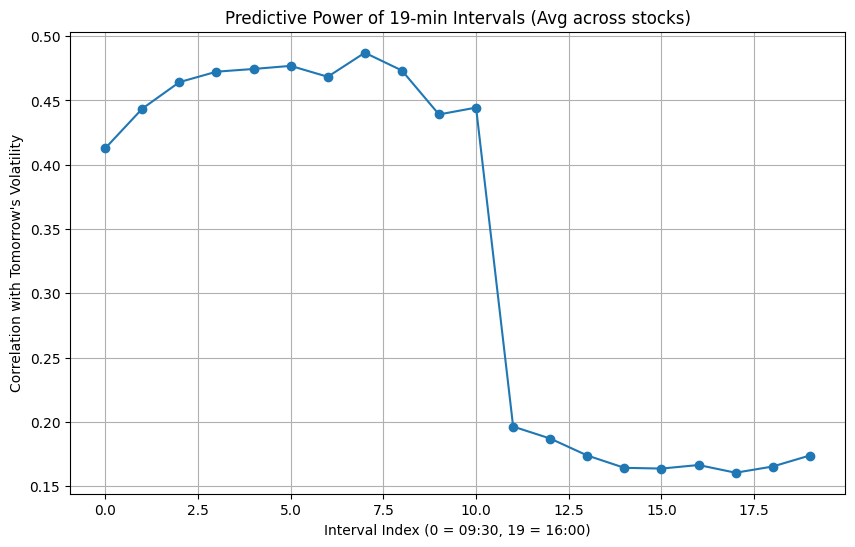

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_feature_correlations(file_list, interval_minutes=19, n_days=1):
    """
    Computes correlation between specific intraday intervals and the NEXT day's volatility.
    """
    correlations = []
    lags = []

    print(f"Computing correlations for {len(file_list)} stocks...")

    for path in file_list:
        df = pd.read_csv(path)
        # Preprocess using your strict method
        # We need raw intervals, so we grab the preprocessed df directly
        df_proc, _, _ = preprocess_stock_interval(df, 1.0, 0.0, interval_minutes=interval_minutes)

        # Target: Tomorrow's Daily RV (shifted back by rows_per_day)
        # We want to see how today's rows correlate with tomorrow's target
        rows_per_day = 380 // interval_minutes

        # Create the Target Column (Daily RV of the *Next* Day)
        # We use 'daily_rv' which repeats for the whole day.
        # Shifting by -rows_per_day aligns Today's Intervals with Tomorrow's Daily RV.
        df_proc["target_next_day"] = df_proc["daily_rv"].shift(-rows_per_day)

        # Drop NaN
        df_proc = df_proc.dropna()

        # We only care about the correlation of the feature (log_rv_feature) vs target
        # But we want to see it by "Time of Day" or "Lag"
        # Let's take the last 5 days (N rows) and correlate them

        # For simplicity: Correlate "Intraday Interval Index" with Target
        # This answers: "Is the morning volatility more predictive than evening volatility?"
        corr_by_interval = df_proc.groupby("interval_idx")[["log_rv_feature", "target_next_day"]].corr().iloc[0::2, -1]

        correlations.append(corr_by_interval.values)

    # Average across all stocks
    avg_corr = np.mean(correlations, axis=0)

    # PLOT
    plt.figure(figsize=(10, 6))
    plt.plot(avg_corr, marker='o')
    plt.title(f"Predictive Power of {interval_minutes}-min Intervals (Avg across stocks)")
    plt.xlabel(f"Interval Index (0 = 09:30, {len(avg_corr)-1} = 16:00)")
    plt.ylabel("Correlation with Tomorrow's Volatility")
    plt.grid(True)
    plt.show()

    return avg_corr

# Usage:
corr_data = analyze_feature_correlations(stock_files[:5]) # Run on subset first

['/content/drive/MyDrive/buehringer_transformer_RV/stocks/Proctor_Gamble.csv']

In [ ]:
corr_data

array([0.35957632, 0.38096362, 0.39371064, 0.41454891, 0.41636278,
       0.42270159, 0.42545555, 0.4225312 , 0.42013065, 0.44287425,
       0.42322301, 0.42997446, 0.42445636, 0.41416912, 0.43853342,
       0.41030633, 0.42717425, 0.37162891, 0.41184391, 0.40638468,
       0.40959017, 0.18526459, 0.1674583 , 0.16789366, 0.15865268,
       0.16025843, 0.15149681, 0.15676897, 0.15634474, 0.15229983,
       0.15863041, 0.154923  , 0.15187269, 0.15350124, 0.16547576,
       0.15812235, 0.16107967, 0.16186932])

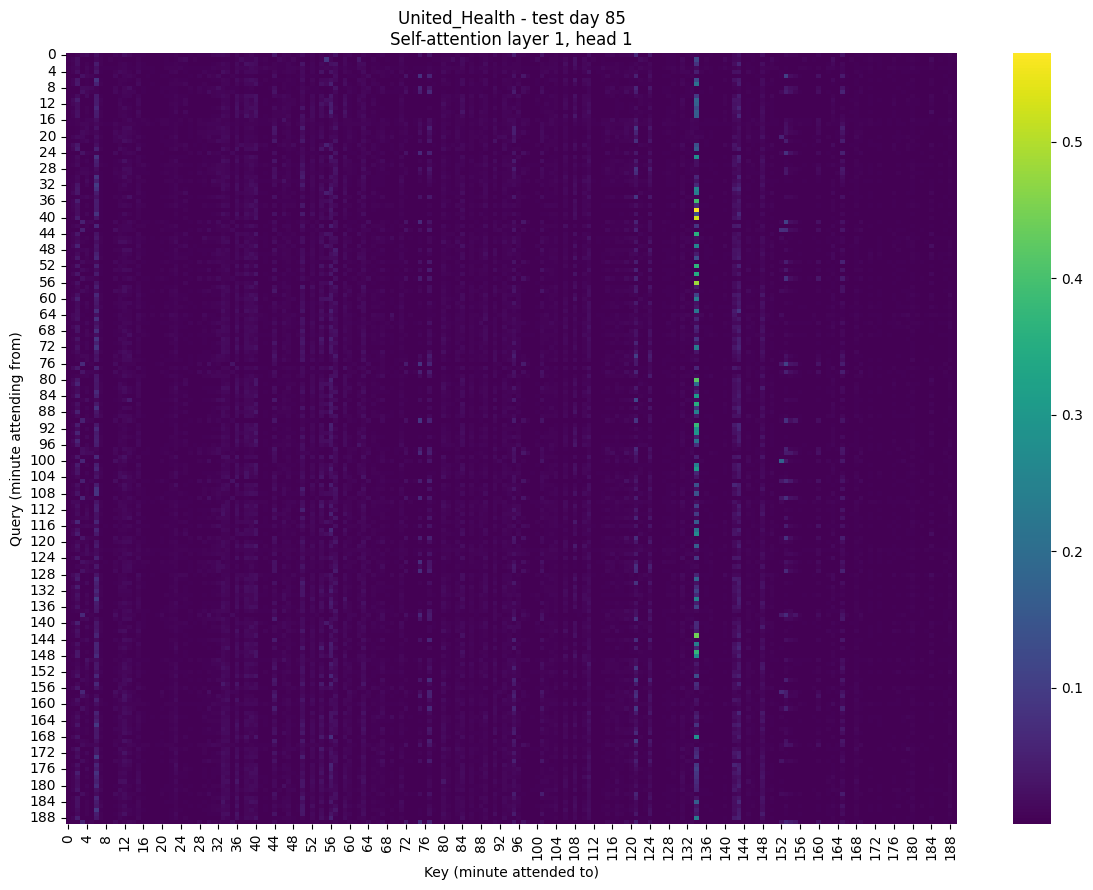

In [ ]:
stock_to_visualize = 'United_Health'
sample_index = 85

sample_sequence = X_test_dic[stock_to_visualize][sample_index]
attn_all = get_attention_maps(model, sample_sequence)

plot_attention_map_layer_head(
    attn_all,
    stock=stock_to_visualize,
    day_index=sample_index,
    layer=0,      # 0-based index → layer 2
    head=0,    # None = average over heads
    day_break=380,
    drop_cls = True,
)